In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu


In [46]:
def extract_data_state(base_directory, state):
    '''
    Extract the data from the TCR Data folder for a given state (F or R)

    ***Parameters***
    state: str, the state of the data to extract (F or R)

    ***Returns***
    data_list: list, a list of dataframes containing the data for the given scale
    ''' 
    data_list = []
    file_list = []
    for i in range(1, 22): # go through all the 21 patients
        file_folder = os.path.join(base_directory, f"Pt{i}")
        if os.path.exists(file_folder):
            file_list = [f for f in os.listdir(file_folder) if state in f] # extract the files with the given state
            for file in file_list:
                file_path = os.path.join(file_folder, file)
                data = pd.read_csv(file_path)
                data_list.append(data)
    return file_list, data_list

def extract_data_patients(base_directory, num):
    '''
    Extract the data from the TCR Data folder for a given patient

    ***Parameters***
    num: int, the patient number

    ***Returns***
    data_list: list, a list of dataframes containing the data for the given scale
    ''' 
    data_list = []
    file_list = []
    file_folder = os.path.join(base_directory, f"Pt{num}")
    if os.path.exists(file_folder):
        file_list = [f for f in os.listdir(file_folder) if 'metadata' not in f] # 跳过包含 "metadata" 的文件
        for file in file_list:
            file_path = os.path.join(file_folder, file)
            data = pd.read_csv(file_path)
            data_list.append(data)
    return file_list, data_list


## Gene usage counting

### Cross sectional analysis

In [49]:
# loading all the Flare time points
base_directory = "D:/desktop/PCM__EHR/pigeon/data/TCR Data" # should be the path to the TCR Data folder on your device

file_list_F, data_list_F = extract_data_state(base_directory, 'F')
file_list_R, data_list_R = extract_data_state(base_directory, 'R')

# concatenate all the data into one dataframe
data_F = pd.concat(data_list_F, ignore_index=True)
data_R = pd.concat(data_list_R, ignore_index=True)

data_F.head()

count      freq                                             cdr3nt  \
0      1  0.000007   TGCAGTGCCAGCAGTTTAGGGACAGGGGTAAGGTACGAGCAGTACTTC   
1      1  0.000007               TGCAGTGCCAGCATGAGCGGGTACGAGCAGTACTTC   
2      1  0.000007               TGCAGTGCCATATGGGTGCAGGGCGAGCAGTACTTC   
3      1  0.000007            TGCAGTGCGAGGACAGGGGTGAGCTACGAGCAGTACTTC   
4      1  0.000007  TGCAGTGCTAAACTGTGGGGGGACTCGGCCATGTATCTCTGTGCCA...   

                        cdr3aa         v             d        j  VEnd  DStart  \
0             CSASSLGTGVRYEQYF  TRBV20-1         TRBD1  TRBJ2-7     8     NaN   
1                 CSASMSGYEQYF  TRBV20-1         TRBD2  TRBJ2-7     8     NaN   
2                 CSAIWVQGEQYF  TRBV20-1  TRBD1, TRBD2  TRBJ2-1     8     NaN   
3                CSARTGVSYEQYF  TRBV20-1         TRBD1  TRBJ2-1     8     NaN   
4  CSAKLWGDSAMYLCASSSLRTAETQYF  TRBV20-1  TRBD1, TRBD2  TRBJ2-5    10     NaN   

   DEnd  JStart  
0   2.0      33  
1   2.0      21  
2   2.0      24  
3   2.0      27  
4   1.0      65

In [50]:
base_directory = "D:/desktop/PCM__EHR/pigeon/data/TCR Data with VDJ freq" # should be the path to the TCR Data folder on your device

file_list_F_v, data_list_F_v = extract_data_state(base_directory, 'F_v')
file_list_R_v, data_list_R_v = extract_data_state(base_directory, 'R_v')

data_F_v = pd.concat(data_list_F_v)
data_R_v = pd.concat(data_list_R_v)

data_F_v.head()

gene_segment      freq
0     TRBV10-1  0.007890
1     TRBV10-2  0.001619
2     TRBV10-3  0.026219
3     TRBV11-2  0.000697
4     TRBV11-3  0.000020

### Statistical analysis

In [ ]:
import os
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from matplotlib.lines import Line2D

def t_test_gene_differences(data_F, data_R, gene_type):
    """
    Perform t-test for each gene in the specified gene type ('v', 'd', or 'j')
    between Flare and Remission states.
    """
    if gene_type == 'vj':
        data_F['vj']=data_F['v']+'_'+data_F['j']
        data_R['vj'] = data_R['v'] + ',' + data_R['j']
        gene_type = 'vj'
    unique_genes = set(data_F[gene_type]).union(set(data_R[gene_type]))
    results = []
    results_U = []
    results_chi2 = []

    for gene in unique_genes:
        # Get frequencies for the gene in both states
        freq_F = data_F[data_F[gene_type] == gene]['freq'] if gene in data_F[gene_type].values else [0]
        freq_R = data_R[data_R[gene_type] == gene]['freq'] if gene in data_R[gene_type].values else [0]

        if gene == 'TRBV28':
        #     mean_F = np.mean(freq_F)
        #     mean_R = np.mean(freq_R)
            freq_F_write = pd.DataFrame(freq_F)
            freq_R_write = pd.DataFrame(freq_R)
            freq_F_write.to_csv('freq_F.csv', index=False)
            freq_R_write.to_csv('freq_R.csv', index=False)
            print('Standard deviation of Flare:', np.std(freq_F))
            print('Standard deviation of Remission:', np.std(freq_R))
            print('Mean of Flare:', np.mean(freq_F))
            print('Mean of Remission:', np.mean(freq_R))
            print('Median of Flare:', np.median(freq_F))
            print('Median of Remission:', np.median(freq_R))

            # print(f"Gene: {gene}, Flare Mean: {mean_F}, Remission Mean: {mean_R}")
        # Perform t-test
        t_stat, p_value = ttest_ind(freq_F, freq_R, equal_var=False)

        u_stat, u_p_value = mannwhitneyu(freq_F, freq_R)
        # chi2, chi2_p, dof, expected = chi2_contingency([freq_F, freq_R])

        # print(f"Mann-Whitney U statistic: {u_stat}, P-value: {u_p_value}")
        
        results.append({
            'gene': gene,
            't_stat': t_stat,
            'p_value': p_value
        })
        results_U.append({
            'gene': gene,
            'u_stat': u_stat,
            'u_p_value': u_p_value
        })
        # results_chi2.append({
        #     'gene': gene,
        #     'chi2': chi2,
        #     'chi2_p': chi2_p,
        #     'dof': dof,
        #     'expected': expected
        # })

    # Convert results to a DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='p_value', inplace=True)
    results_df.to_csv(f't_test_results_{gene_type}.csv', index=False)
    results_df_U = pd.DataFrame(results_U)
    results_df_U.sort_values(by='u_p_value', inplace=True)
    results_df_U.to_csv(f'mannwhitneyu_results_{gene_type}.csv', index=False)
    # results_df_chi2 = pd.DataFrame(results_chi2)
    # results_df_chi2.sort_values(by='chi2_p', inplace=True)
    # results_df_chi2.to_csv(f'chi2_results_{gene_type}_freq.csv', index=False)


    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df.head(25), x='gene', y='p_value', palette='YlGnBu')
    plt.ylabel('P-value')
    plt.xlabel('Gene Segments')
    plt.yscale('log')
    plt.title(f'P-value Results for {gene_type.upper()} Genes (t-test)')
    plt.xticks(rotation=90)
    plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1) 
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df.head(25), x='gene', y='t_stat', palette='YlGnBu')
    plt.ylabel('T-stat')
    plt.xlabel('Gene Segments')
    plt.title(f'T-test Results for {gene_type.upper()} Genes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df_U.head(20), x='gene', y='u_p_value', palette='YlGnBu')
    # plt.xlabel(f'{data_F_v['gene_type'].upper()} Gene')
    plt.ylabel('P-value')
    plt.yscale('log')
    plt.xlabel('Gene Segments')
    plt.suptitle(f'{gene_type.upper()} Genes',y=-0.1)
    plt.xticks(rotation=90)
    plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1)
    # 创建红线的图例
    # red_line = Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='Significance Threshold (p<0.05)')
    # plt.legend(handles=[red_line], loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df_U.head(25), x='gene', y='u_stat', palette='YlGnBu')
    # plt.xlabel(f'{data_F_v['gene_type'].upper()} Gene')
    plt.ylabel('U-stat')
    plt.xlabel('Gene Segments')
    plt.title(f'Mann-Whitney U Results {gene_type.upper()} Genes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # print(f"T-test results for {gene_type.upper()} genes saved to 't_test_results_{gene_type.upper()}.csv'.")
    # print(f"Mann-Whitney U results for {gene_type.upper()} genes saved to 'mannwhitneyu_results_{gene_type.upper()}.csv'.")

# Perform t-tests for 'v', 'd', and 'j' genes
t_test_gene_differences(data_F, data_R, 'v')
t_test_gene_differences(data_F, data_R, 'd')
t_test_gene_differences(data_F, data_R, 'j')
t_test_gene_differences(data_F, data_R, 'vj')


In [ ]:
def t_test_gene_differences(data_F, data_R, gene_type):
    """
    Perform t-test for each gene in the specified gene type ('v', 'd', or 'j')
    between Flare and Remission states.
    """
    unique_genes = set(data_F[gene_type]).union(set(data_R[gene_type]))
    results = []
    results_U = []
    results_chi2 = []

    for gene in unique_genes:
        # Get frequencies for the gene in both states
        freq_F = data_F[data_F[gene_type] == gene]['freq'] if gene in data_F[gene_type].values else [0]
        freq_R = data_R[data_R[gene_type] == gene]['freq'] if gene in data_R[gene_type].values else [0]

        if gene == 'TRBV28':
        #     mean_F = np.mean(freq_F)
        #     mean_R = np.mean(freq_R)
            freq_F_write = pd.DataFrame(freq_F)
            freq_R_write = pd.DataFrame(freq_R)
            freq_F_write.to_csv('freq_F.csv', index=False)
            freq_R_write.to_csv('freq_R.csv', index=False)
            print('Standard deviation of Flare:', np.std(freq_F))
            print('Standard deviation of Remission:', np.std(freq_R))
            print('Mean of Flare:', np.mean(freq_F))
            print('Mean of Remission:', np.mean(freq_R))
            print('Median of Flare:', np.median(freq_F))
            print('Median of Remission:', np.median(freq_R))

            # print(f"Gene: {gene}, Flare Mean: {mean_F}, Remission Mean: {mean_R}")
        # Perform t-test
        t_stat, p_value = ttest_ind(freq_F, freq_R, equal_var=False)

        u_stat, u_p_value = mannwhitneyu(freq_F, freq_R)
        # chi2, chi2_p, dof, expected = chi2_contingency([freq_F, freq_R])

        # print(f"Mann-Whitney U statistic: {u_stat}, P-value: {u_p_value}")
        
        results.append({
            'gene': gene,
            't_stat': t_stat,
            'p_value': p_value
        })
        results_U.append({
            'gene': gene,
            'u_stat': u_stat,
            'u_p_value': u_p_value
        })
        # results_chi2.append({
        #     'gene': gene,
        #     'chi2': chi2,
        #     'chi2_p': chi2_p,
        #     'dof': dof,
        #     'expected': expected
        # })

    # Convert results to a DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='p_value', inplace=True)
    results_df.to_csv(f't_test_results_{gene_type}.csv', index=False)
    results_df_U = pd.DataFrame(results_U)
    results_df_U.sort_values(by='u_p_value', inplace=True)
    results_df_U.to_csv(f'mannwhitneyu_results_{gene_type}.csv', index=False)
    # results_df_chi2 = pd.DataFrame(results_chi2)
    # results_df_chi2.sort_values(by='chi2_p', inplace=True)
    # results_df_chi2.to_csv(f'chi2_results_{gene_type}_freq.csv', index=False)


    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df.head(18), x='gene', y='p_value', palette='viridis')
    plt.ylabel('P-value')
    plt.yscale('log')
    plt.title(f'P-value Results for {gene_type} Genes (t-test)')
    plt.xticks(rotation=90)
    plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1) 
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df.head(18), x='gene', y='t_stat', palette='viridis')
    plt.ylabel('T-stat')
    plt.title(f'T-test Results for {gene_type} Genes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df_U.head(18), x='gene', y='u_p_value', palette='viridis')
    # plt.xlabel(f'{data_F_v['gene_type'].upper()} Gene')
    plt.ylabel('P-value')
    plt.yscale('log')
    plt.title(f'P-value Results for {gene_type} Genes (Mann-Whitney U)')
    plt.xticks(rotation=90)
    plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df_U.head(18), x='gene', y='u_stat', palette='viridis')
    # plt.xlabel(f'{data_F_v['gene_type'].upper()} Gene')
    plt.ylabel('U-stat')
    plt.title(f'Mann-Whitney U Results {gene_type} Genes')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # print(f"T-test results for {gene_type.upper()} genes saved to 't_test_results_{gene_type.upper()}.csv'.")
    # print(f"Mann-Whitney U results for {gene_type.upper()} genes saved to 'mannwhitneyu_results_{gene_type.upper()}.csv'.")

# Perform t-tests for 'v', 'd', and 'j' genes
t_test_gene_differences(data_F, data_R, 'v')
t_test_gene_differences(data_F, data_R, 'd')
t_test_gene_differences(data_F, data_R, 'j')

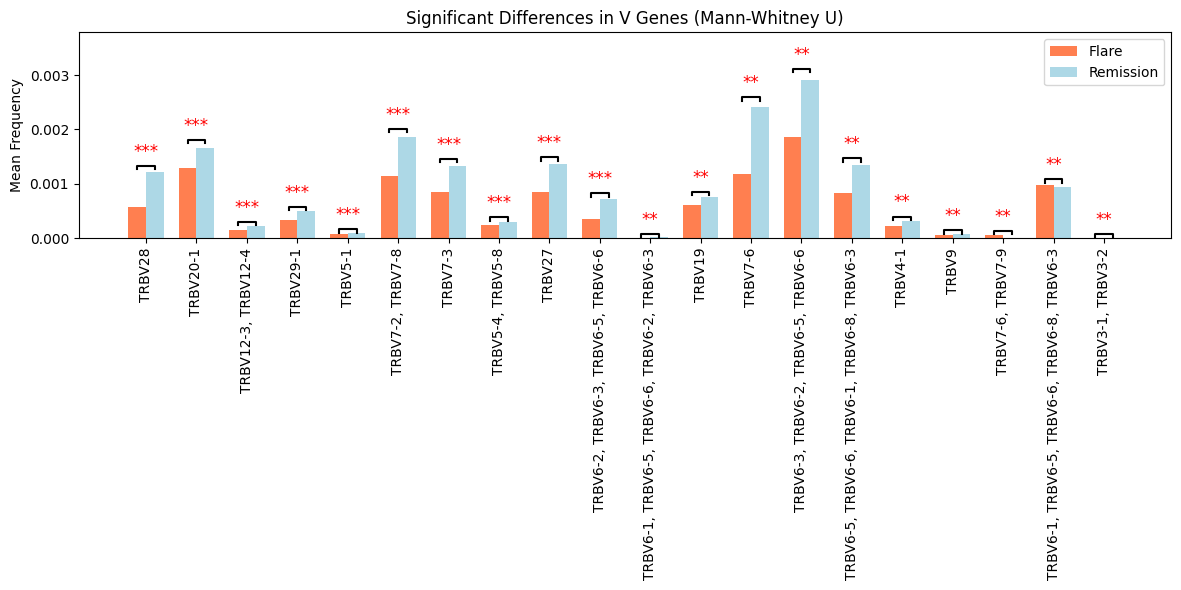

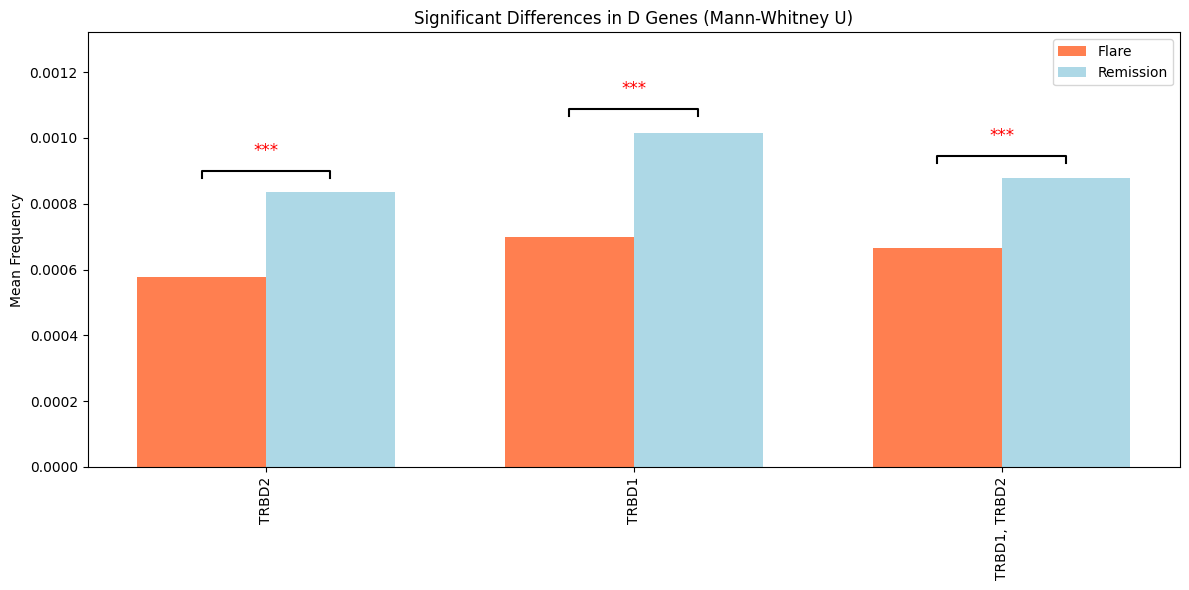

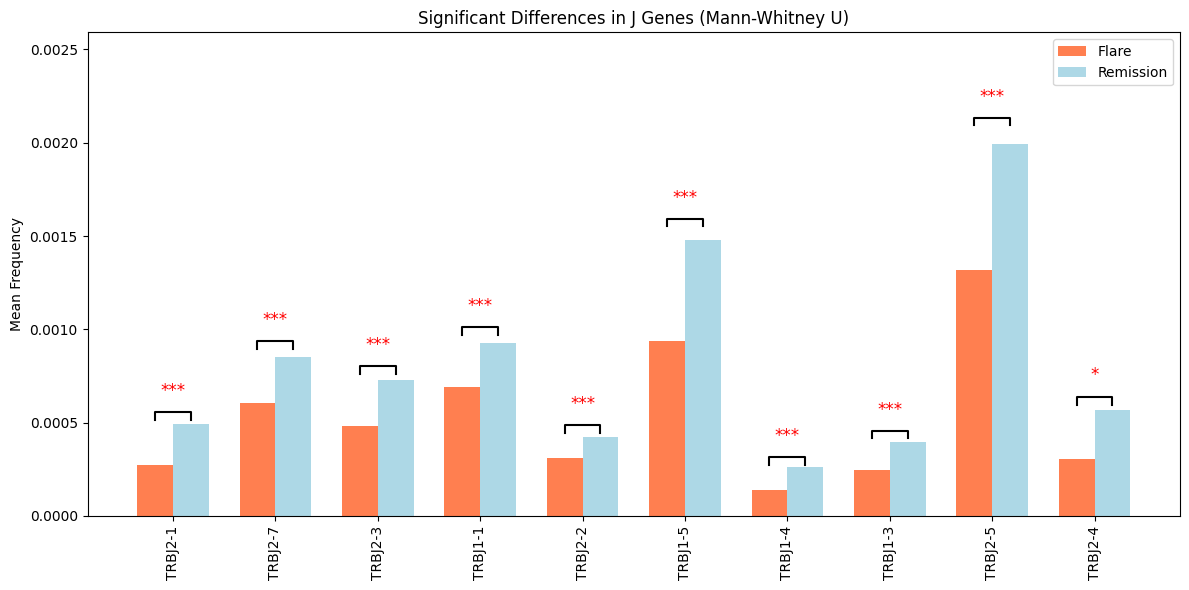

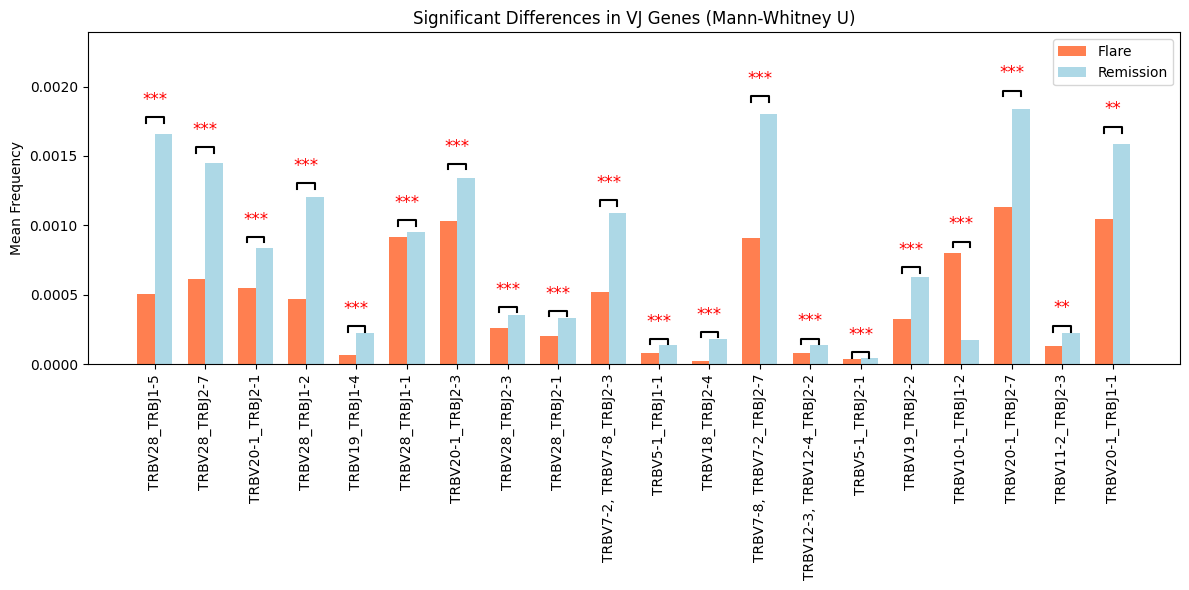

In [52]:
def plot_significance_bar(ax, x1, x2, y, p_value, line_offset=0.02, text_offset=0.03):
    '''
    This function plots a significance bar between two bars on a bar plot, with the p-value annotated above.

    ***Parameters***
    ax: matplotlib.axes.Axes, the axes on which to plot the significance bar
    x1: float, the x-coordinate of the left bar
    x2: float, the x-coordinate of the right bar
    y: float, the height of the bars
    p_value: float, the p-value of the statistical test
    line_offset: float, the vertical offset of the connecting line
    text_offset: float, the vertical offset of the p-value annotation

    ***Returns***
    None
    '''
    bar_height = line_offset * (plt.ylim()[1] - plt.ylim()[0])
    text_height = text_offset * (plt.ylim()[1] - plt.ylim()[0])

    ax.plot([x1, x1, x2, x2], [y, y + bar_height, y + bar_height, y], lw=1.5, c='black')

    # Annotate with p-value
    annotation = ''
    if p_value < 0.001:
        annotation = '***'
    elif p_value < 0.01:
        annotation = '**'
    elif p_value < 0.05:
        annotation = '*'
    if annotation:
        ax.text((x1 + x2) / 2, y + bar_height + text_height, annotation, ha='center', va='bottom', color='red', fontsize=12)


def mannwhitneyu_test_gene_differences(data_F, data_R, gene_type):
    '''
    This function performs a t-test to compare the frequency of genes between two states (Flare and Remission) and plots the significant differences.

    ***Parameters***
    data_F: pd.DataFrame, the data for the Flare state
    data_R: pd.DataFrame, the data for the Remission state
    gene_type: str, the type of gene to compare (v, d, j, or vj)

    ***Returns***
    None
    '''
    if gene_type == 'vj':
        data_F['vj'] = data_F['v'] + '_' + data_F['j']
        data_R['vj'] = data_R['v'] + '_' + data_R['j']
        gene_type = 'vj'
    
    unique_genes = set(data_F[gene_type]).union(set(data_R[gene_type]))
    results = []

    for gene in unique_genes:
        # Get frequencies for the gene in both states
        freq_F = data_F[data_F[gene_type] == gene]['freq'] if gene in data_F[gene_type].values else [0]
        freq_R = data_R[data_R[gene_type] == gene]['freq'] if gene in data_R[gene_type].values else [0]

        # Perform statistical tests
        u_stat, u_p_value = mannwhitneyu(freq_F, freq_R)

        # Record results
        results.append({
            'gene': gene,
            'mean_F': np.mean(freq_F),
            'mean_R': np.mean(freq_R),
            'p_value_u': u_p_value
        })

    # Convert results to DataFrame and filter significant results
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='p_value_u', inplace=True)
    results_df = results_df.head(20)
    # Plot significant genes with p < 0.05
    significant_genes = results_df[results_df['p_value_u'] < 0.05]
    if not significant_genes.empty:
        plt.figure(figsize=(12, 6))
        ax = plt.gca()

        bar_width = 0.35
        indices = np.arange(len(significant_genes)) 

        # Plot bars for Flare and Remission
        bars1 = plt.bar(indices, significant_genes['mean_F'], bar_width, label='Flare', color='coral')
        bars2 = plt.bar(indices + bar_width, significant_genes['mean_R'], bar_width, label='Remission', color='lightblue')

        # Add p-value annotations with *, **, ***
        for i, (index, row) in enumerate(significant_genes.iterrows()):
            p_val = row['p_value_u']
            x1 = indices[i]
            x2 = indices[i] + bar_width
            y = max(row['mean_F'], row['mean_R']) * 1.05
            plot_significance_bar(ax, x1, x2, y, p_val)

        # Customize plot
        if gene_type=='v':
            simplified_labels = [gene for gene in significant_genes['gene']]       
            ax.set_xticks(indices + bar_width / 2)  
            ax.set_xticklabels(simplified_labels, rotation=90) 
        else:
            plt.xticks(indices + bar_width / 2, significant_genes['gene'], rotation=90)
        y_max = max(significant_genes['mean_F'].max(), significant_genes['mean_R'].max())
        plt.ylim(0, y_max * 1.3) 
        plt.ylabel('Mean Frequency')
        plt.title(f'Significant Differences in {gene_type.upper()} Genes (Mann-Whitney U)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"No significant differences found for {gene_type.upper()} genes.")



# Example usage
mannwhitneyu_test_gene_differences(data_F, data_R, 'v')
mannwhitneyu_test_gene_differences(data_F, data_R, 'd')
mannwhitneyu_test_gene_differences(data_F, data_R, 'j')
mannwhitneyu_test_gene_differences(data_F, data_R, 'vj')


In [54]:
# '''
# This block of code calculates the sum of frequencies for each unique value in a specified column of a DataFrame. 
# '''

# def calculate_freq_sum(data, column):
#     '''
#     This function calculates the sum of the frequencies for each unique value in the specified column.

#     ***Parameters***
#     data: pd.DataFrame, the input data
#     column: str, the column name to calculate the frequency sum for

#     ***Returns***
#     freq_sum: pd.Series, the sum of frequencies for each unique value in the specified column
#     '''
#     exploded = data[[column, 'freq']].dropna()
#     exploded[column] = exploded[column].str.split(', ')
#     exploded = exploded.explode(column)
#     freq_sum = exploded.groupby(column)['freq'].sum()
#     return freq_sum


# def process_file(file_path, output_dir):
#     '''
#     This function processes a single CSV file containing TCR data and calculates the sum of frequencies for each unique V, D, and J gene segment.

#     ***Parameters***
#     file_path: str, the path to the input CSV file
#     output_dir: str, the directory to save the output CSV files

#     ***Returns***
#     None
#     '''
#     data = pd.read_csv(file_path)
#     base_name = os.path.splitext(os.path.basename(file_path))[0]
#     v_freq_sum = calculate_freq_sum(data, 'v')
#     d_freq_sum = calculate_freq_sum(data, 'd')
#     j_freq_sum = calculate_freq_sum(data, 'j')
#     os.makedirs(output_dir, exist_ok=True)
#     v_freq_sum.to_csv(os.path.join(output_dir, f"{base_name}_v.csv"), header=['freq'], index_label='gene_segment')
#     d_freq_sum.to_csv(os.path.join(output_dir, f"{base_name}_d.csv"), header=['freq'], index_label='gene_segment')
#     j_freq_sum.to_csv(os.path.join(output_dir, f"{base_name}_j.csv"), header=['freq'], index_label='gene_segment')
#     print(f"Processed: {file_path}")


# def batch_process(directory):
#     '''
#     This function processes all CSV files in a directory and calculates the sum of frequencies for each unique V, D, and J gene segment.

#     ***Parameters***
#     directory: str, the directory containing the input CSV files

#     ***Returns***
#     None
#     '''
#     for file_name in os.listdir(directory):
#         if file_name.endswith('.csv'):
#             file_path = os.path.join(directory, file_name)
#             process_file(file_path, directory)


# directory_path = r"D:\desktop\PCM__EHR\pigeon\data\TCR Data copy\Pt21"
# batch_process(directory_path)


### Longitudinal Analysis

In [24]:
def plot_gene_usage(file_paths, genetype, figsize=(20, 8), head=True, save_path=None):
    '''
    Plot the gene usage frequency for multiple datasets.

    Parameters:
    file_paths: list of str, paths to the CSV files
    labels: list of str, labels for each dataset
    figsize: tuple, size of the figure (width, height)

    Returns:
    None
    '''
    data = [pd.read_csv(file) for file in file_paths]
    if genetype == 'V':
        if head:
            gene_usages = [df['v'].value_counts(normalize=True).head(20) for df in data]
        else:
            gene_usages = [df['v'].value_counts(normalize=True).tail(20) for df in data]
    elif genetype == 'J':
        gene_usages = [df['j'].value_counts(normalize=True) for df in data]
    elif genetype == 'D':
        gene_usages = [df['d'].dropna().value_counts(normalize=True) for df in data]

    # get the index of the genes
    genes = list(set().union(*[usage.index for usage in gene_usages]))
    index = np.arange(len(genes))
    # get the values of the genes
    values = [[usage.get(gene, 0) for gene in genes] for usage in gene_usages]

    # plot
    bar_width = 0.8 / len(file_paths)  

    fig, ax = plt.subplots(figsize=figsize)
    for i, (value, file_paths) in enumerate(zip(values, file_paths)):
        label = file_paths.split('/')[-1].split('.')[0]
        color = 'coral' if 'F' in label else 'lightblue' if 'R' in label else 'green'
        ax.bar(index + i * bar_width, value, bar_width, label=label, color=color)

    ax.set_xlabel(f'{genetype} Gene')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{genetype} Gene Usage Frequency among Timepoints')
    ax.set_xticks(index + i/2 * bar_width)
    ax.set_xticklabels(genes, rotation=90)
    ax.legend()

    return fig, ax


C:\Users\administer\AppData\Local\Temp\ipykernel_32252\2400573891.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


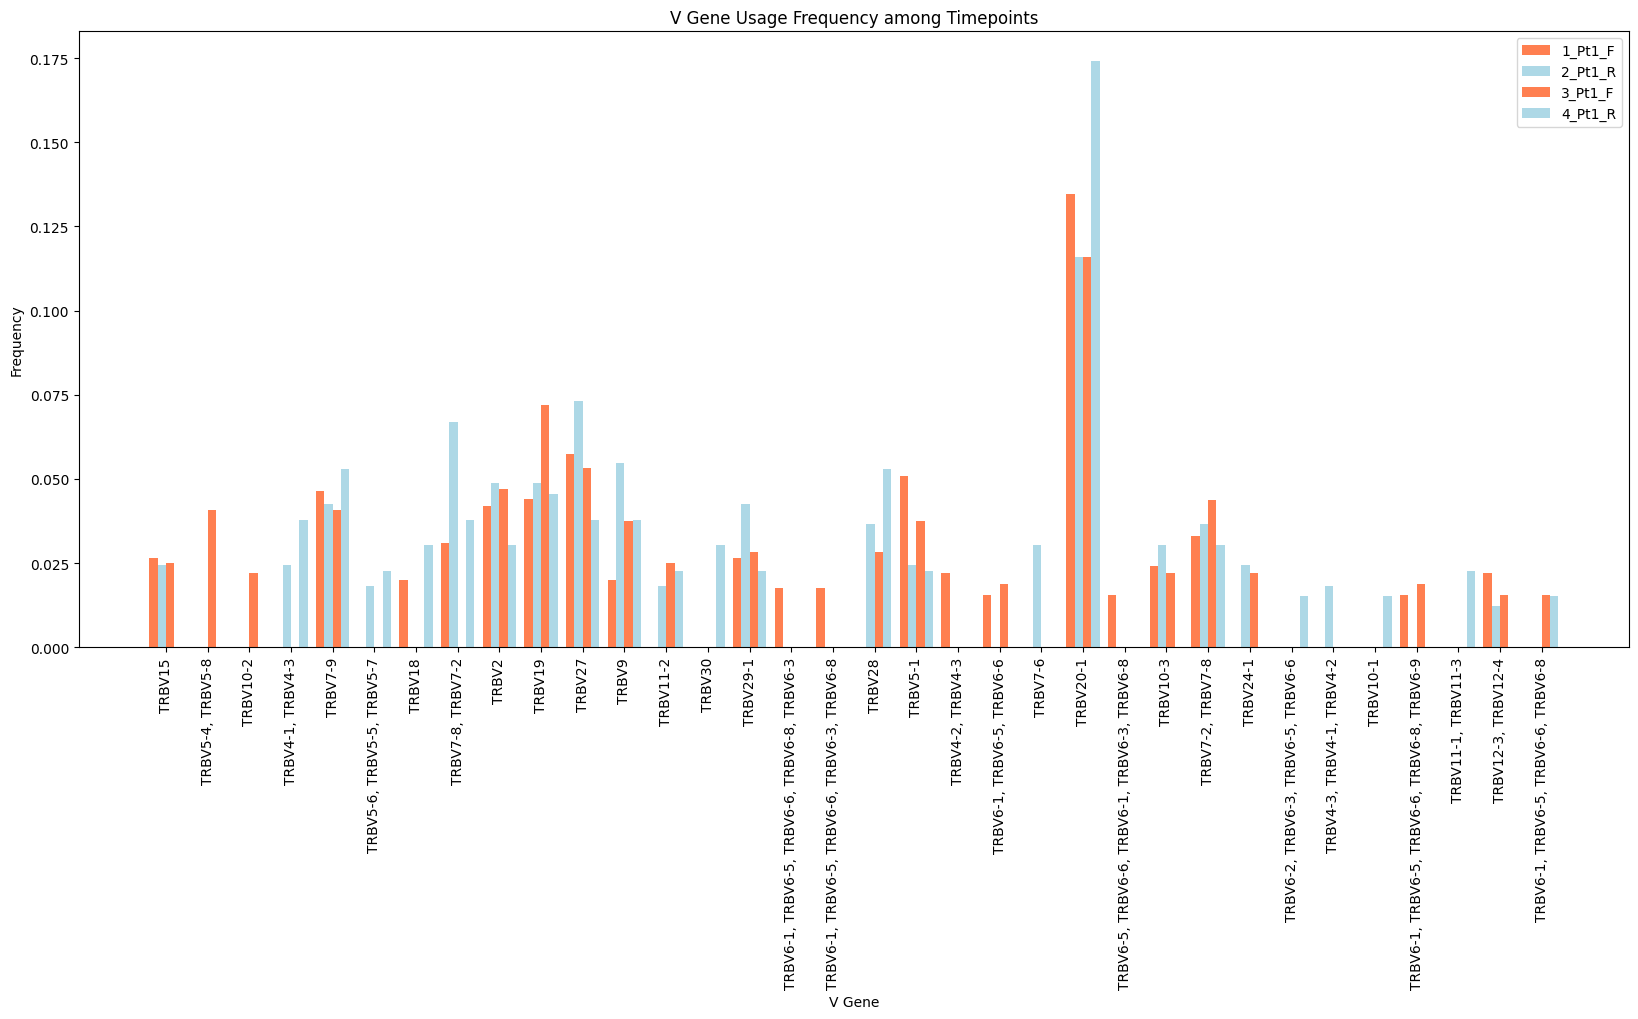

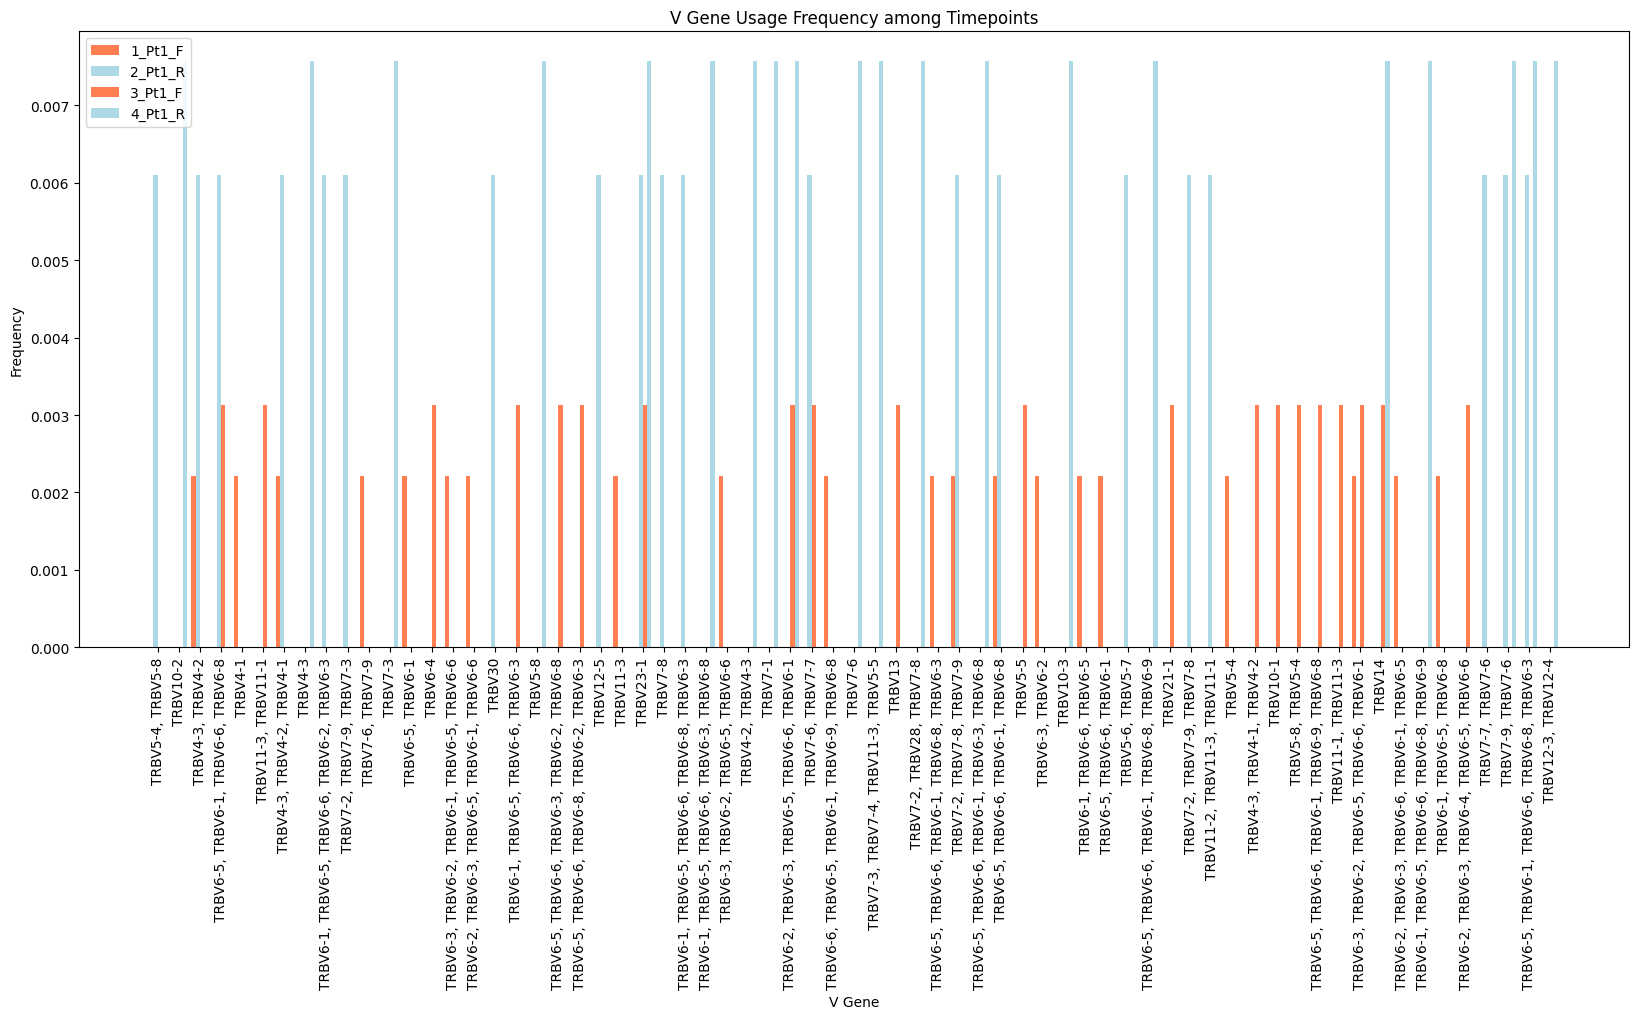

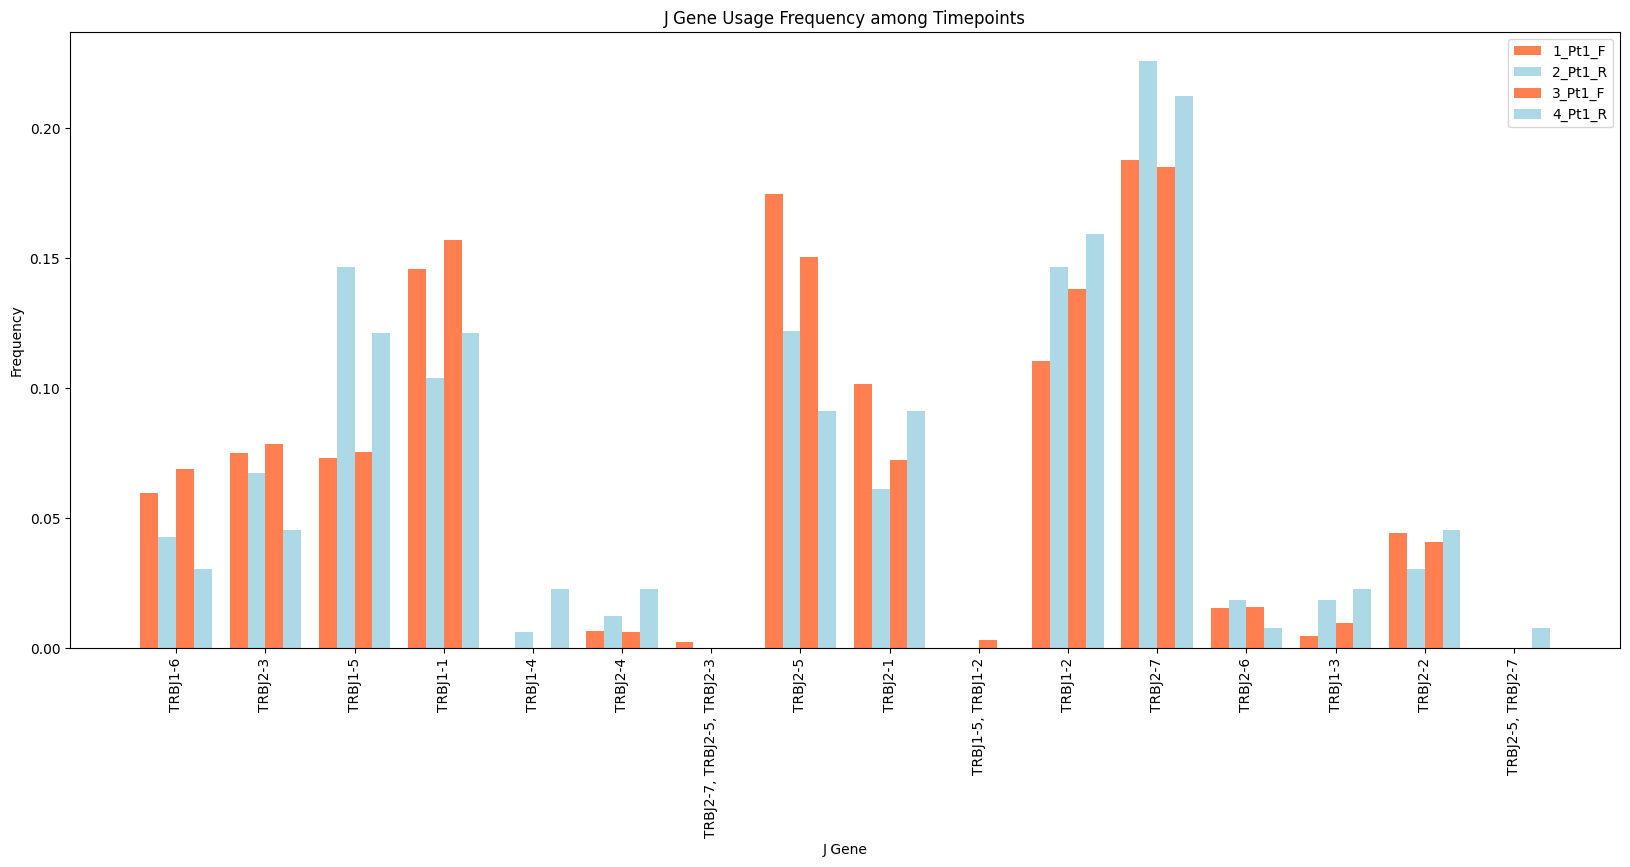

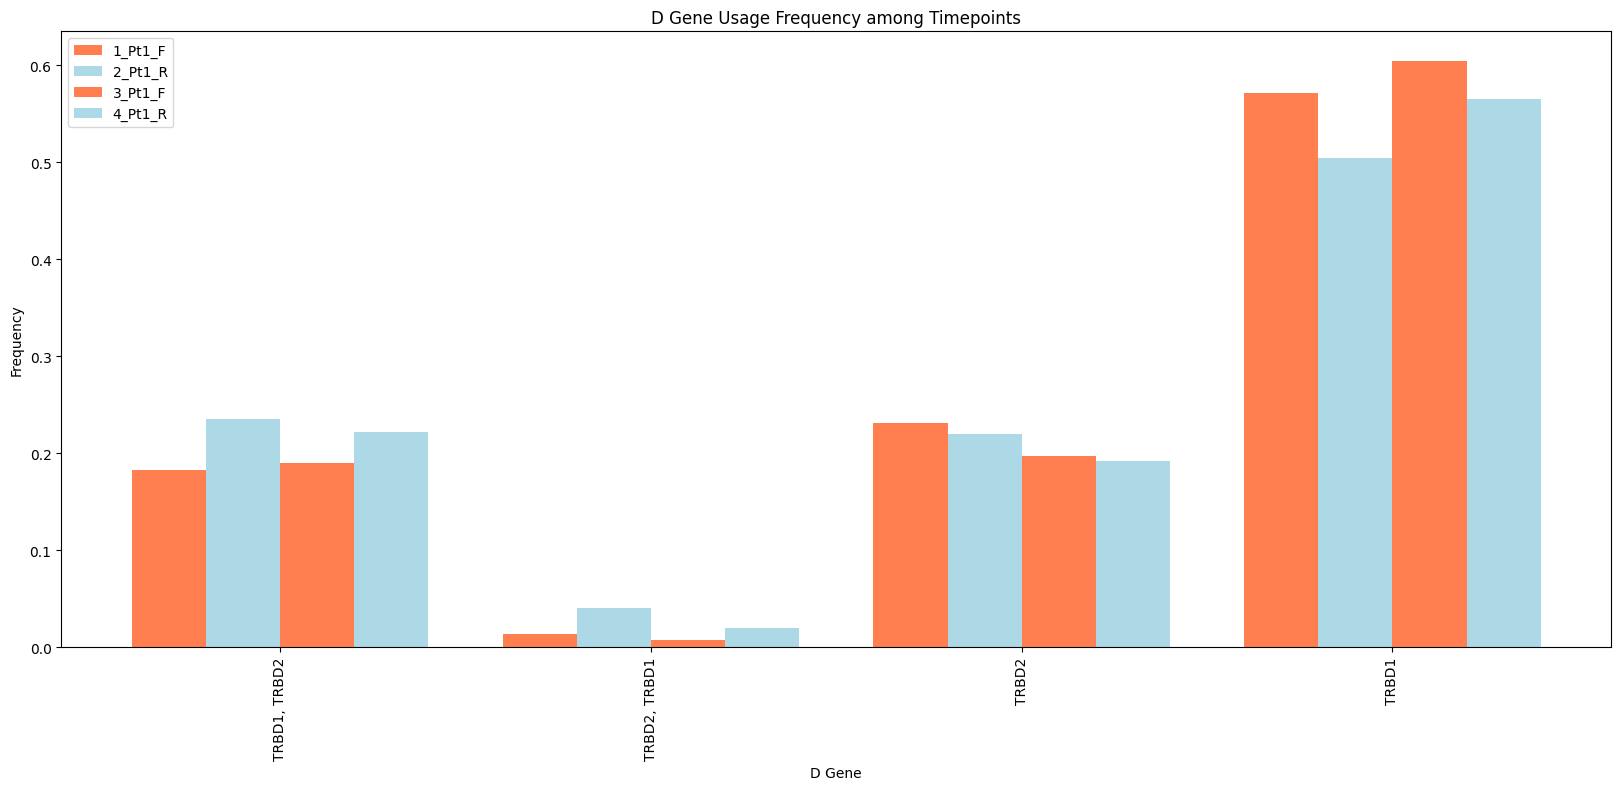

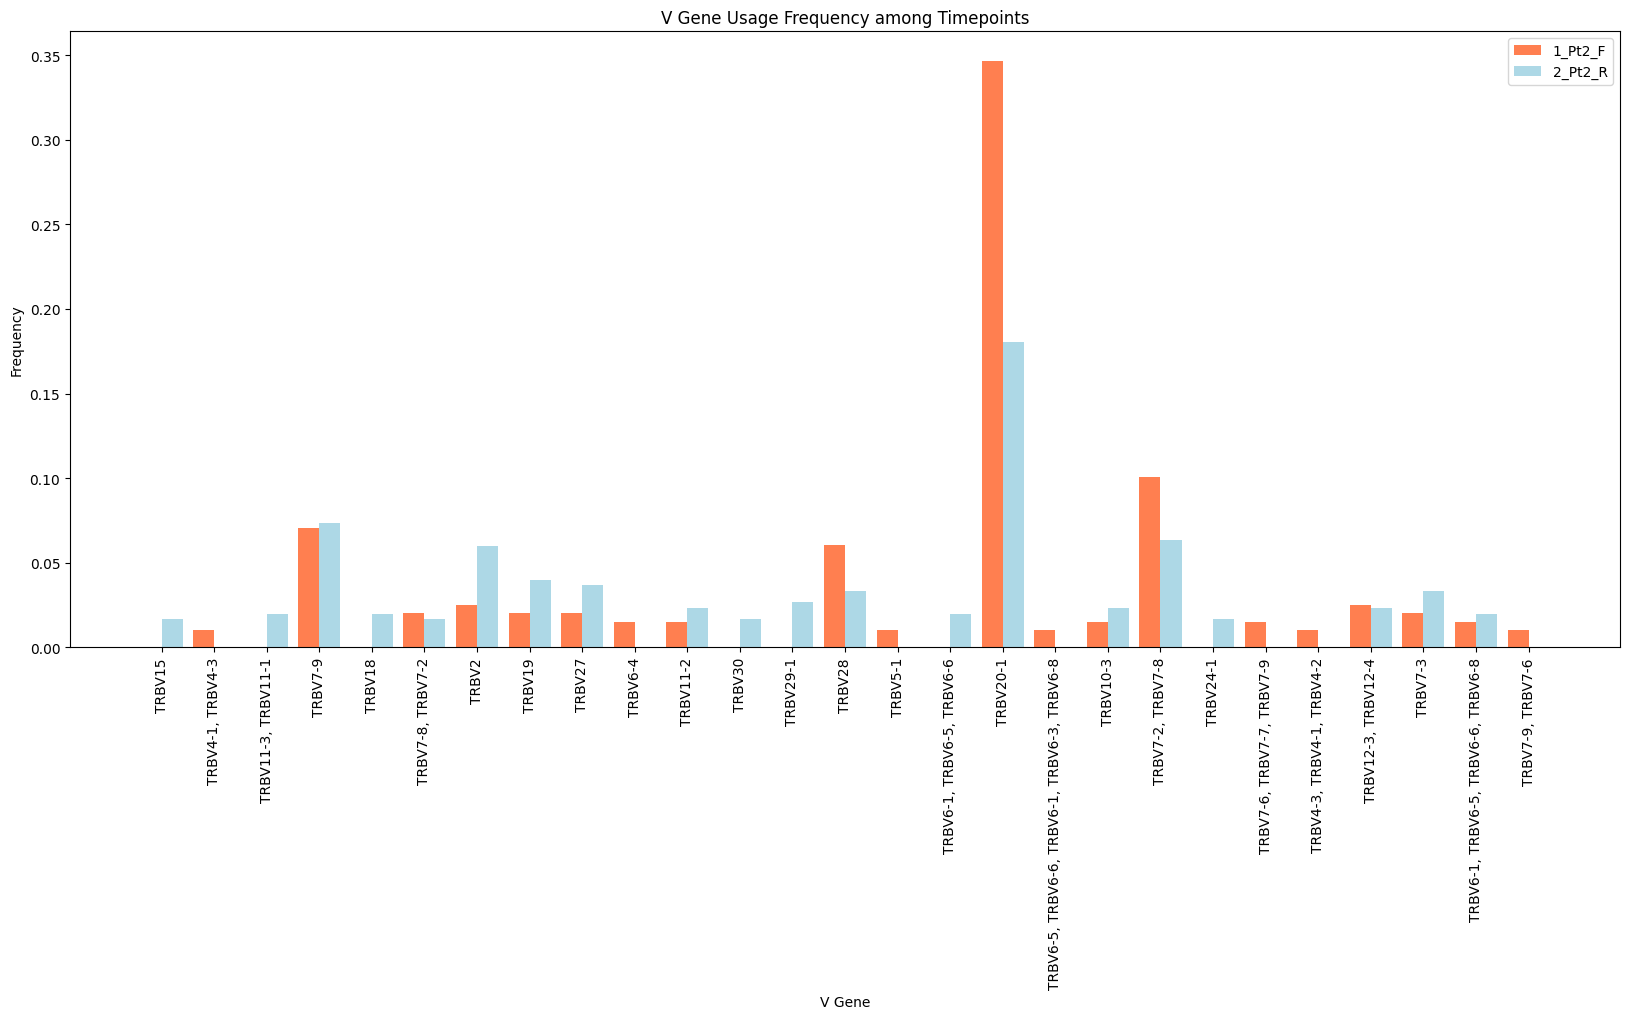

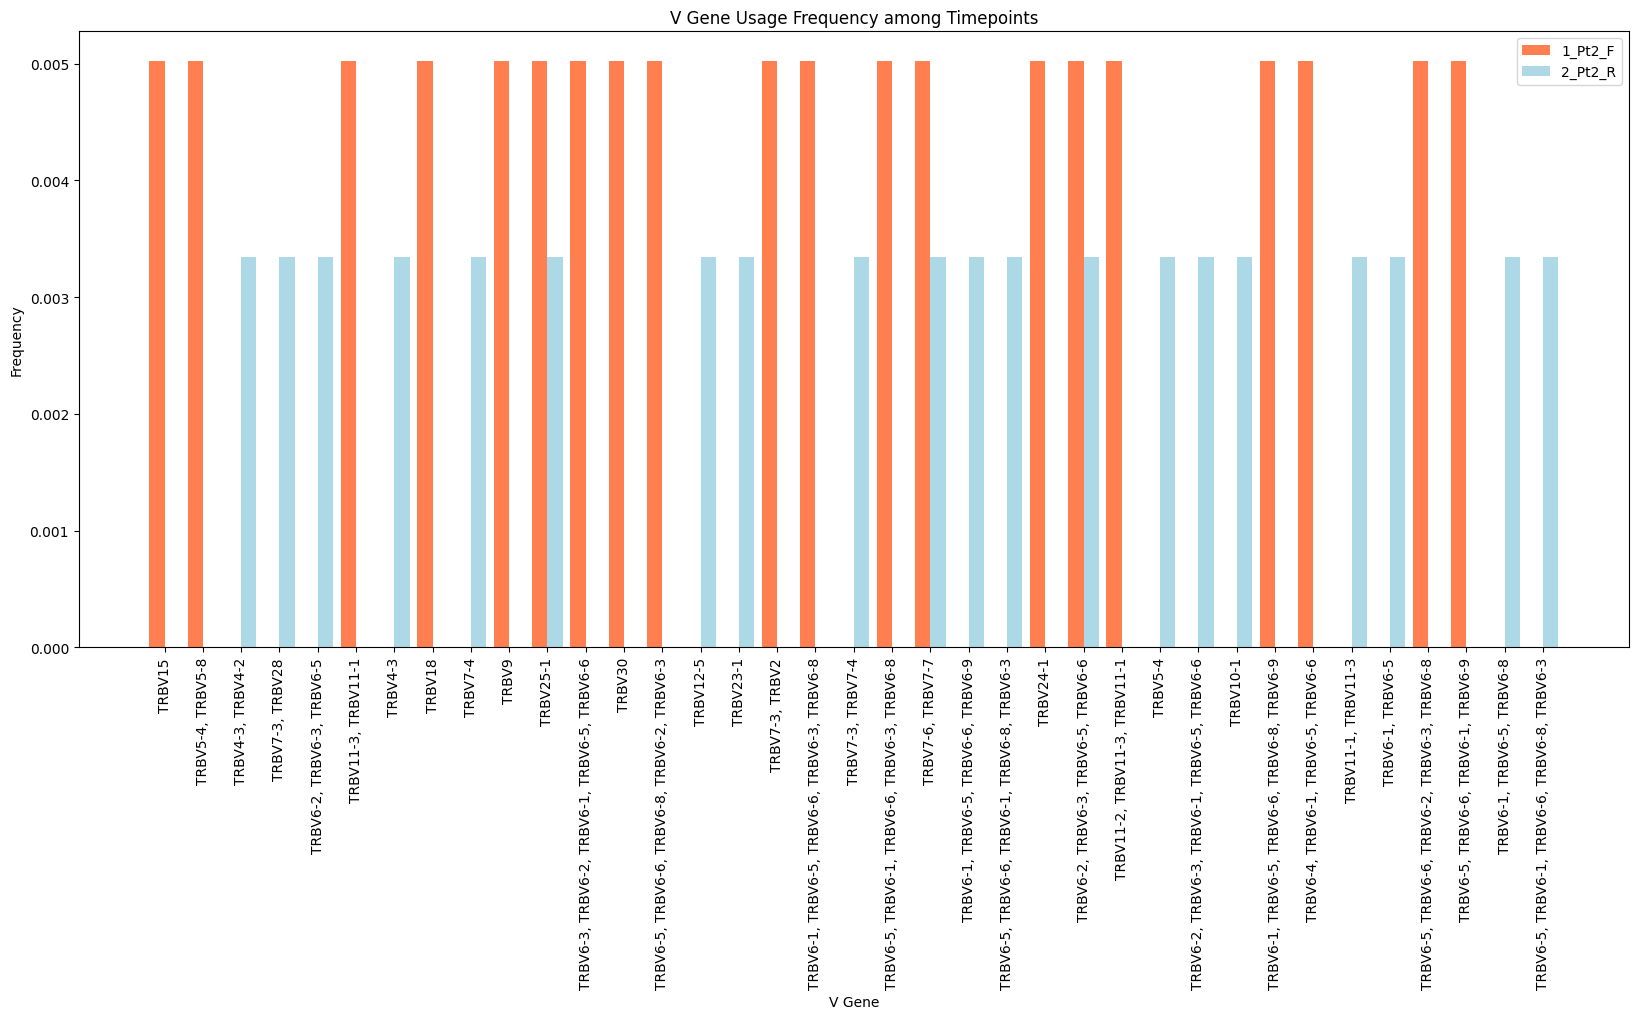

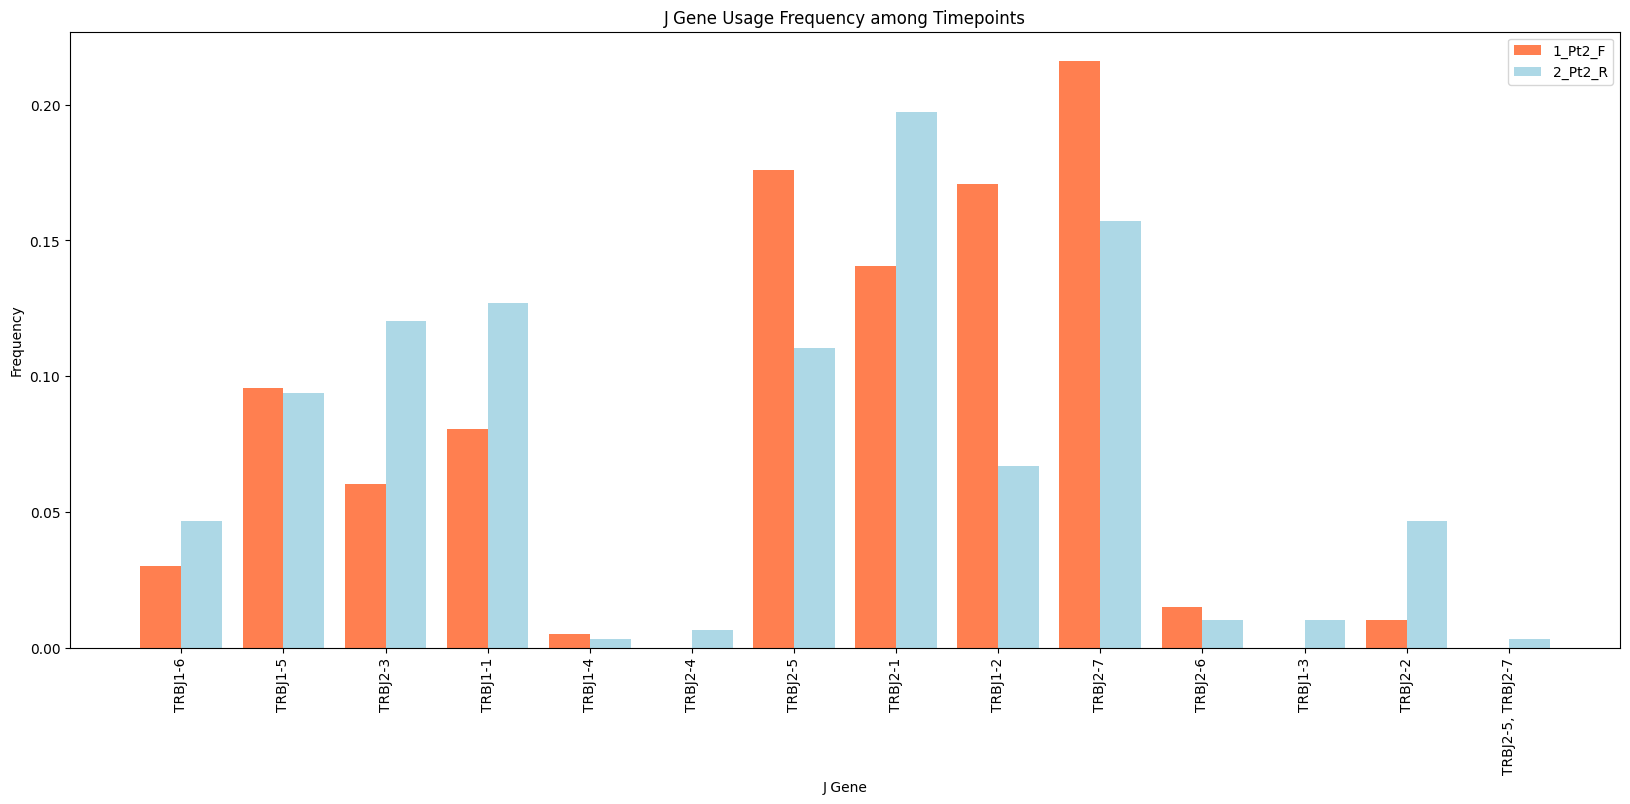

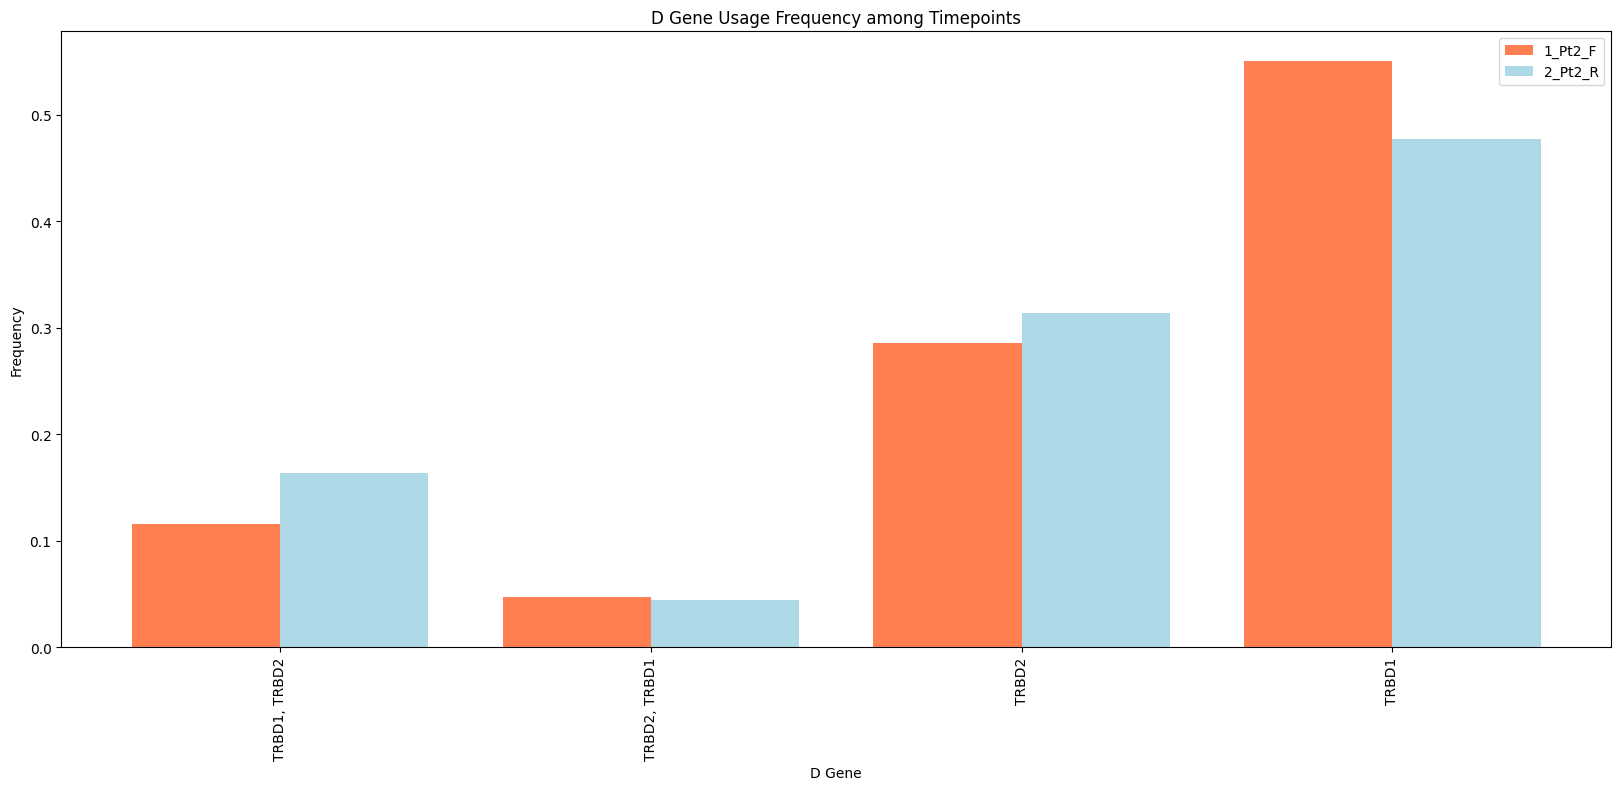

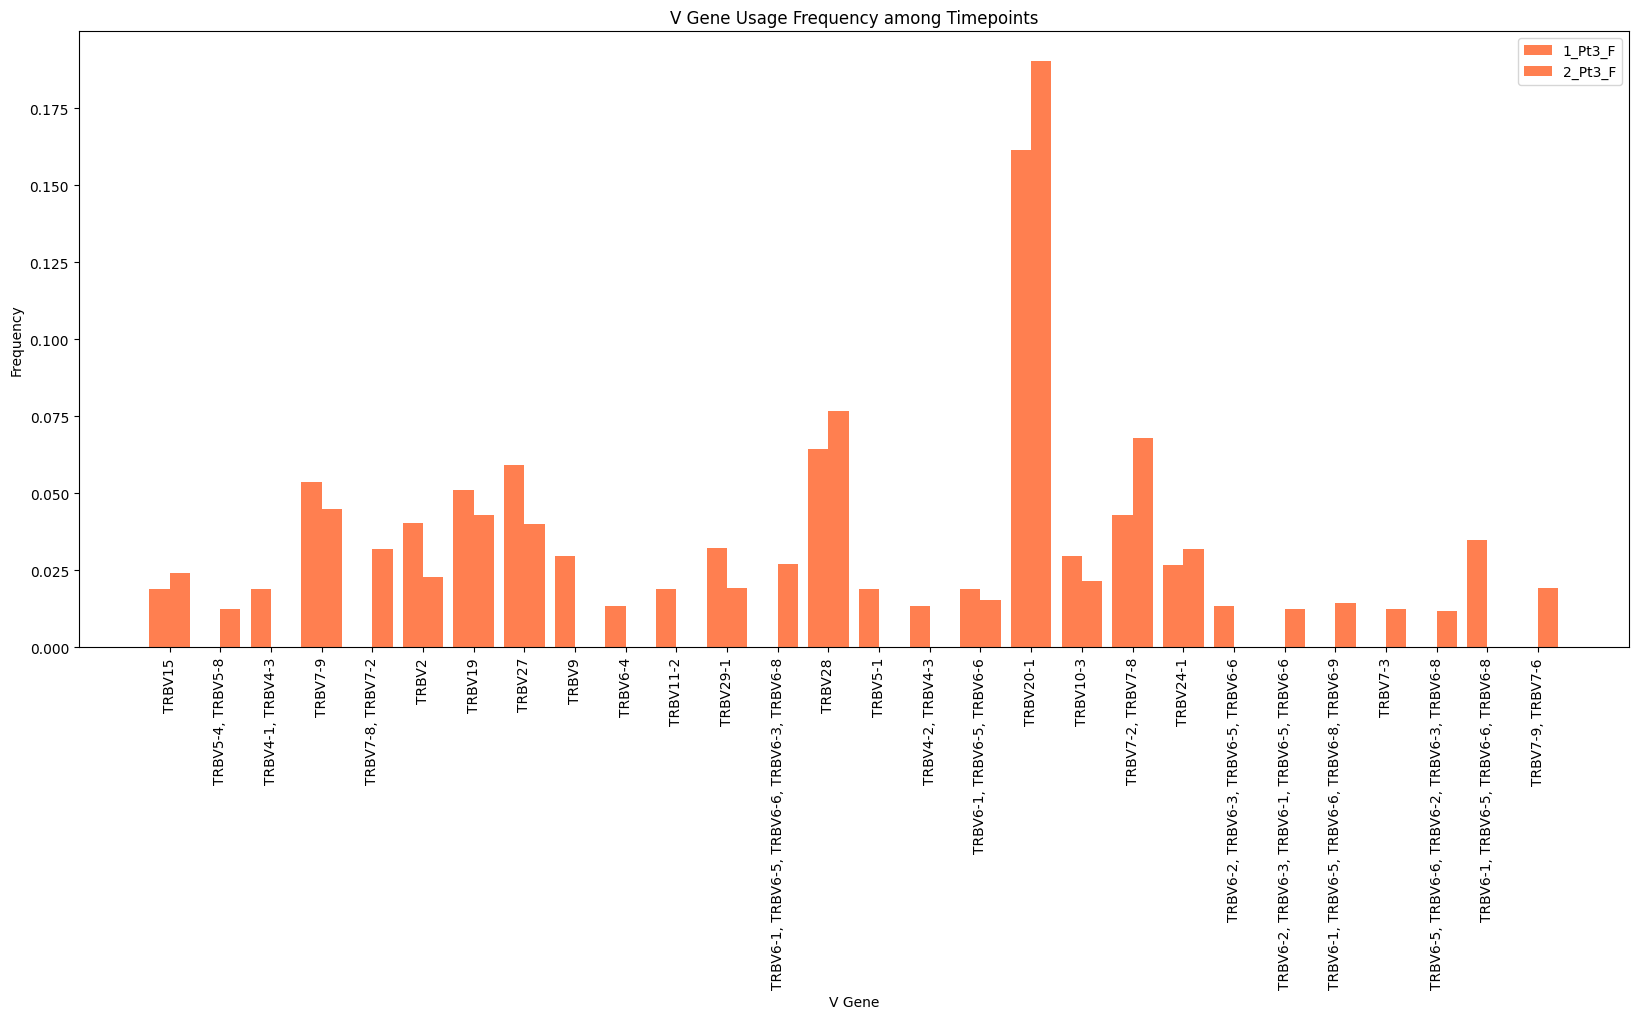

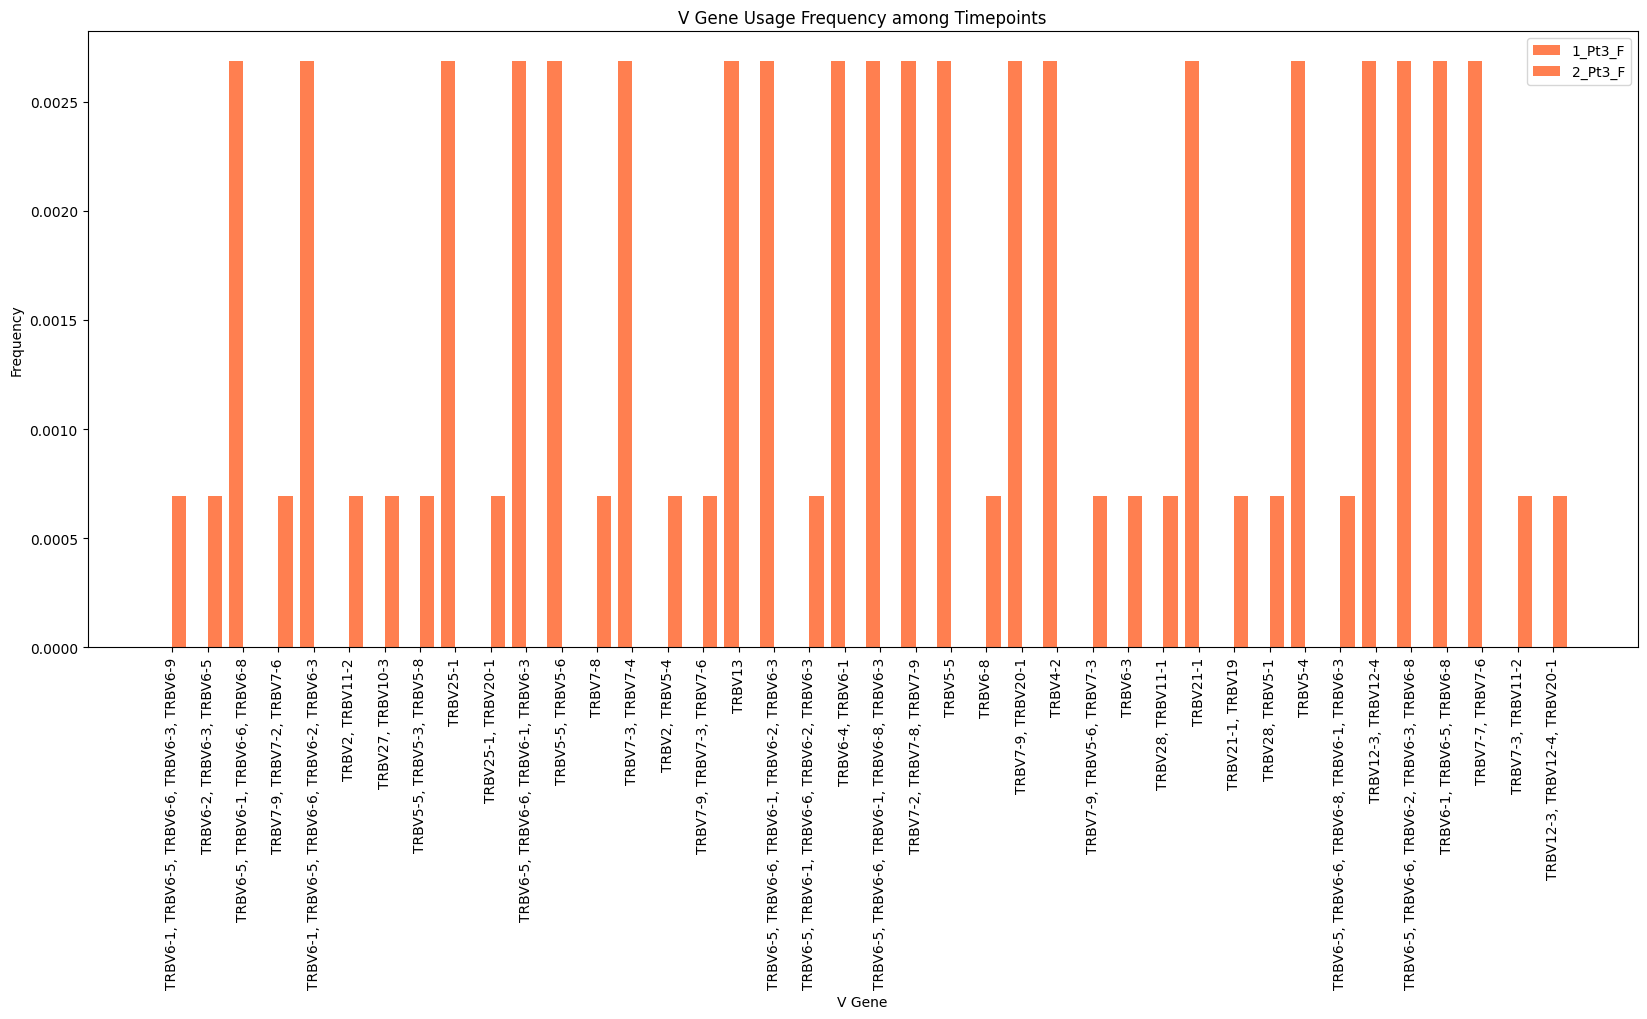

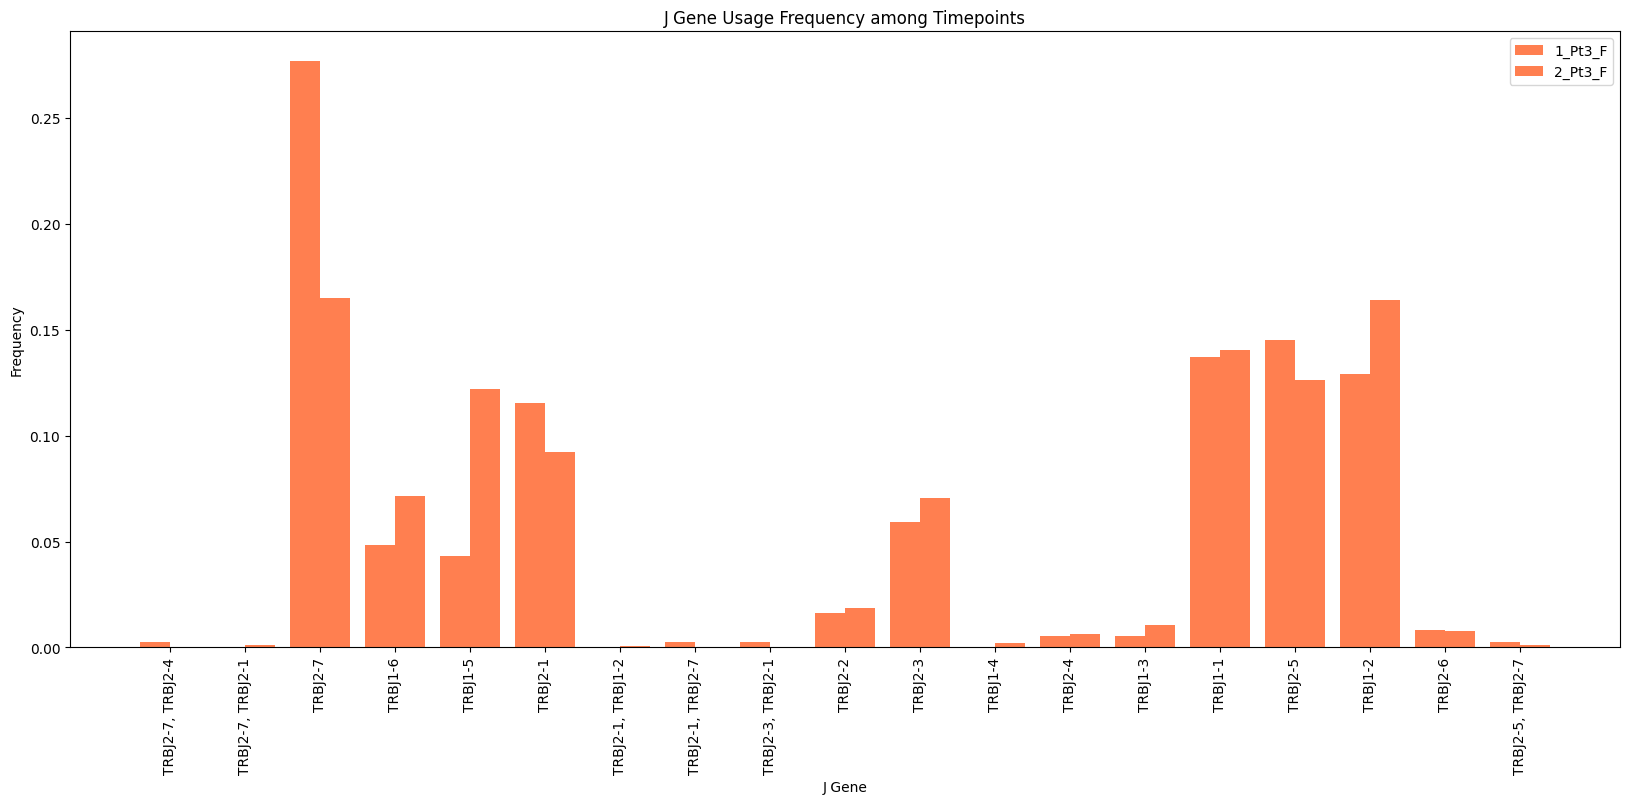

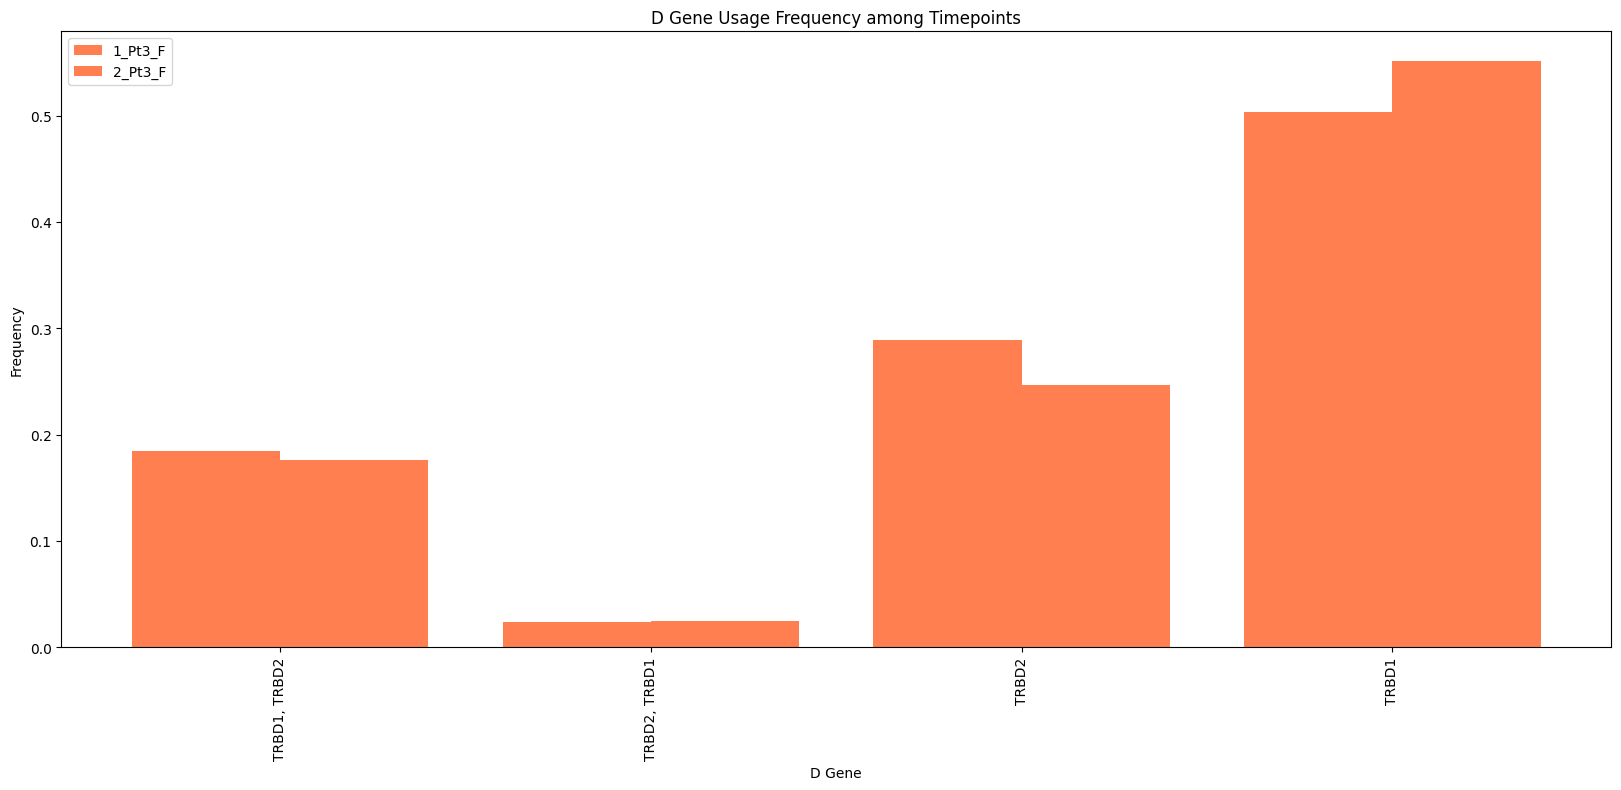

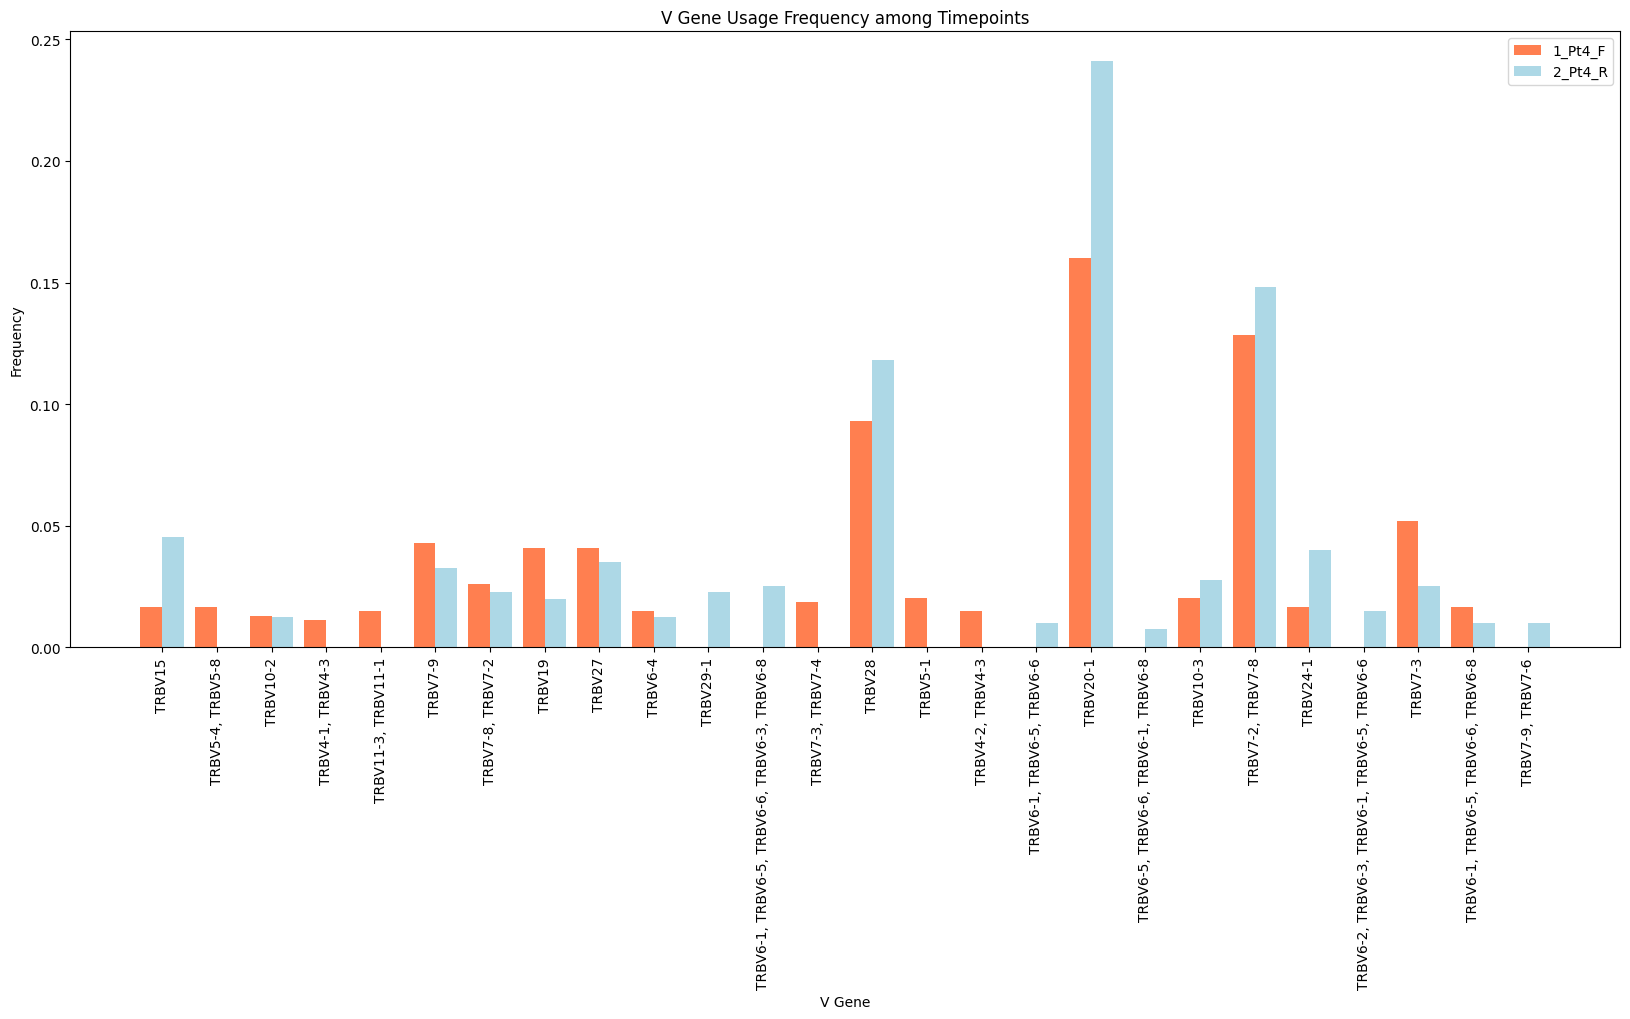

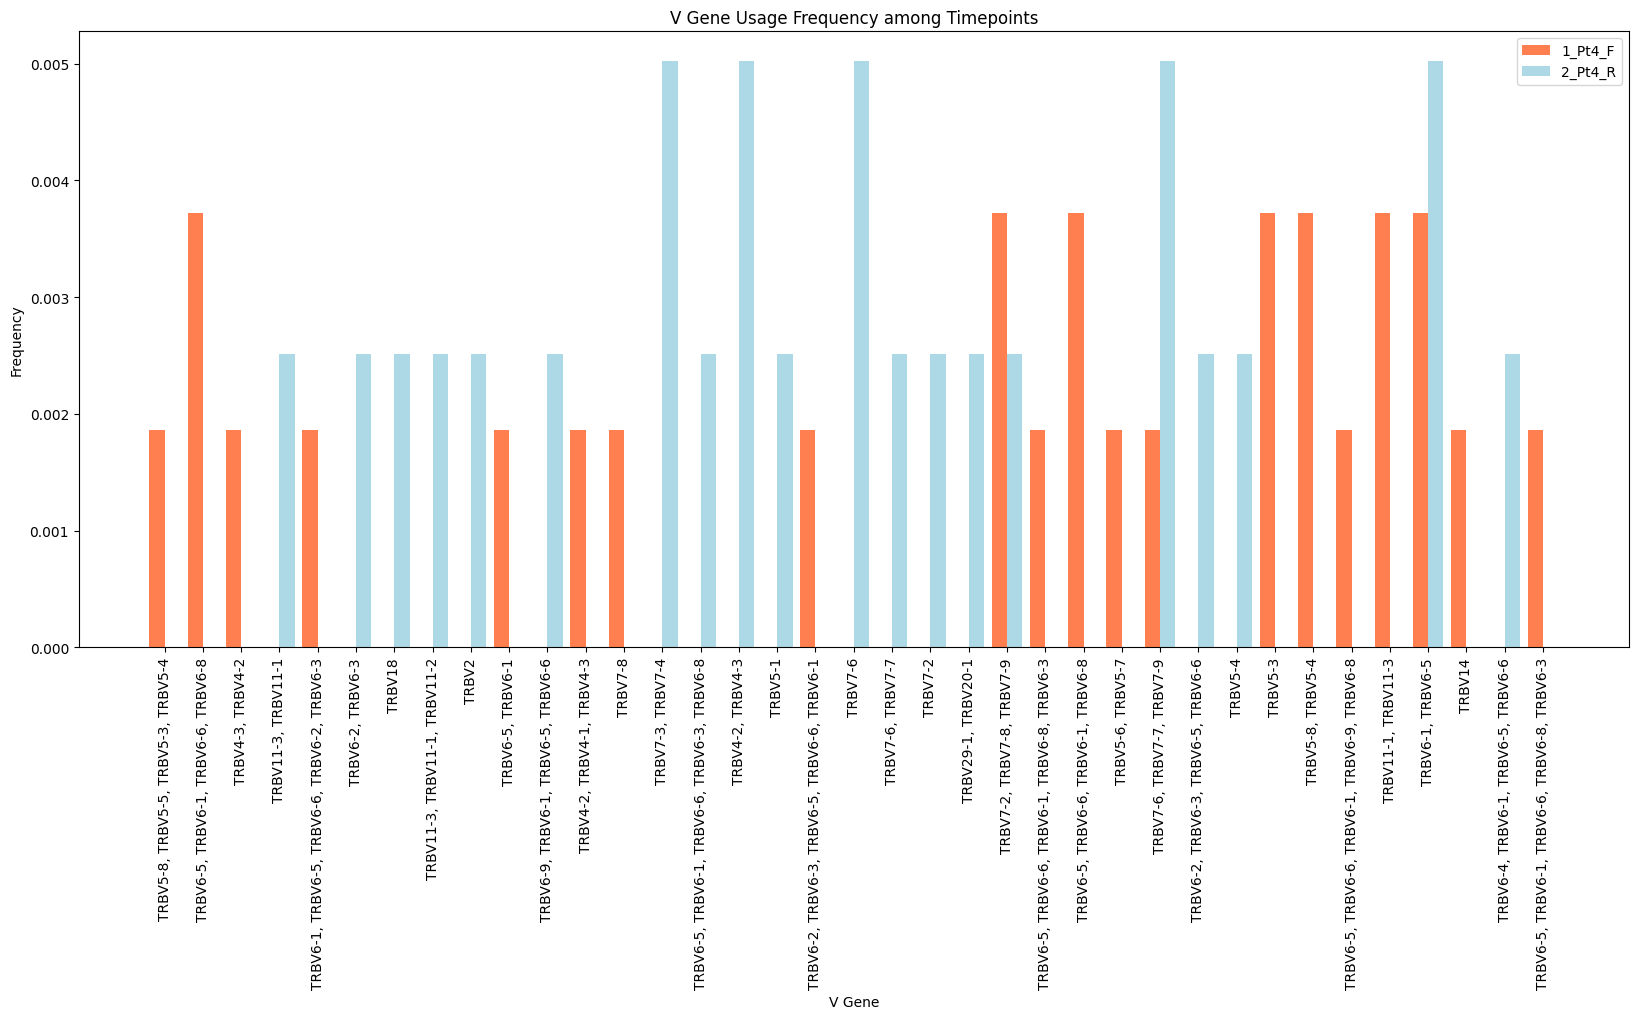

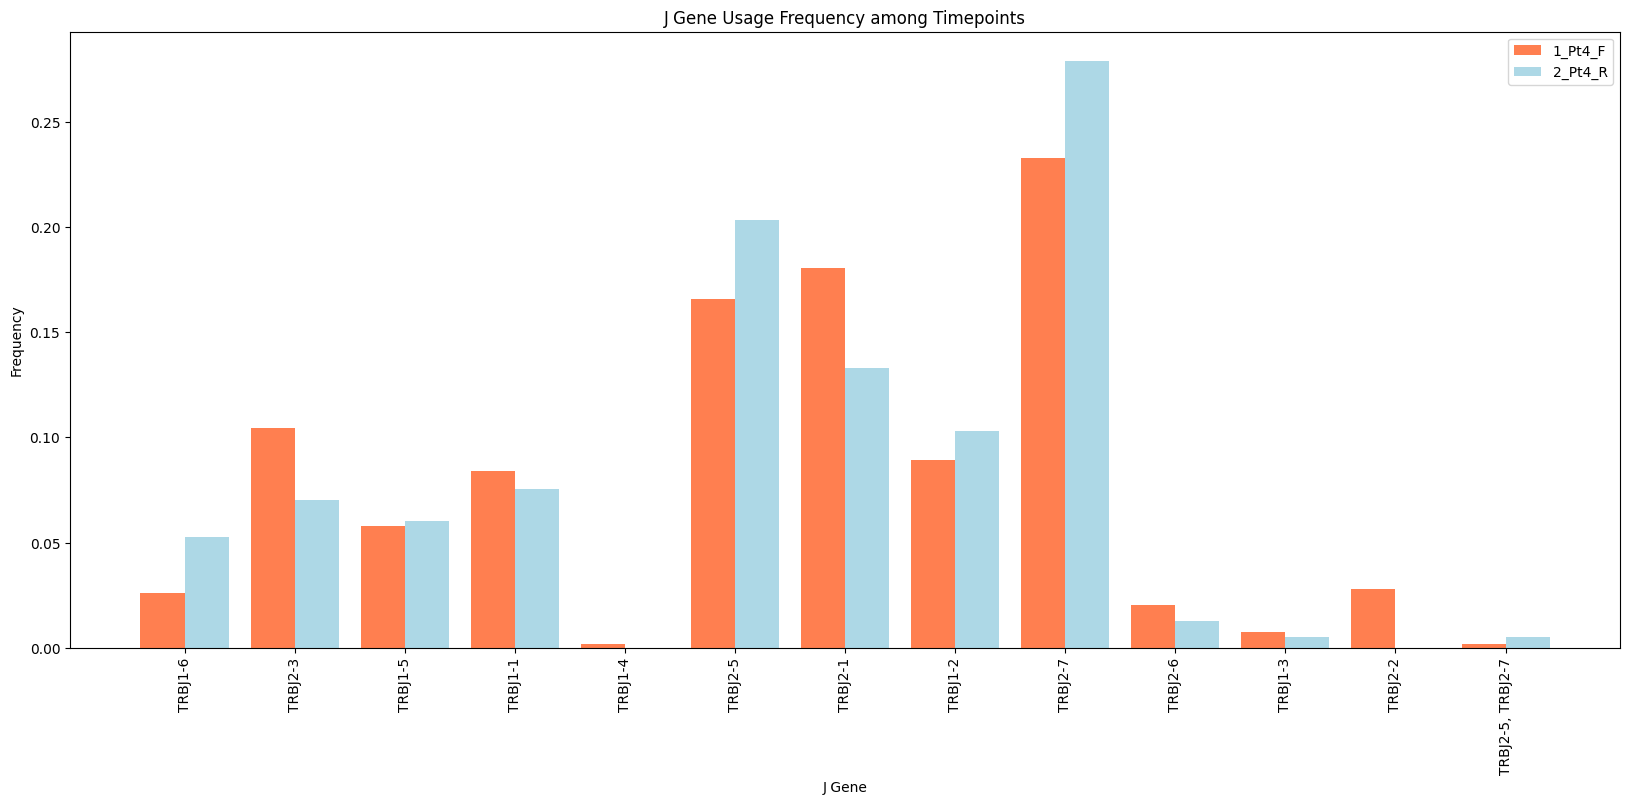

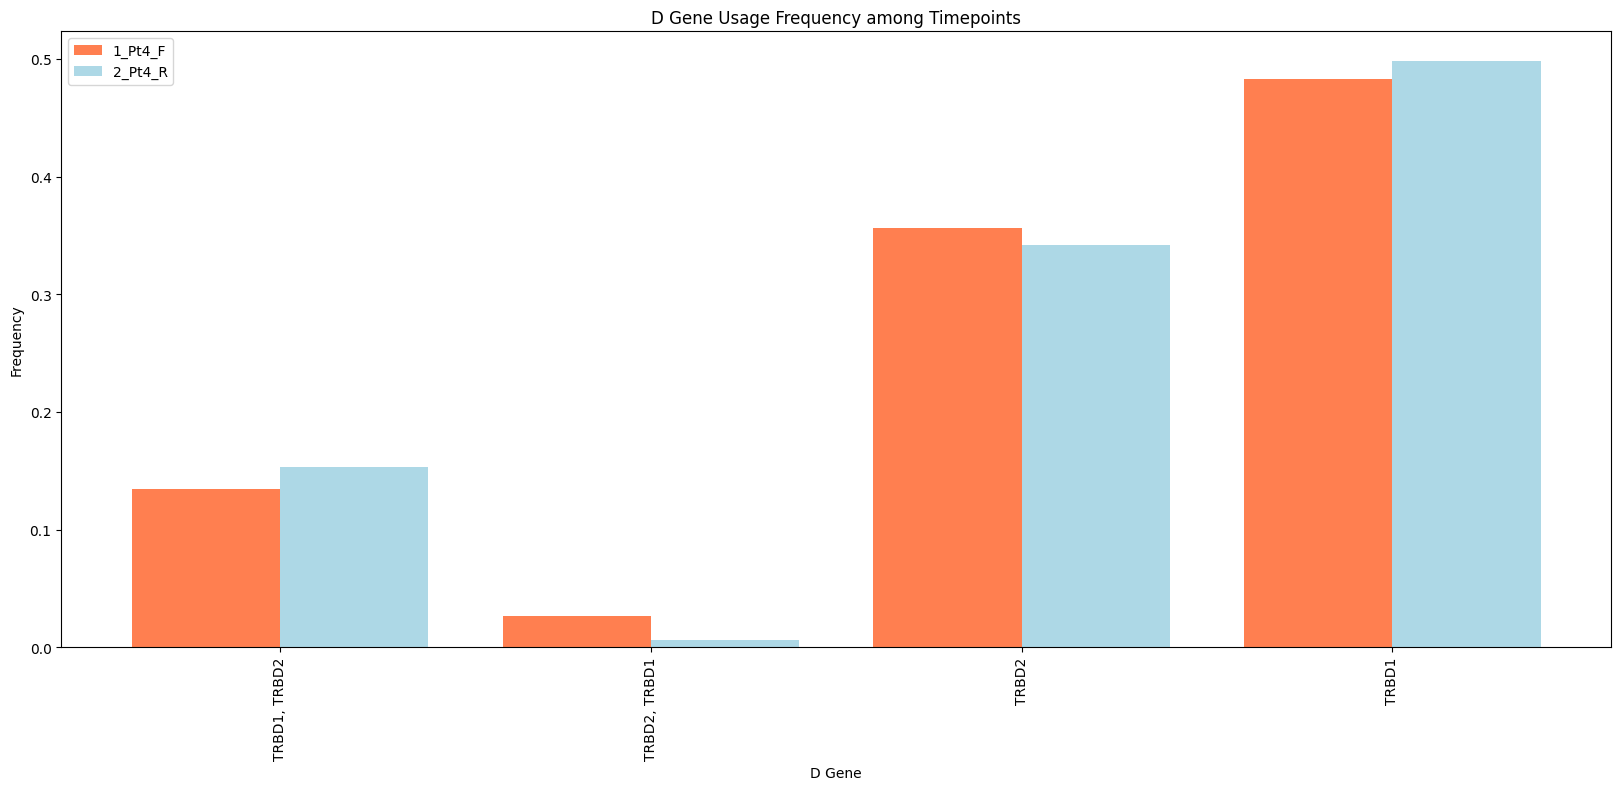

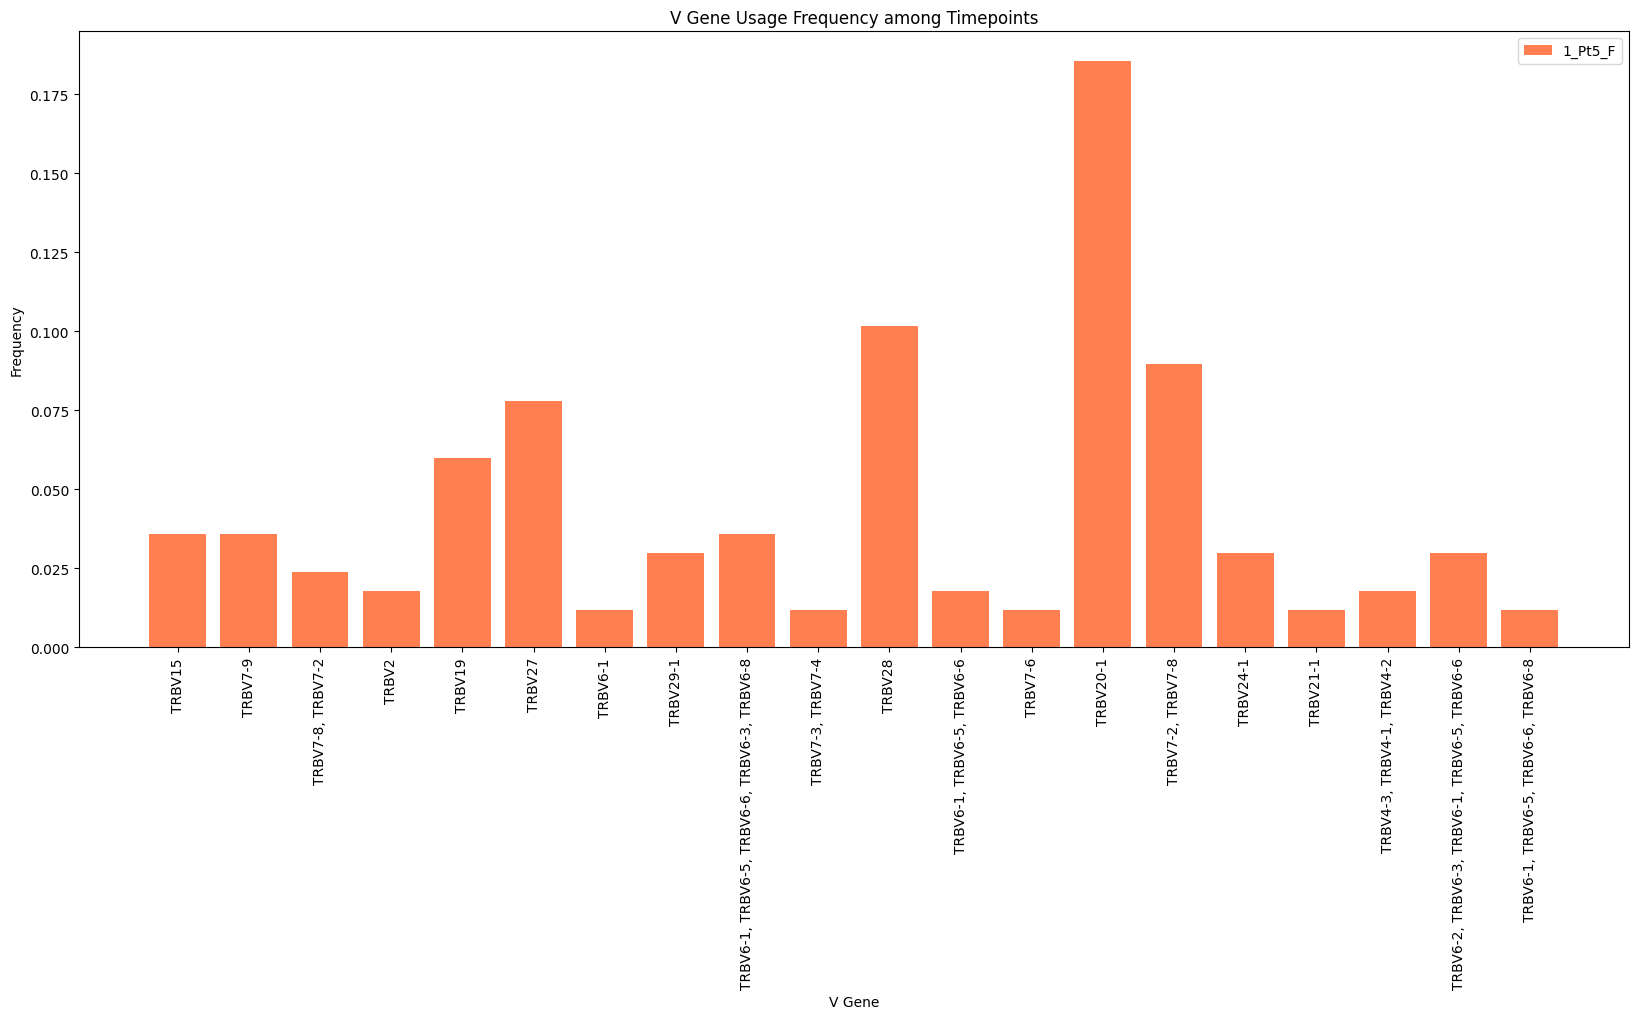

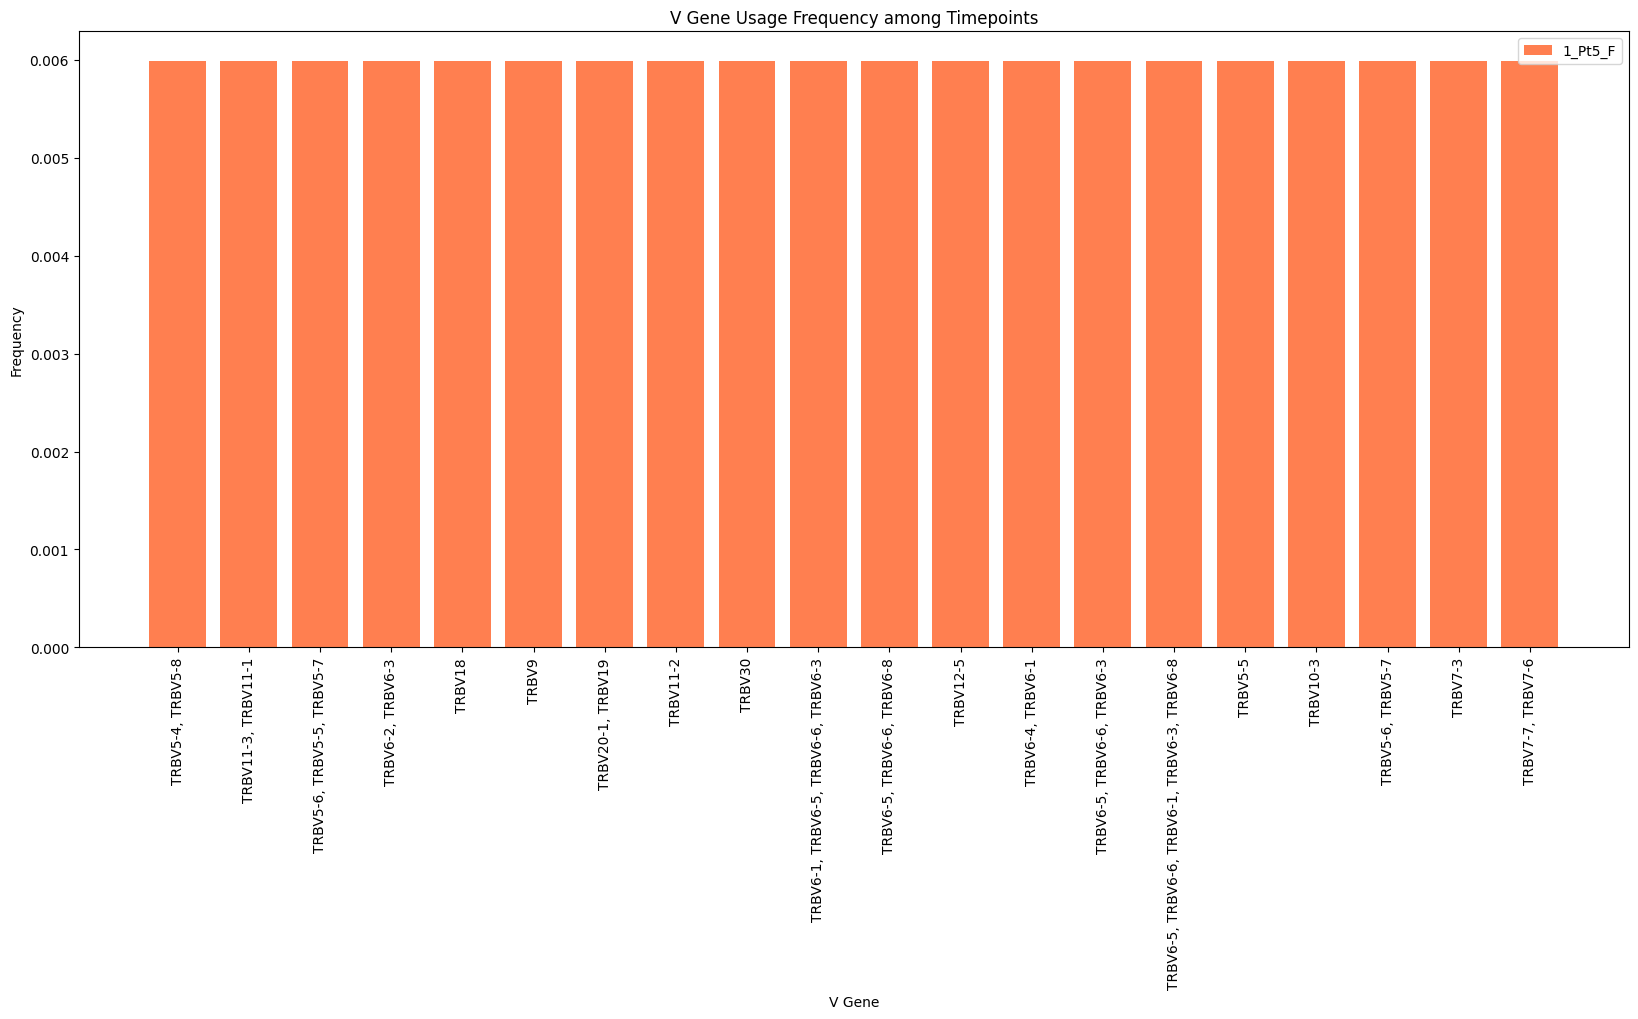

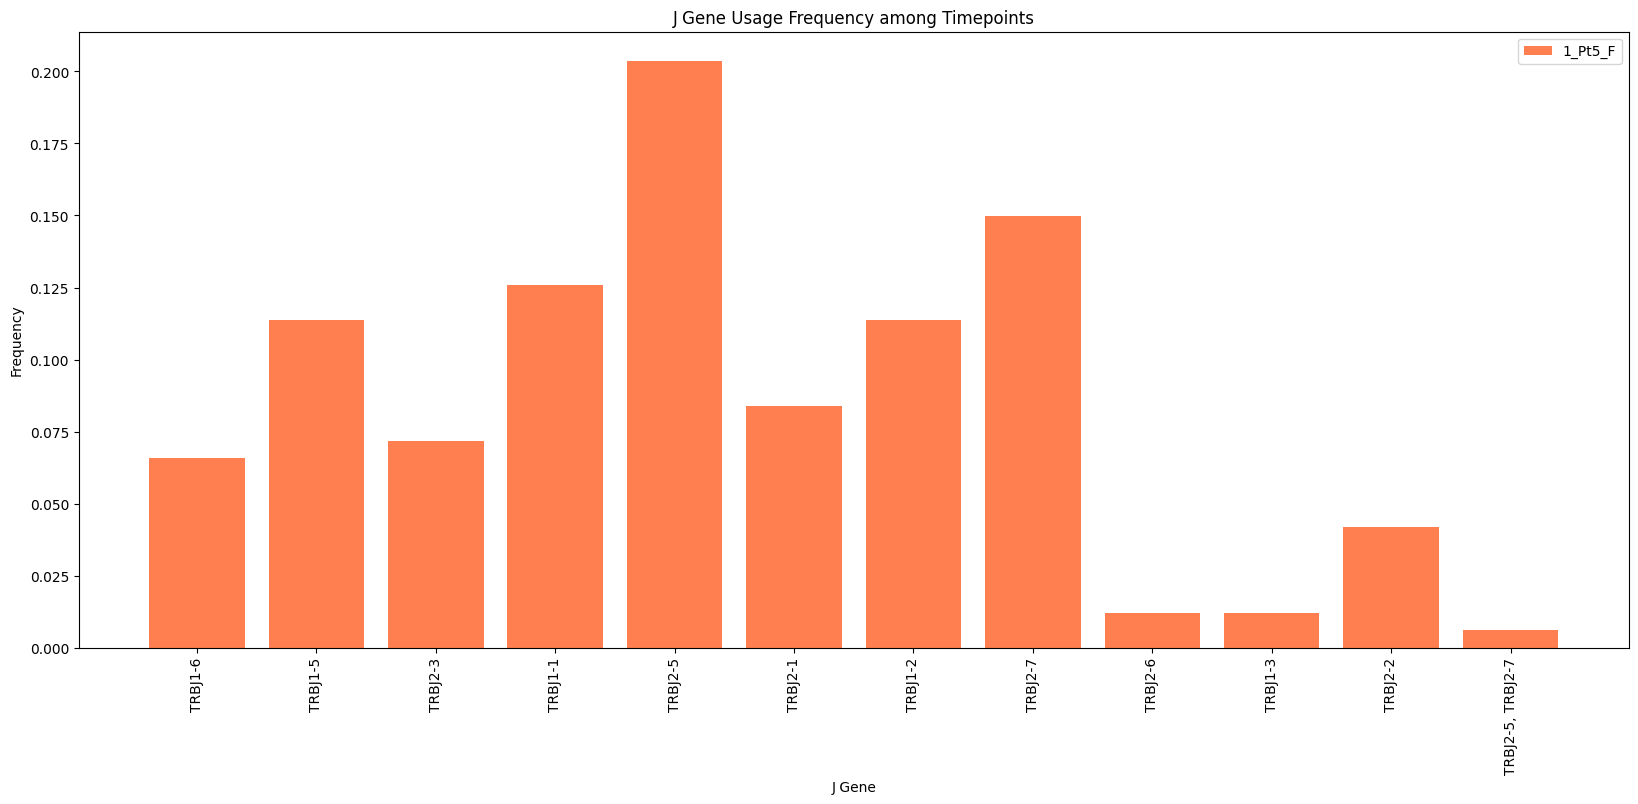

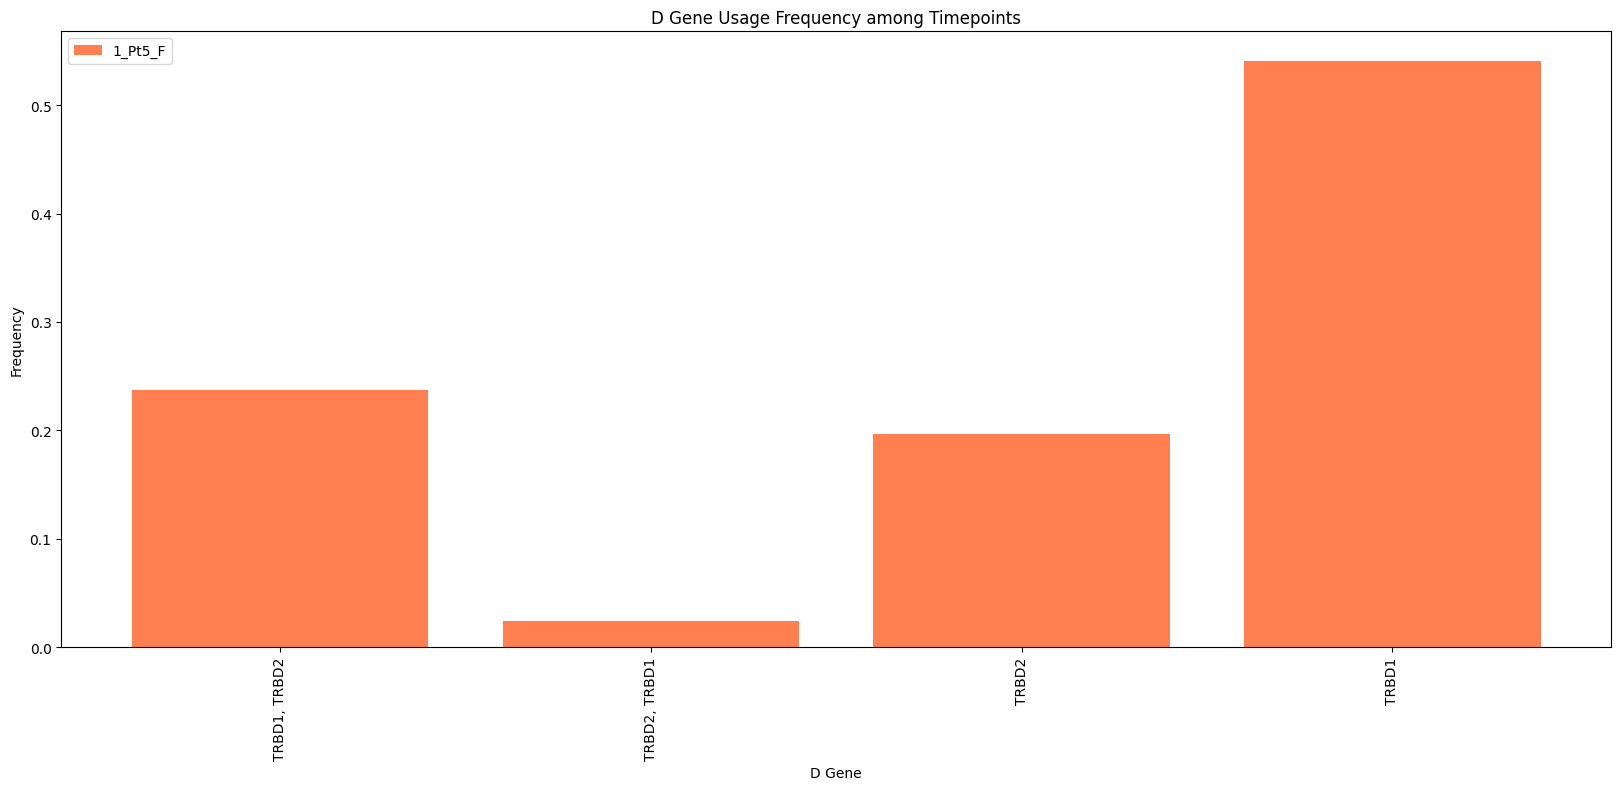

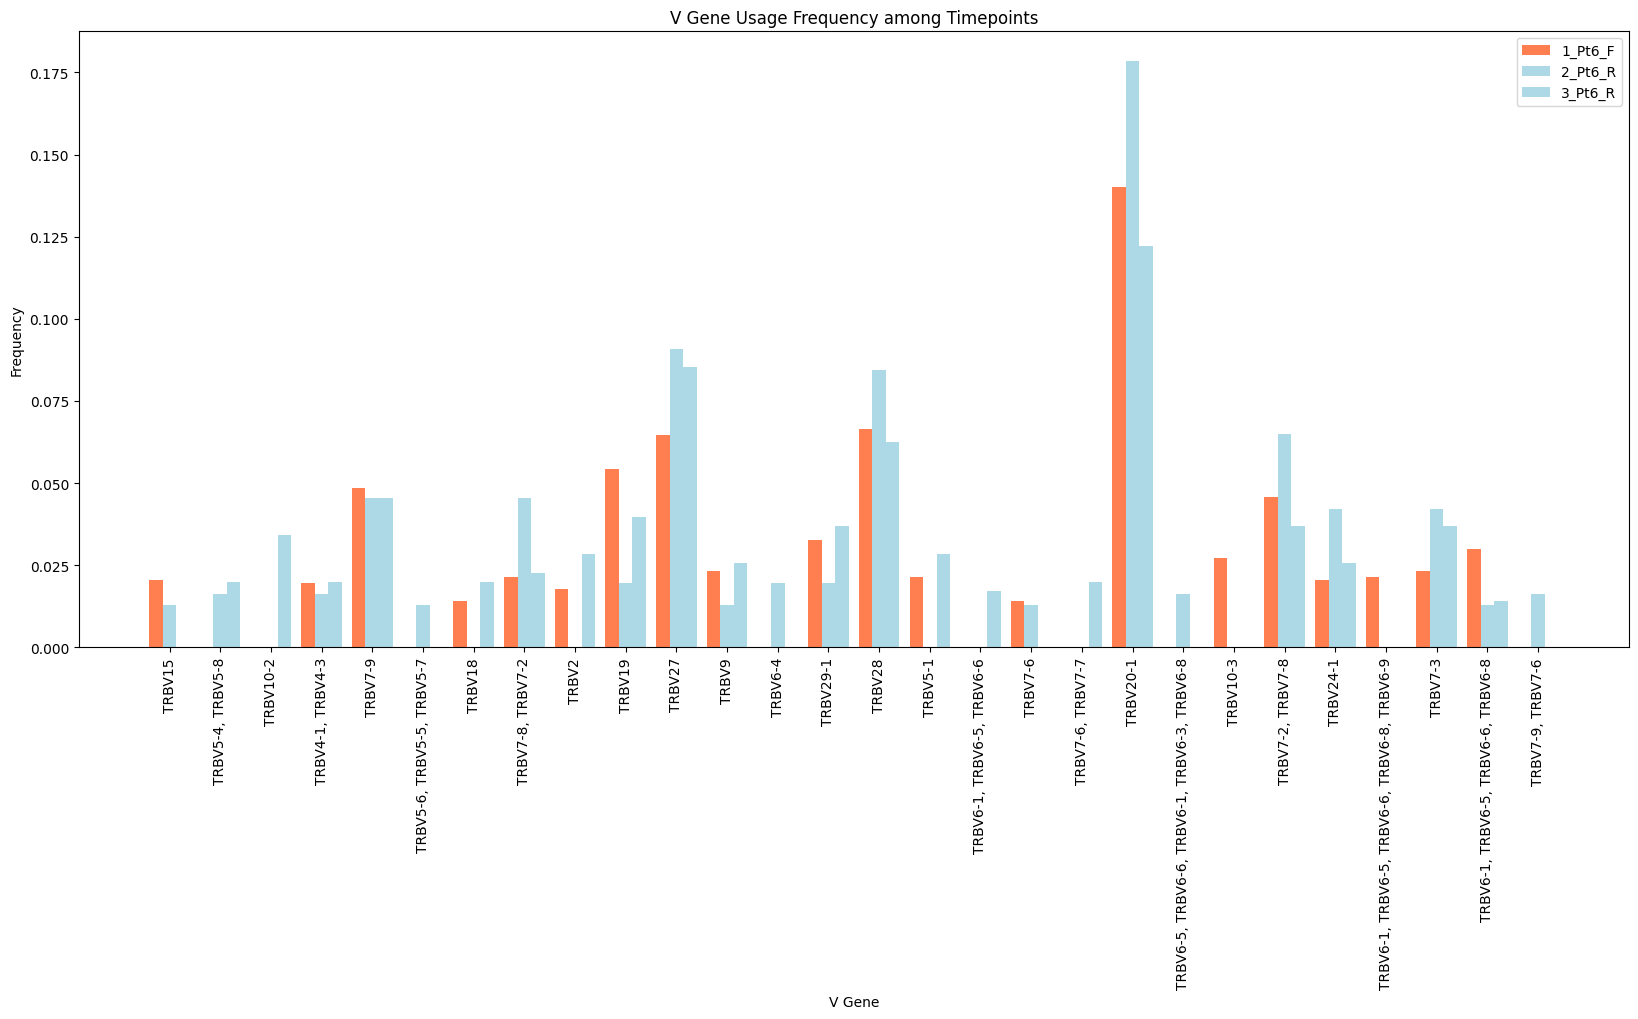

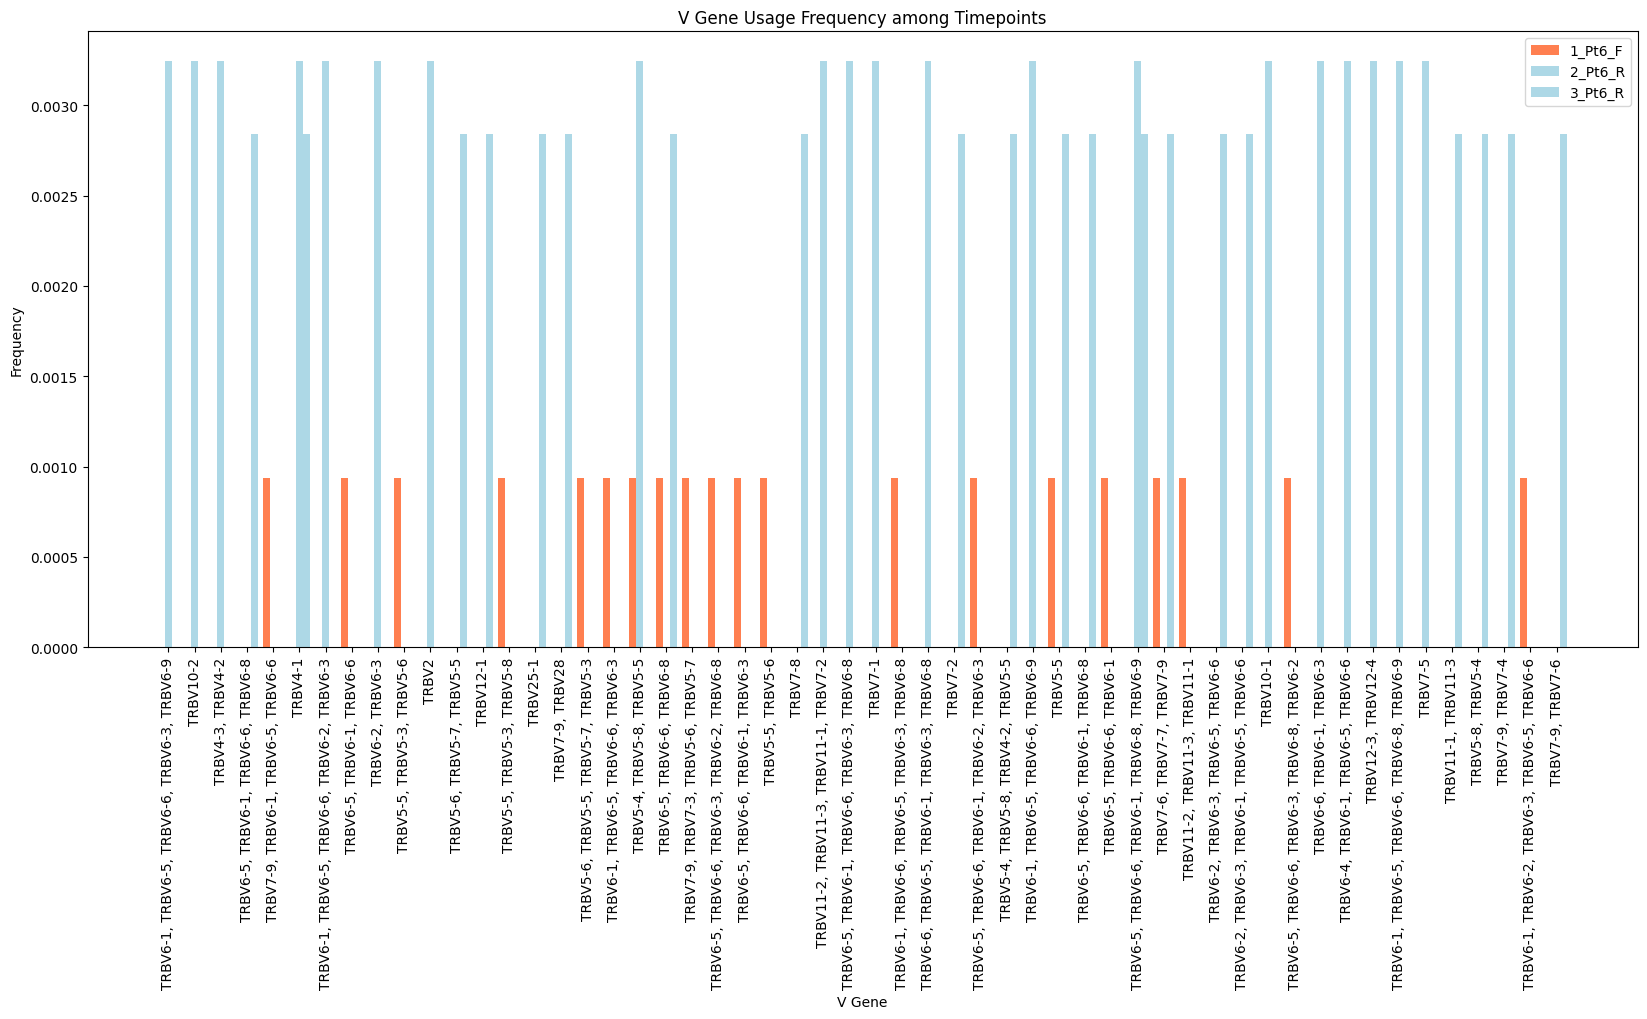

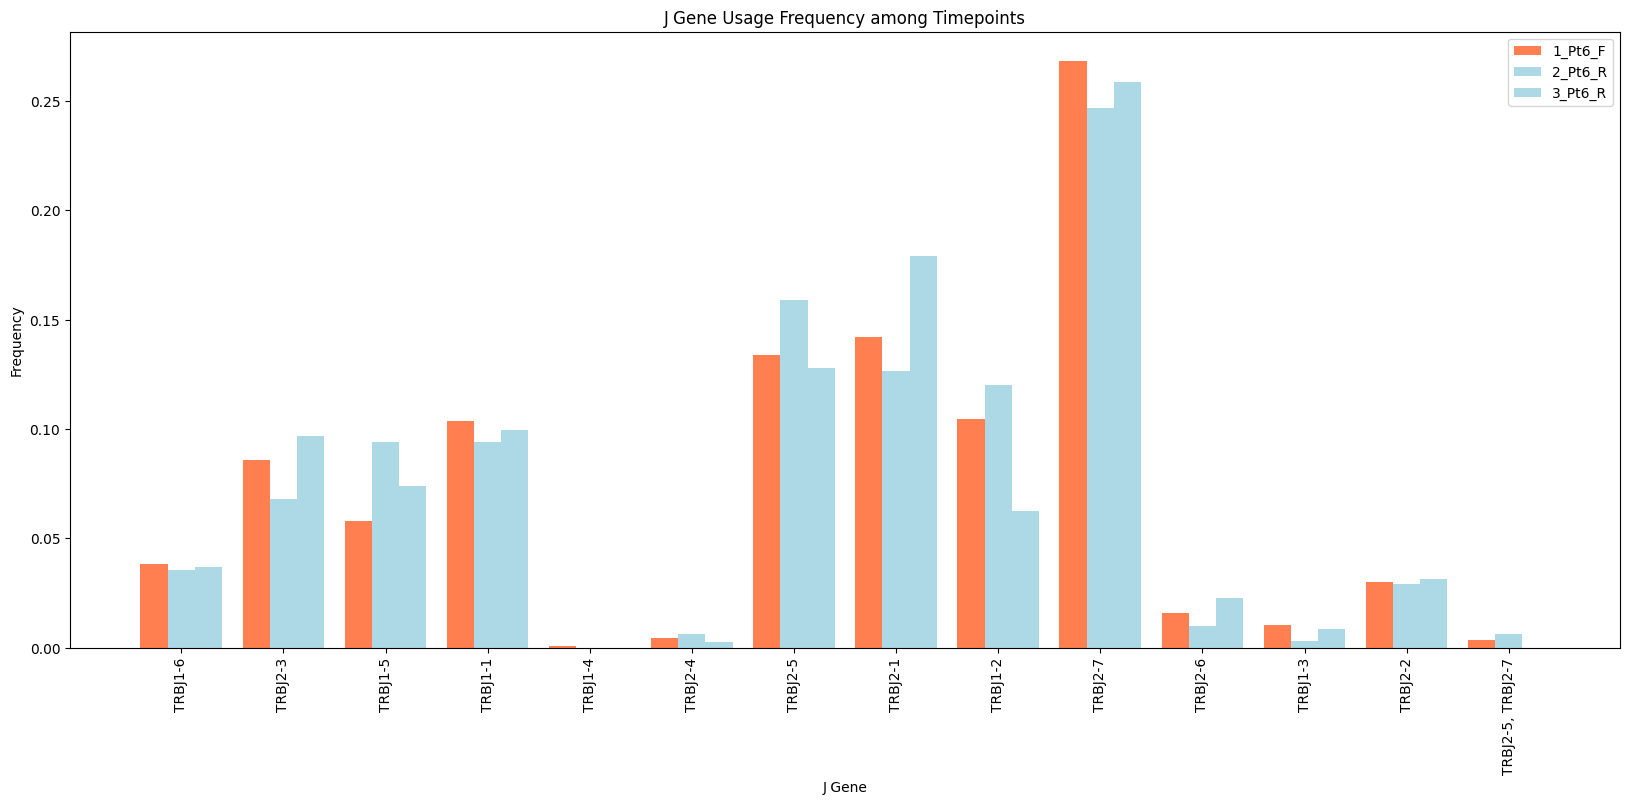

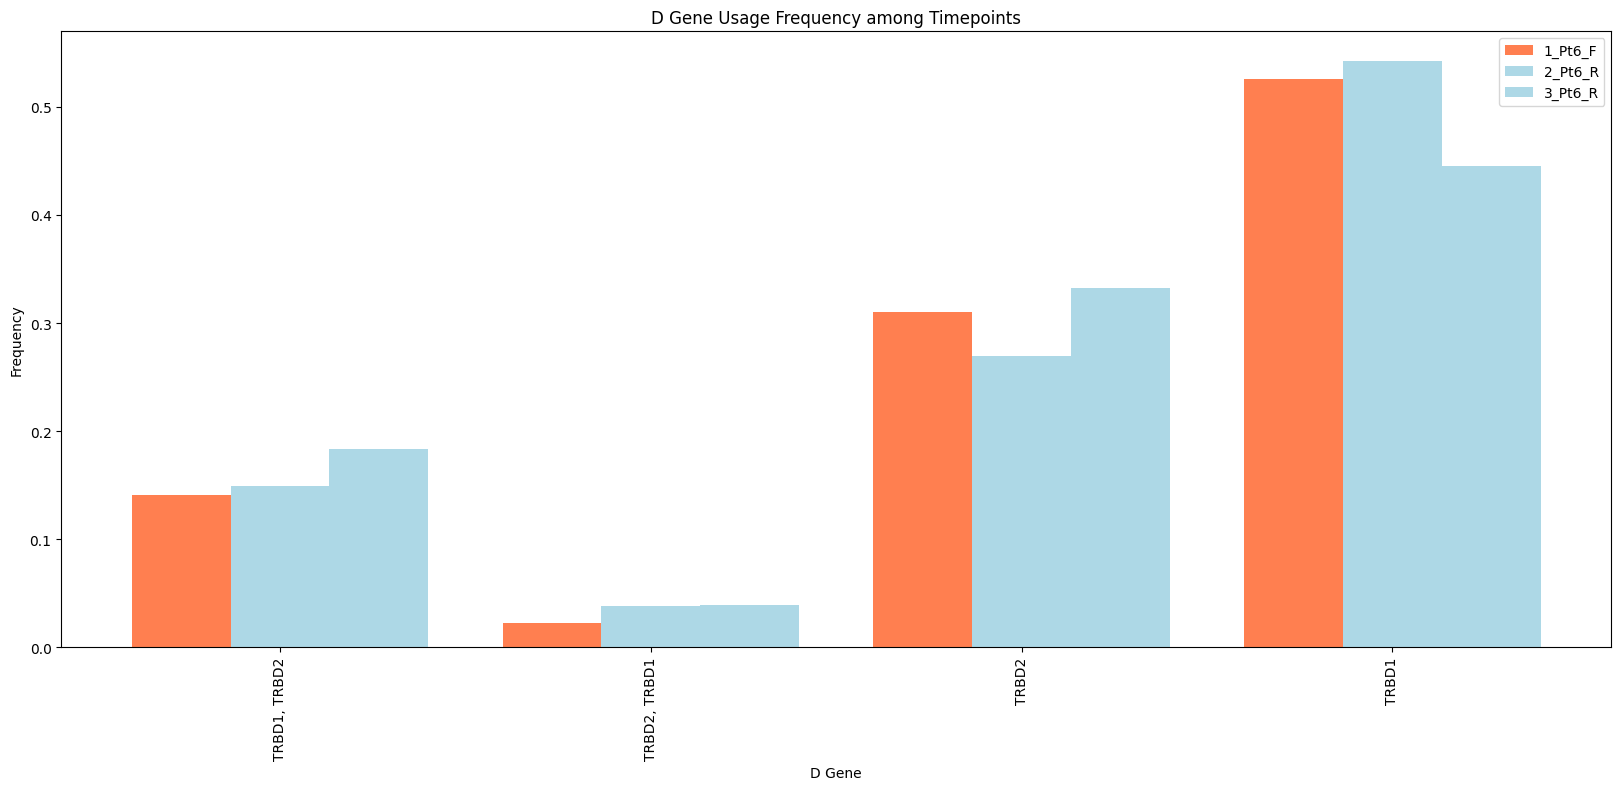

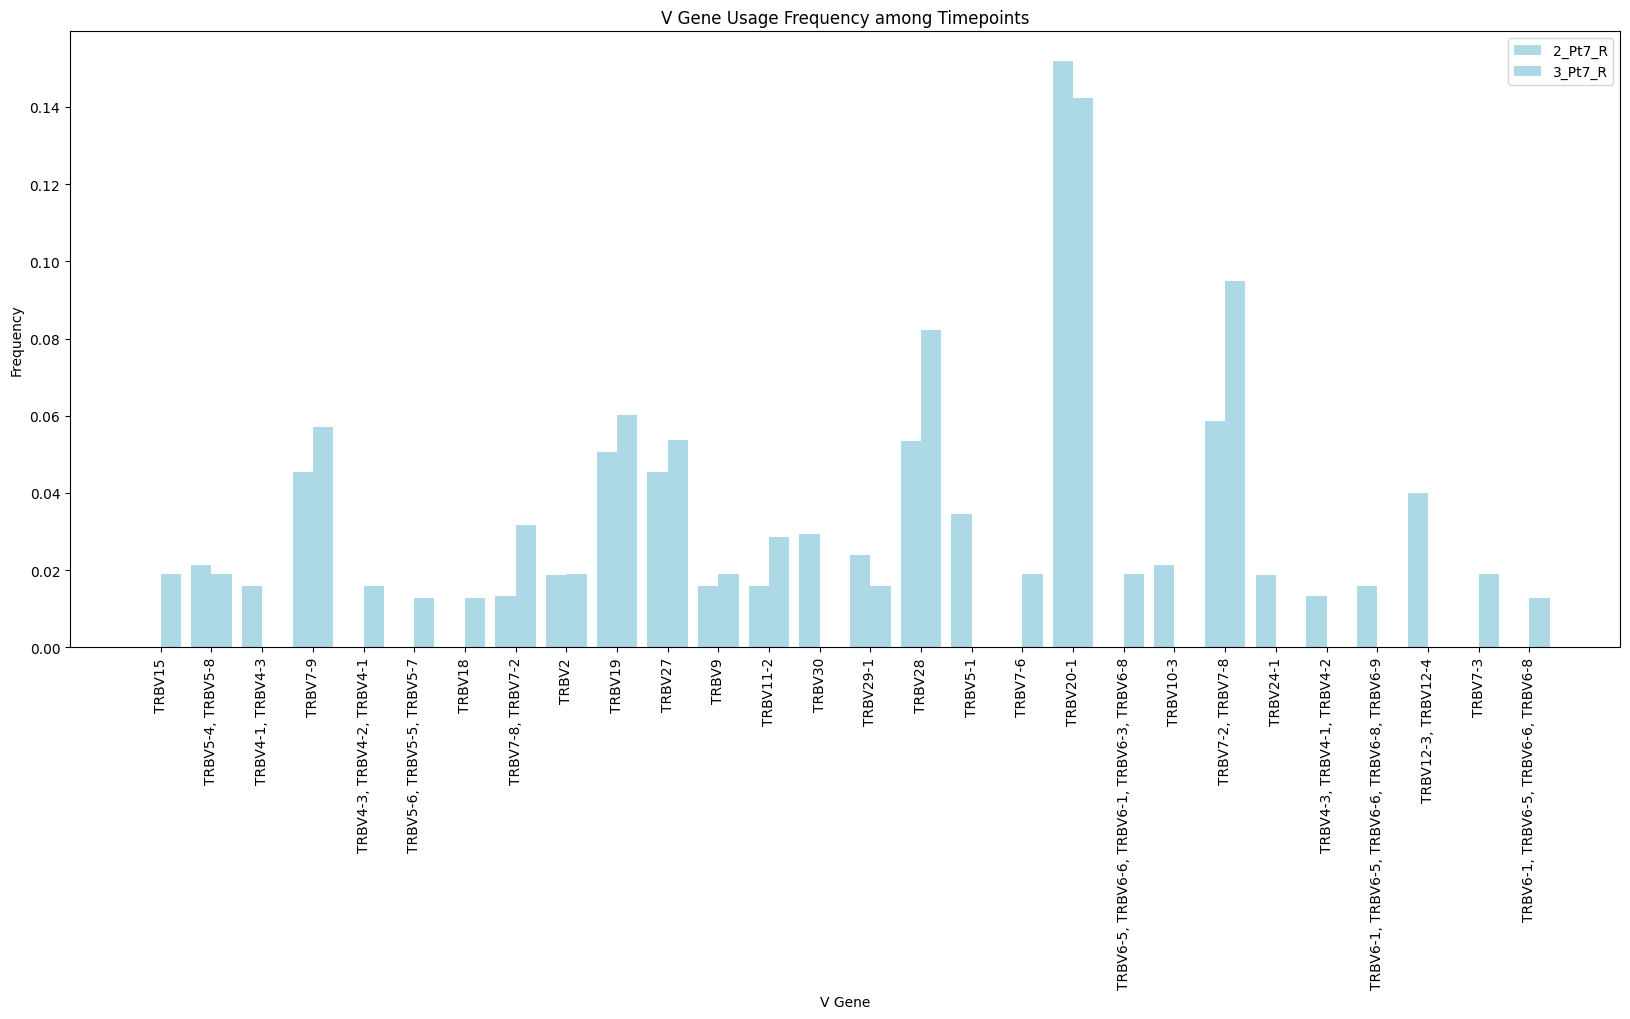

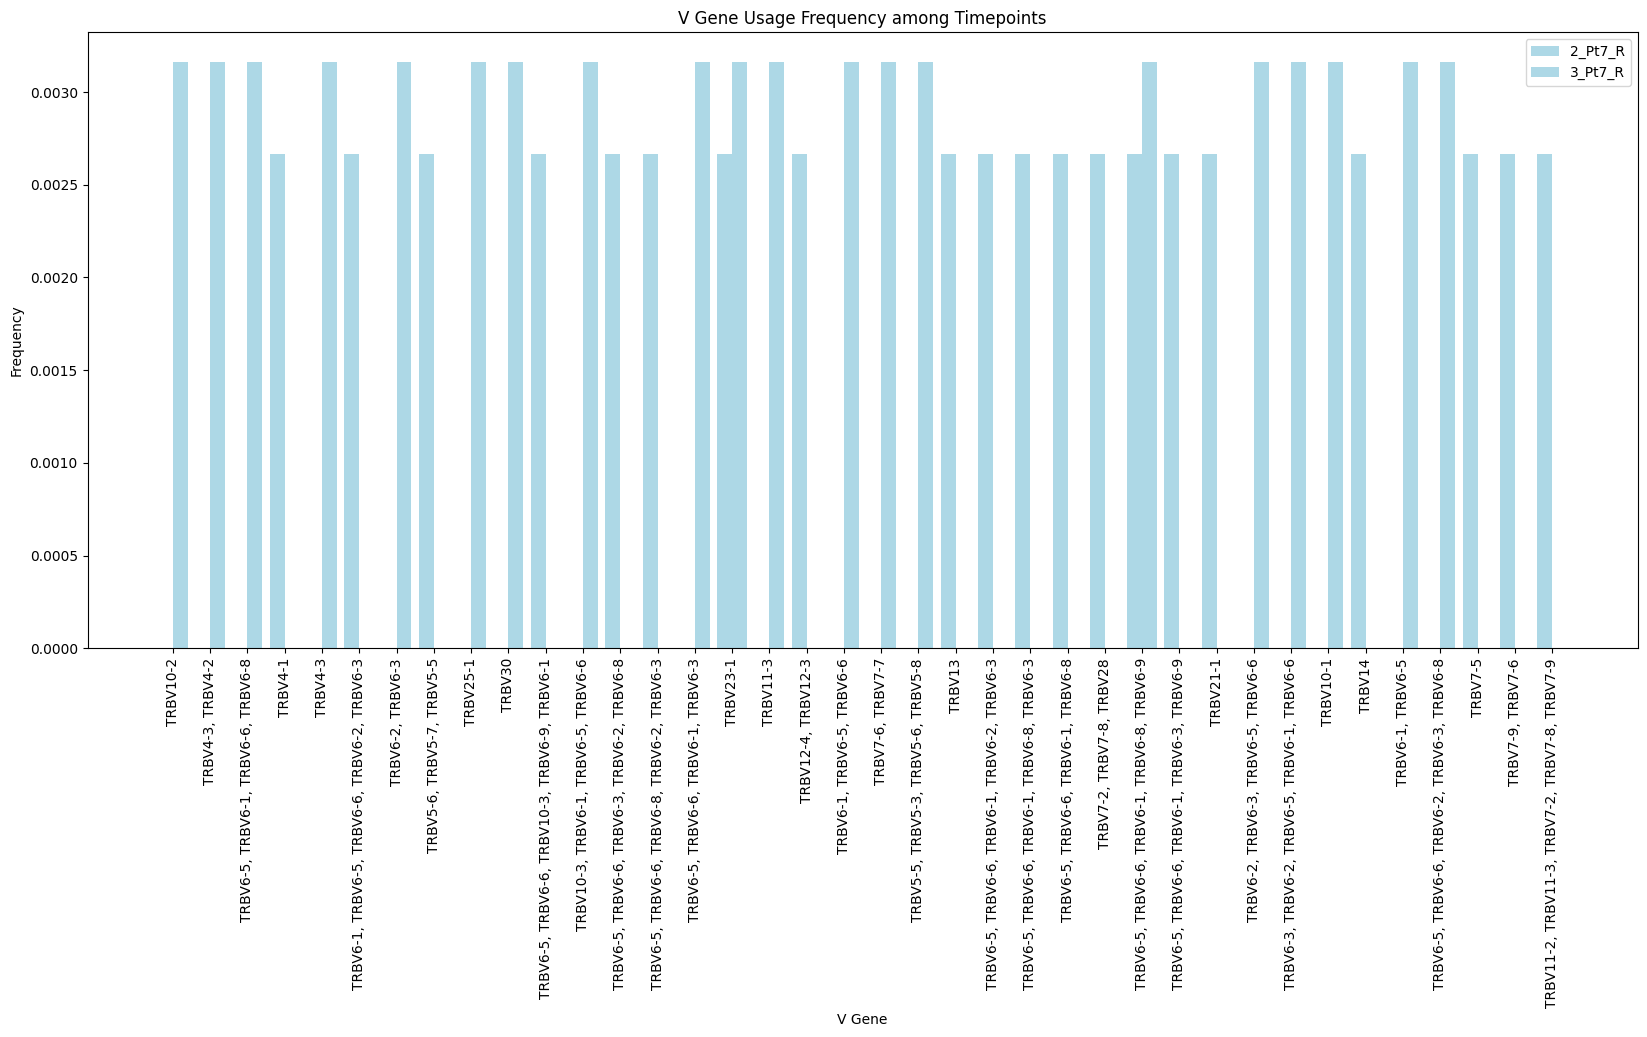

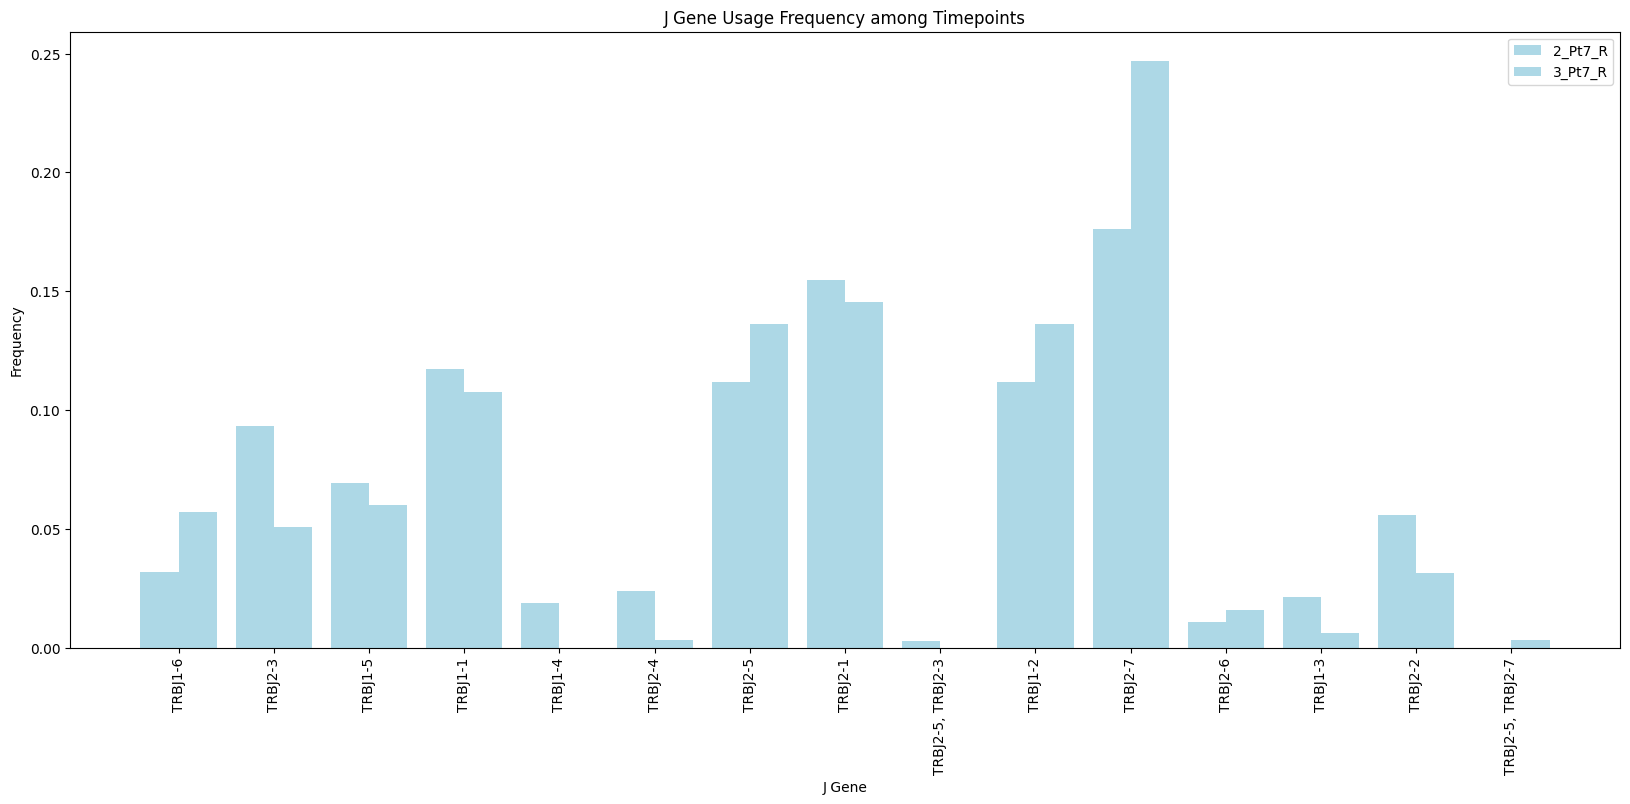

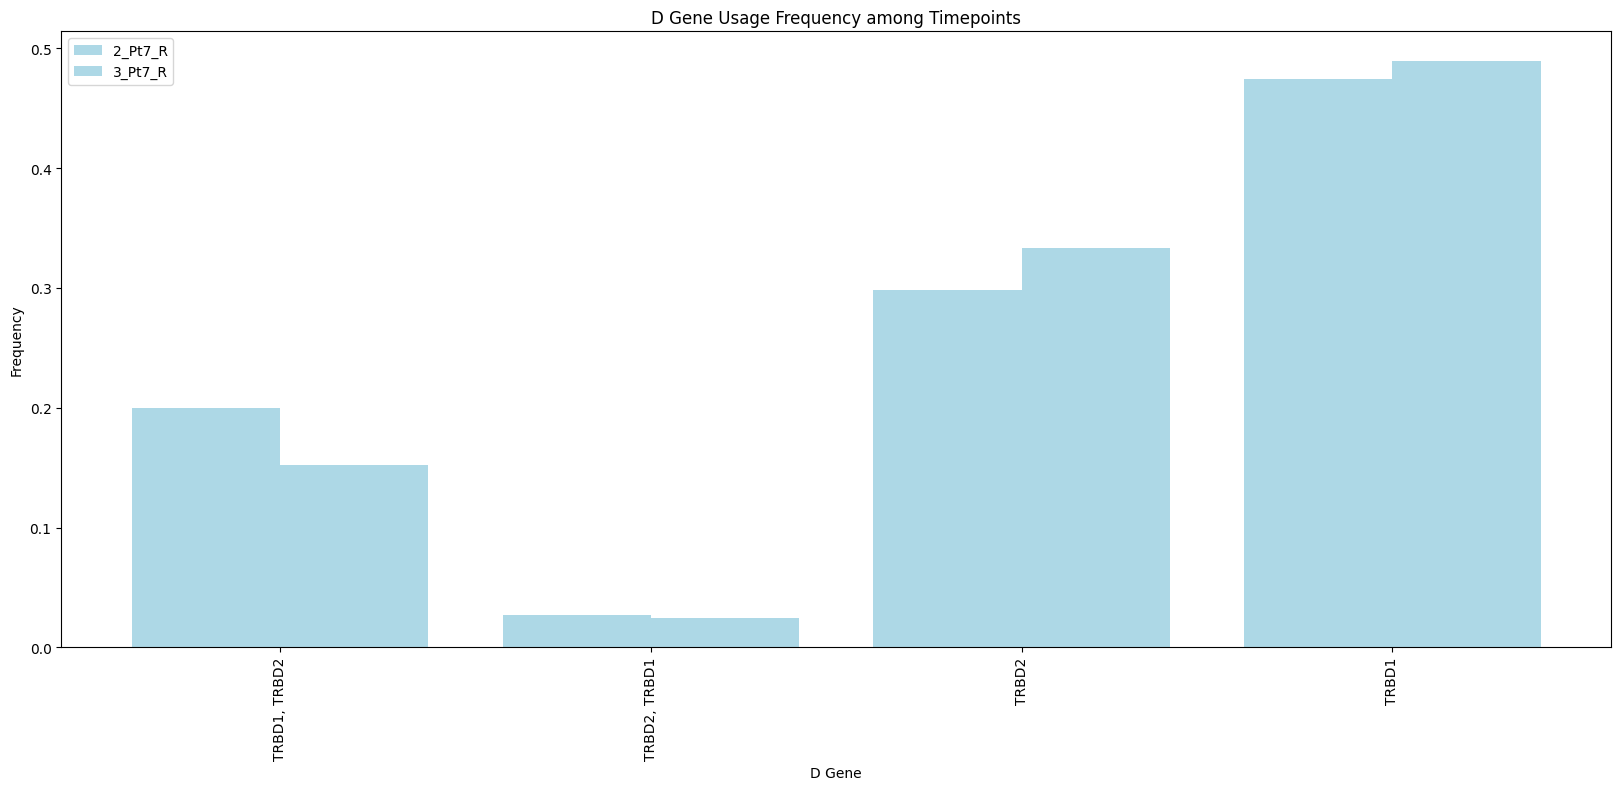

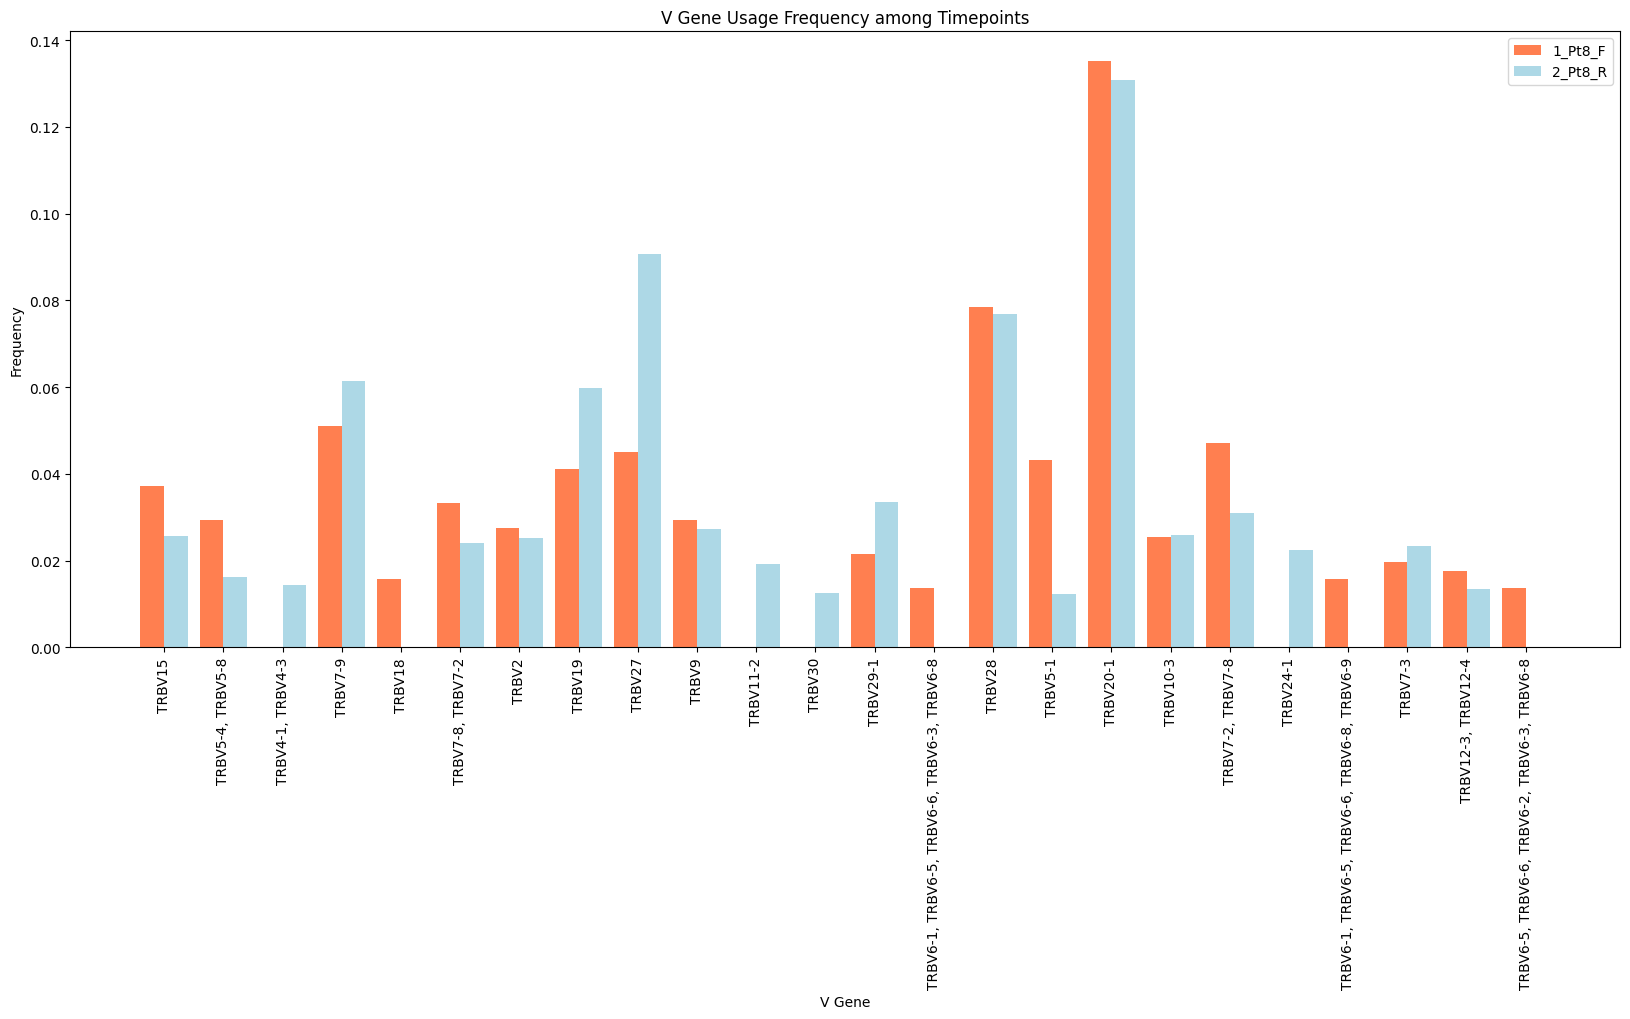

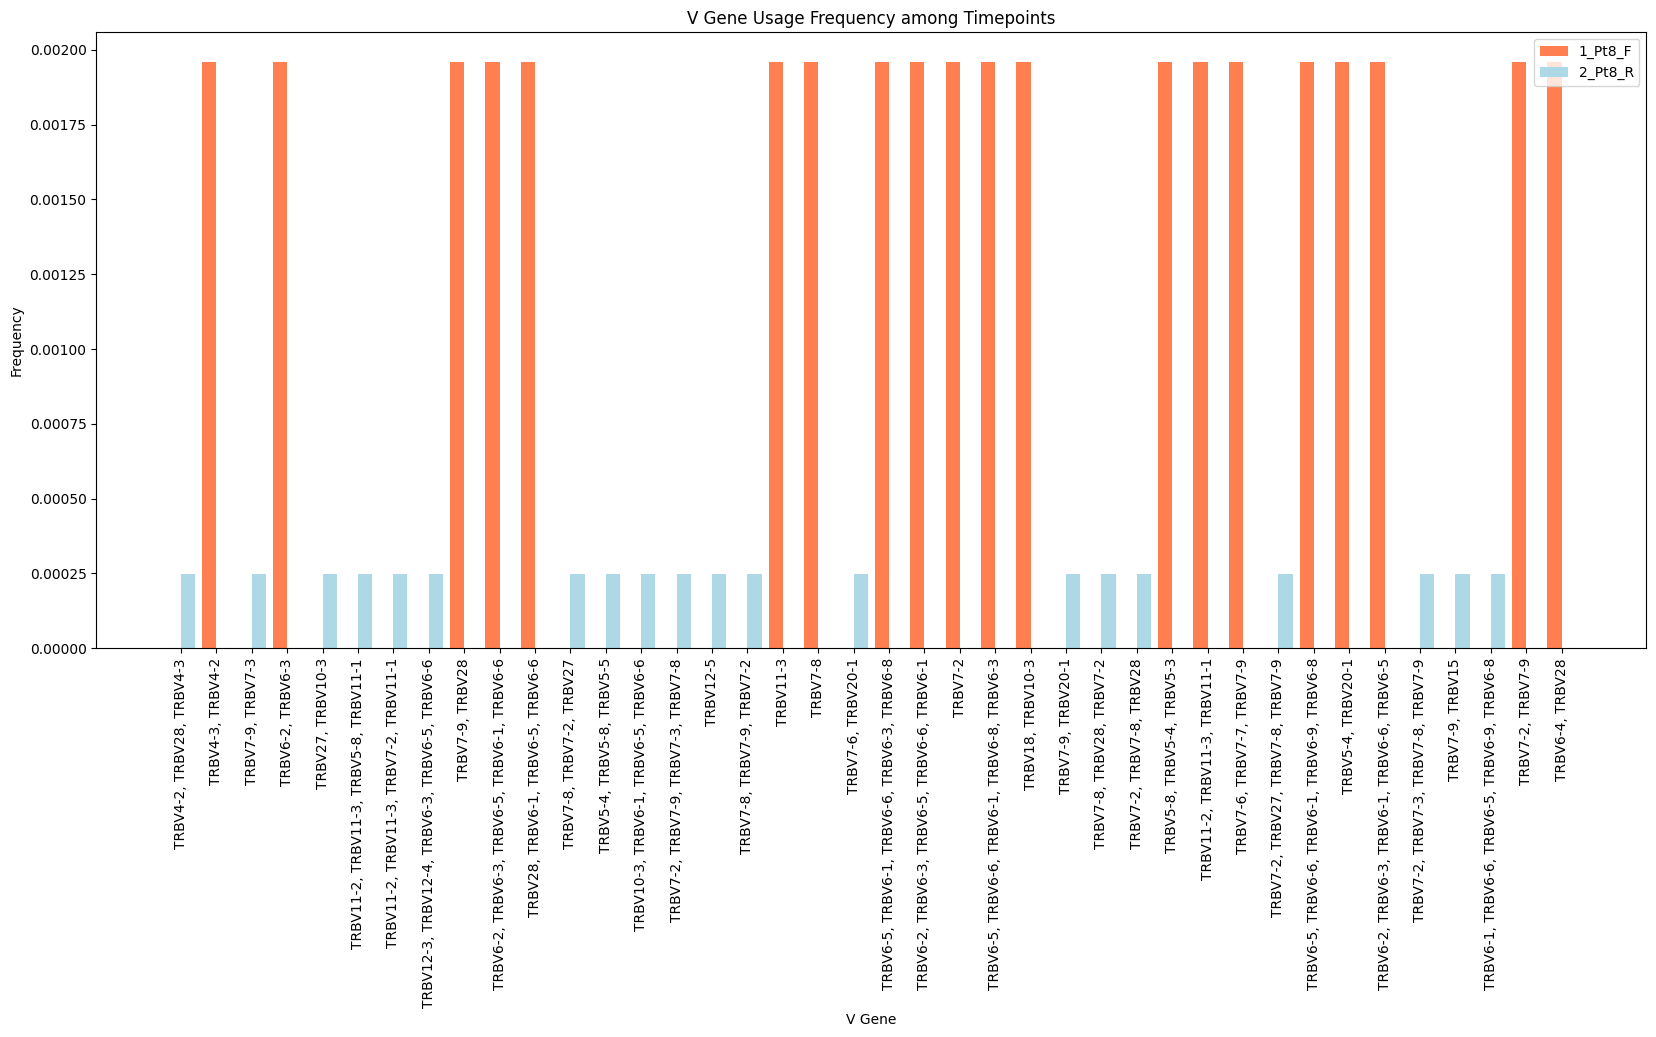

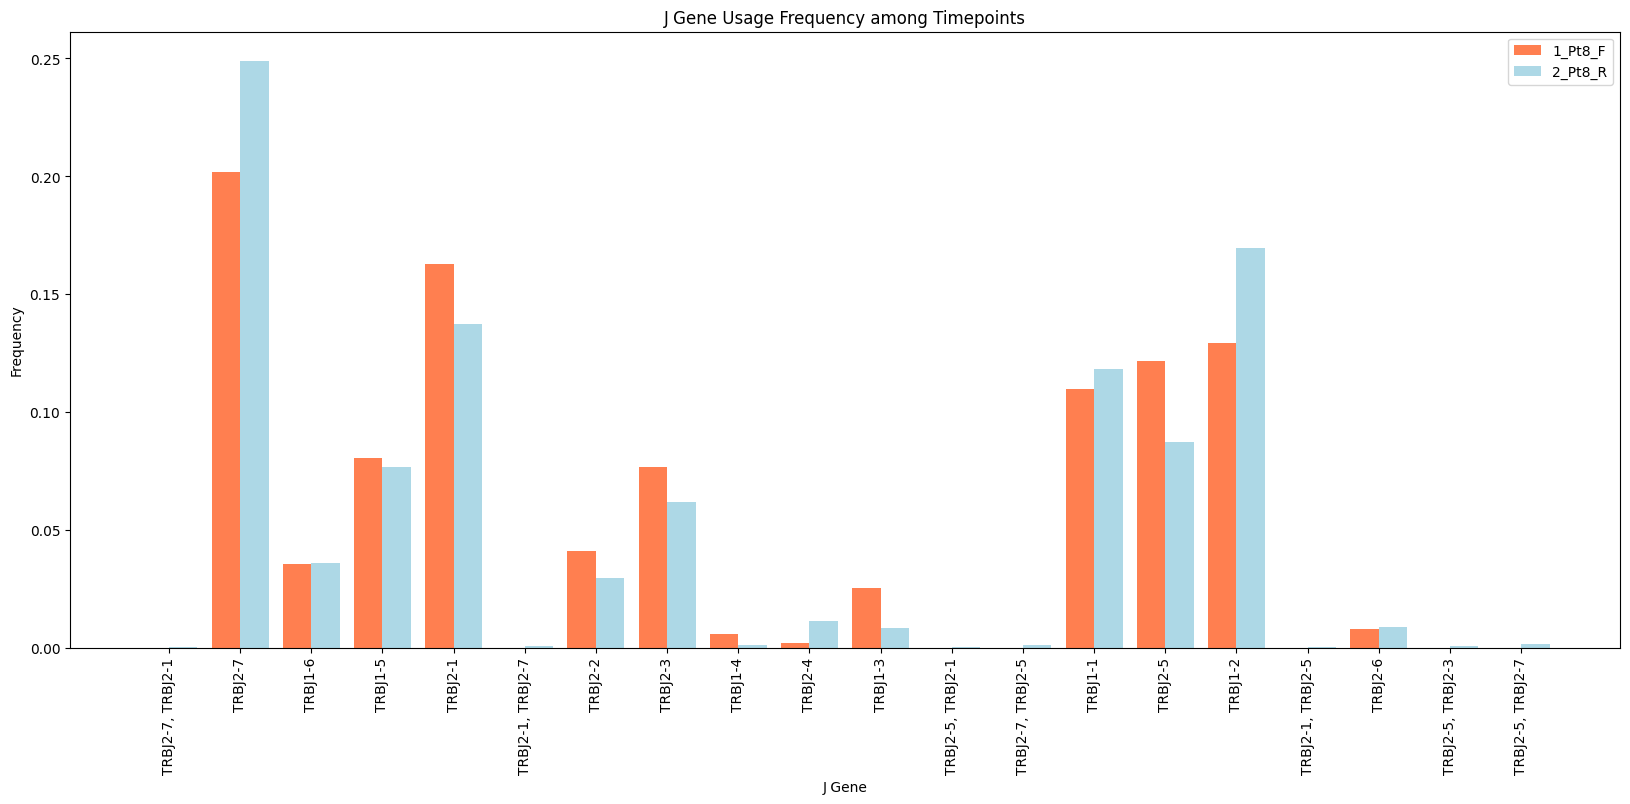

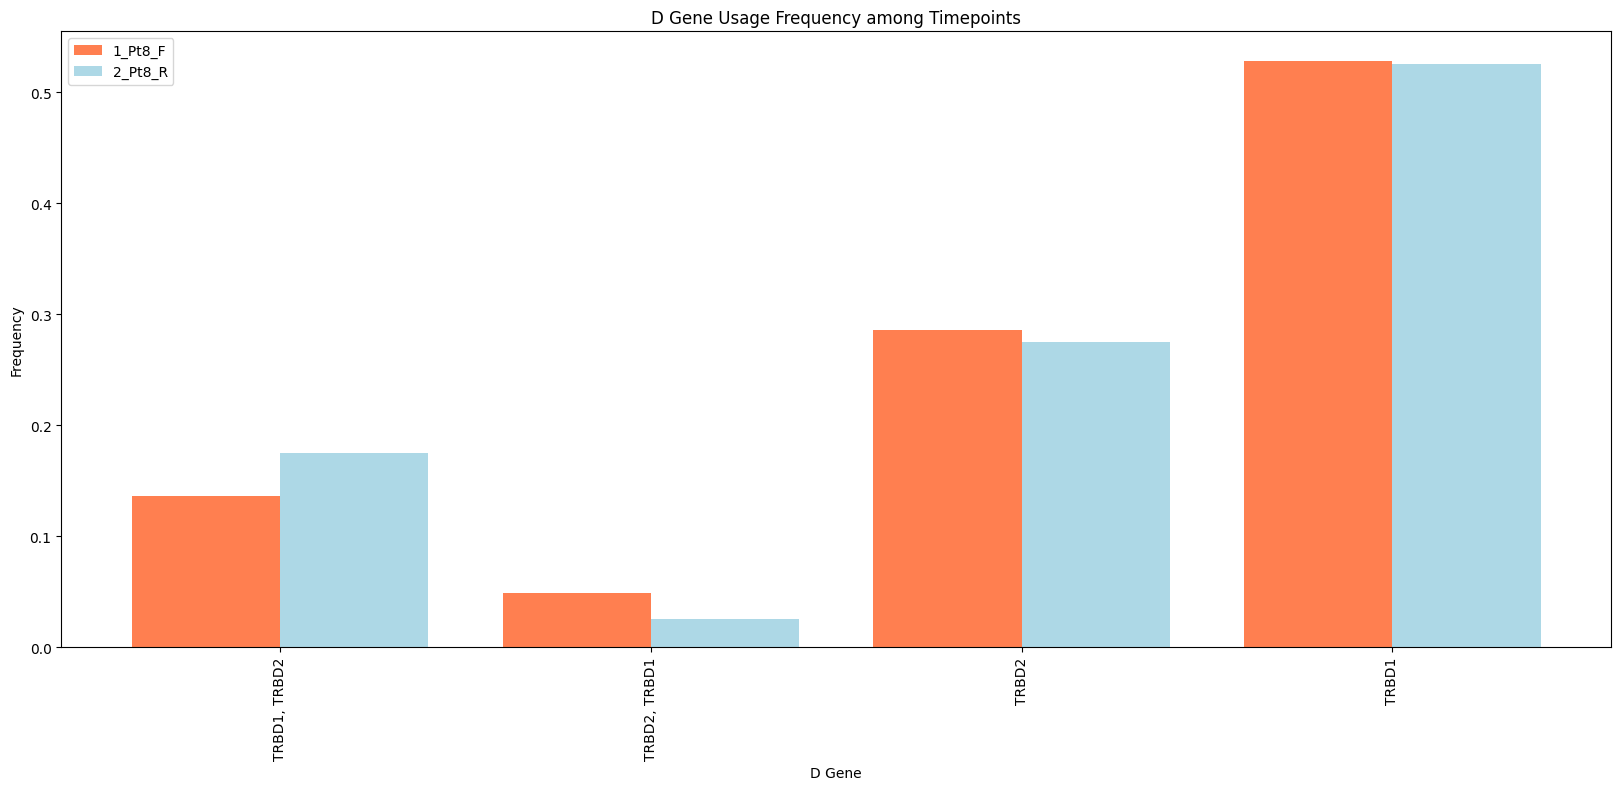

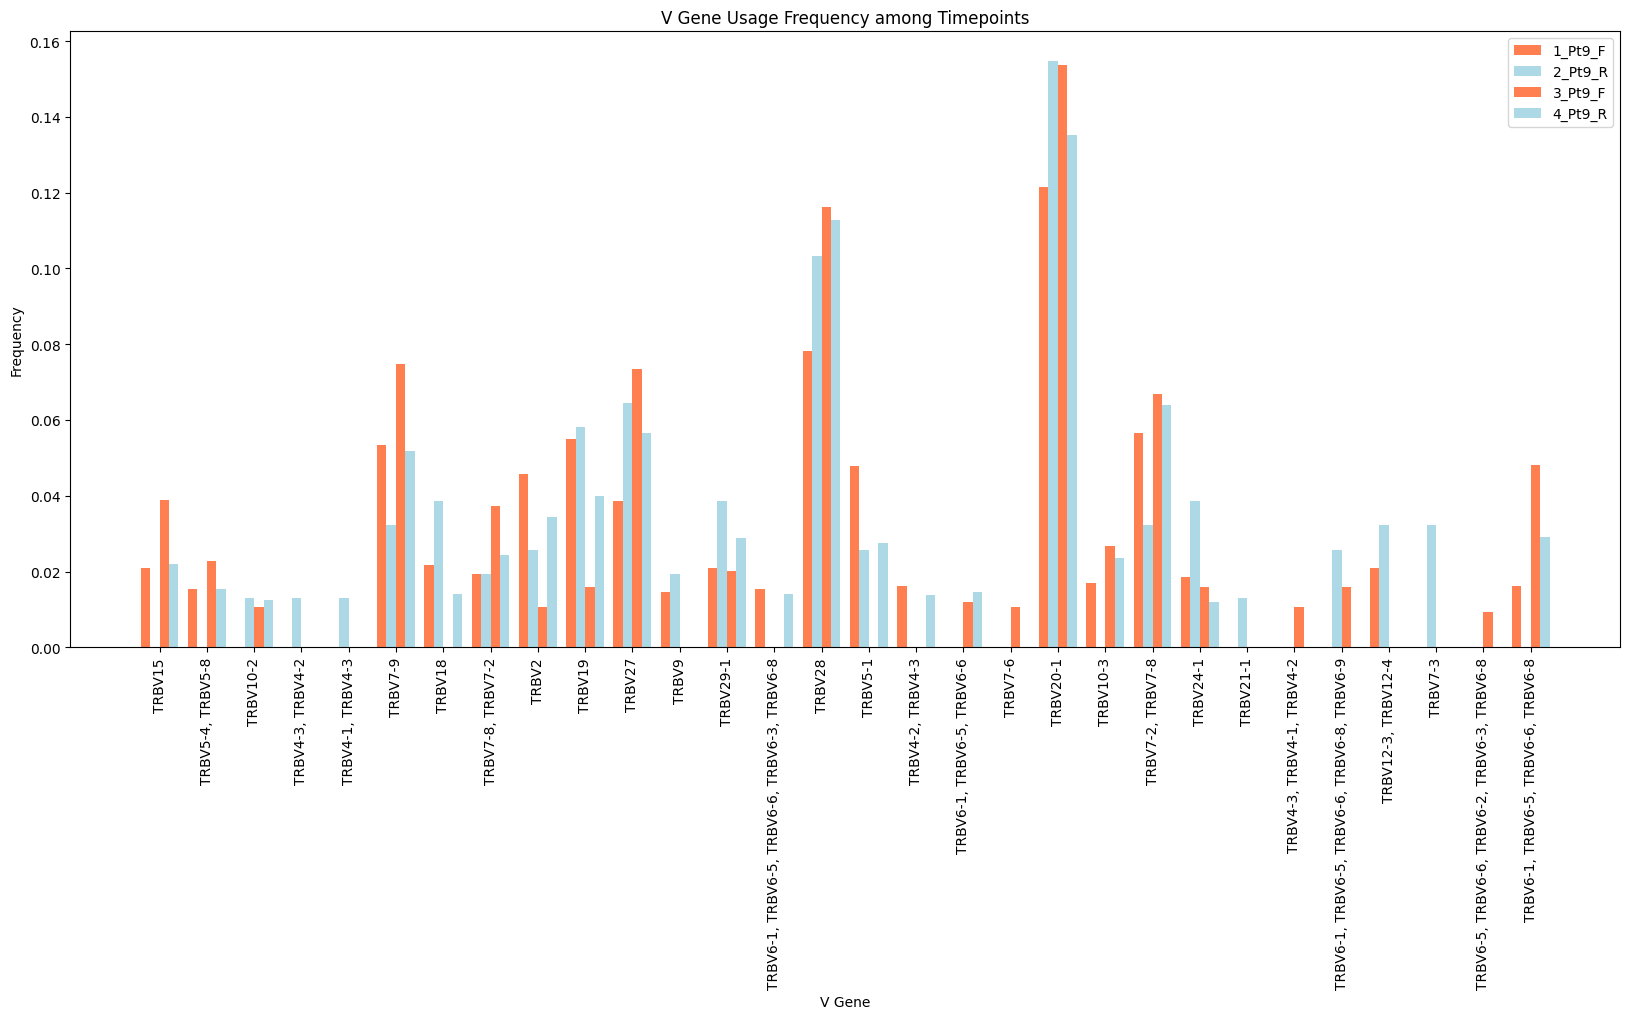

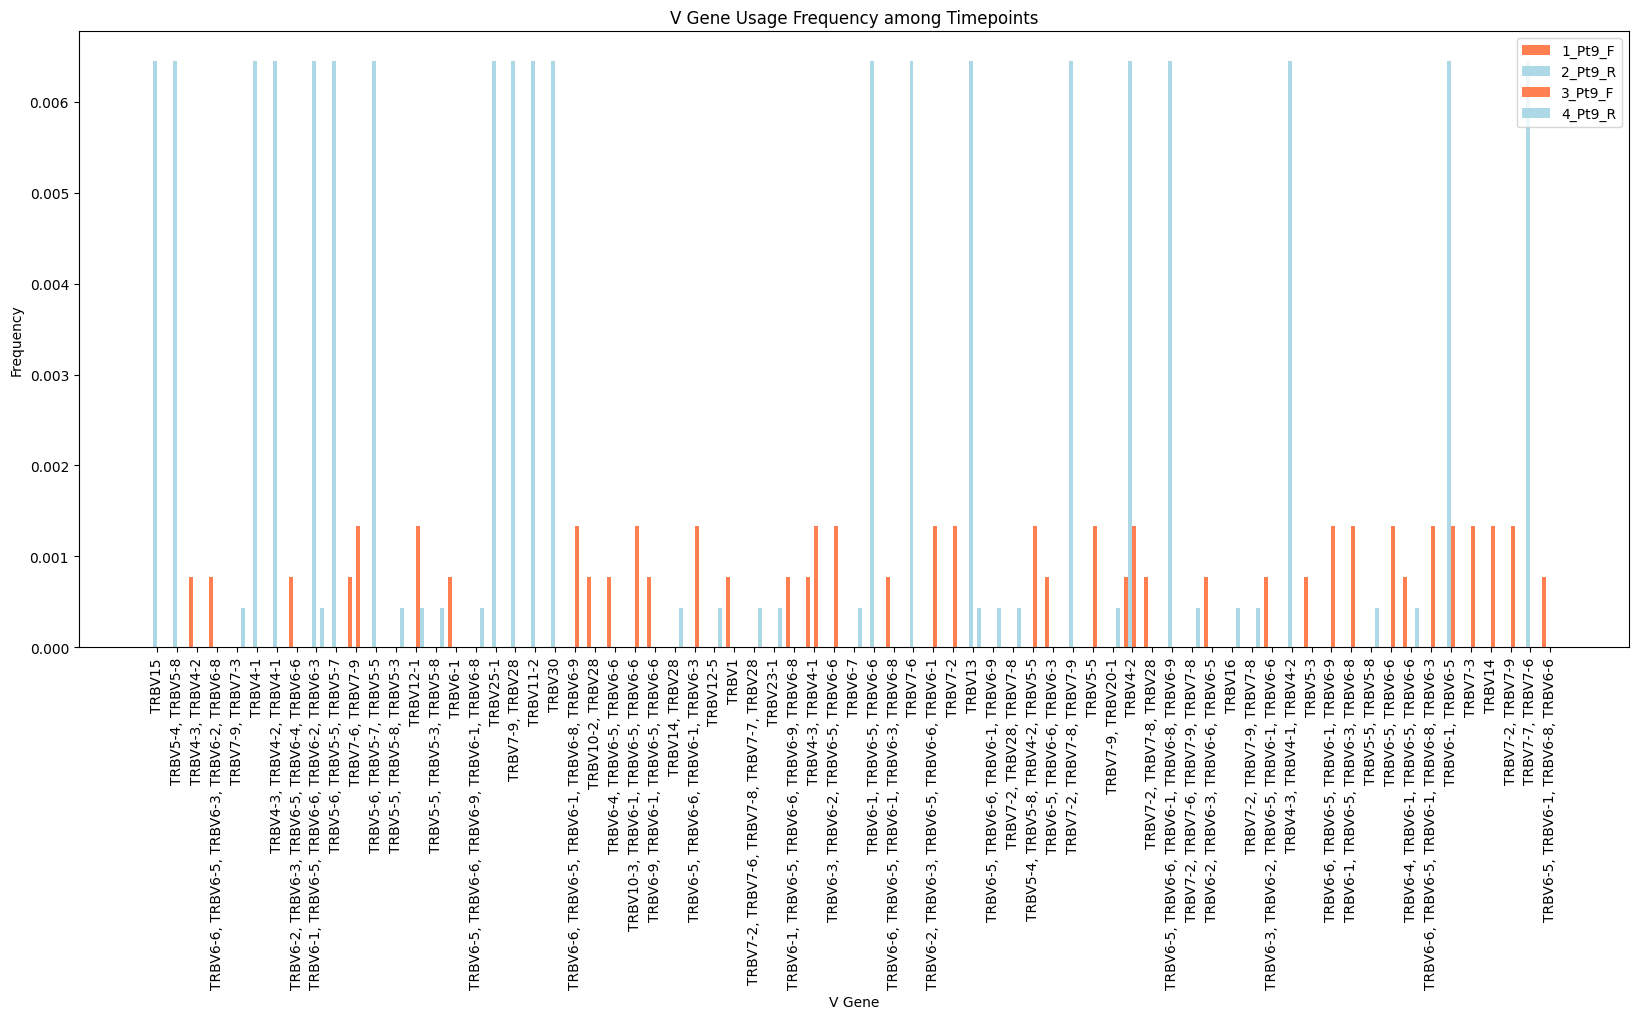

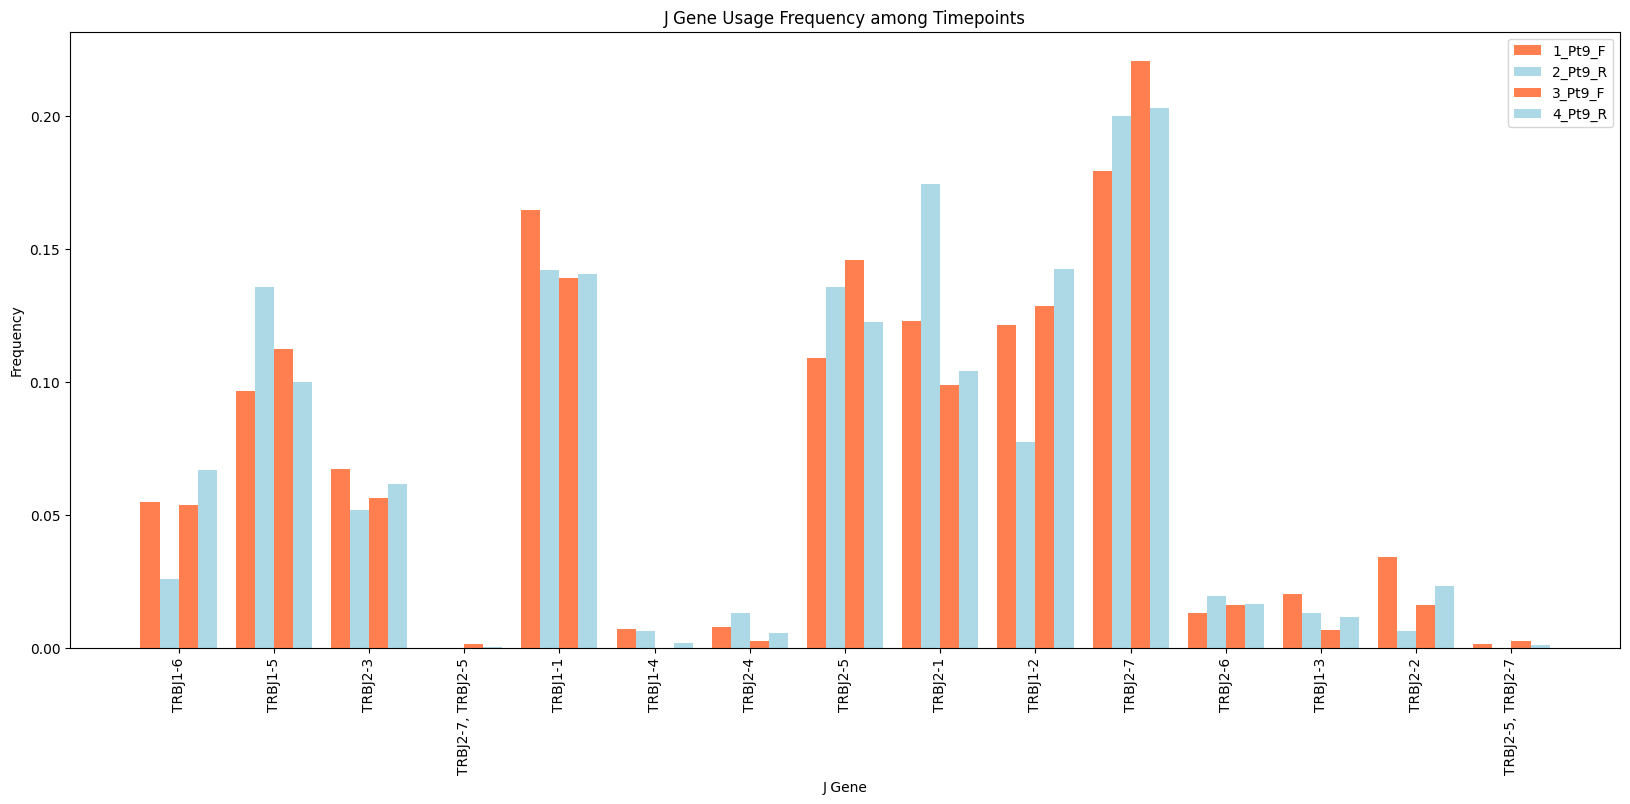

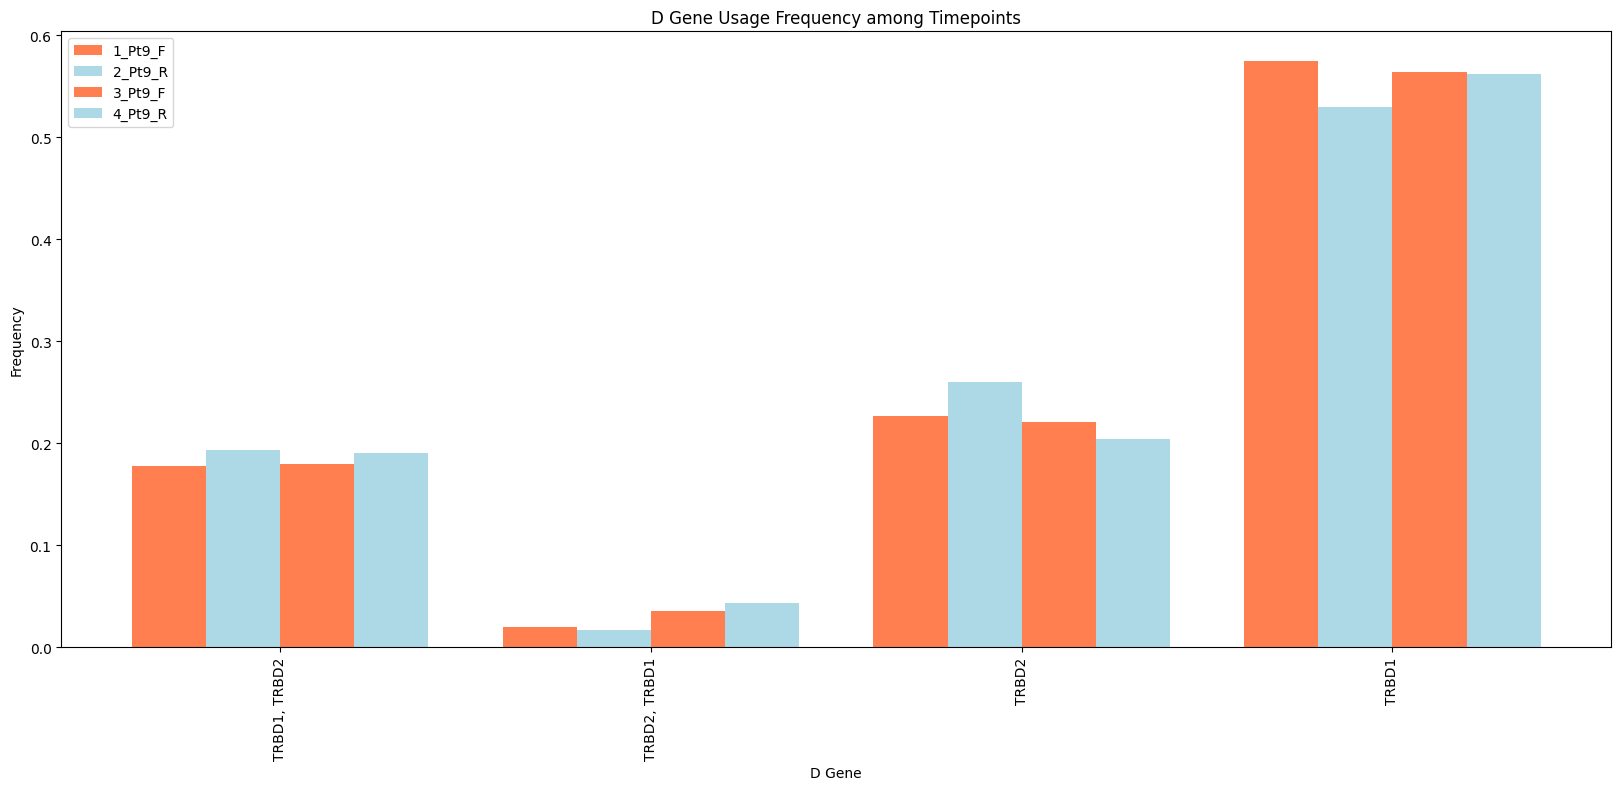

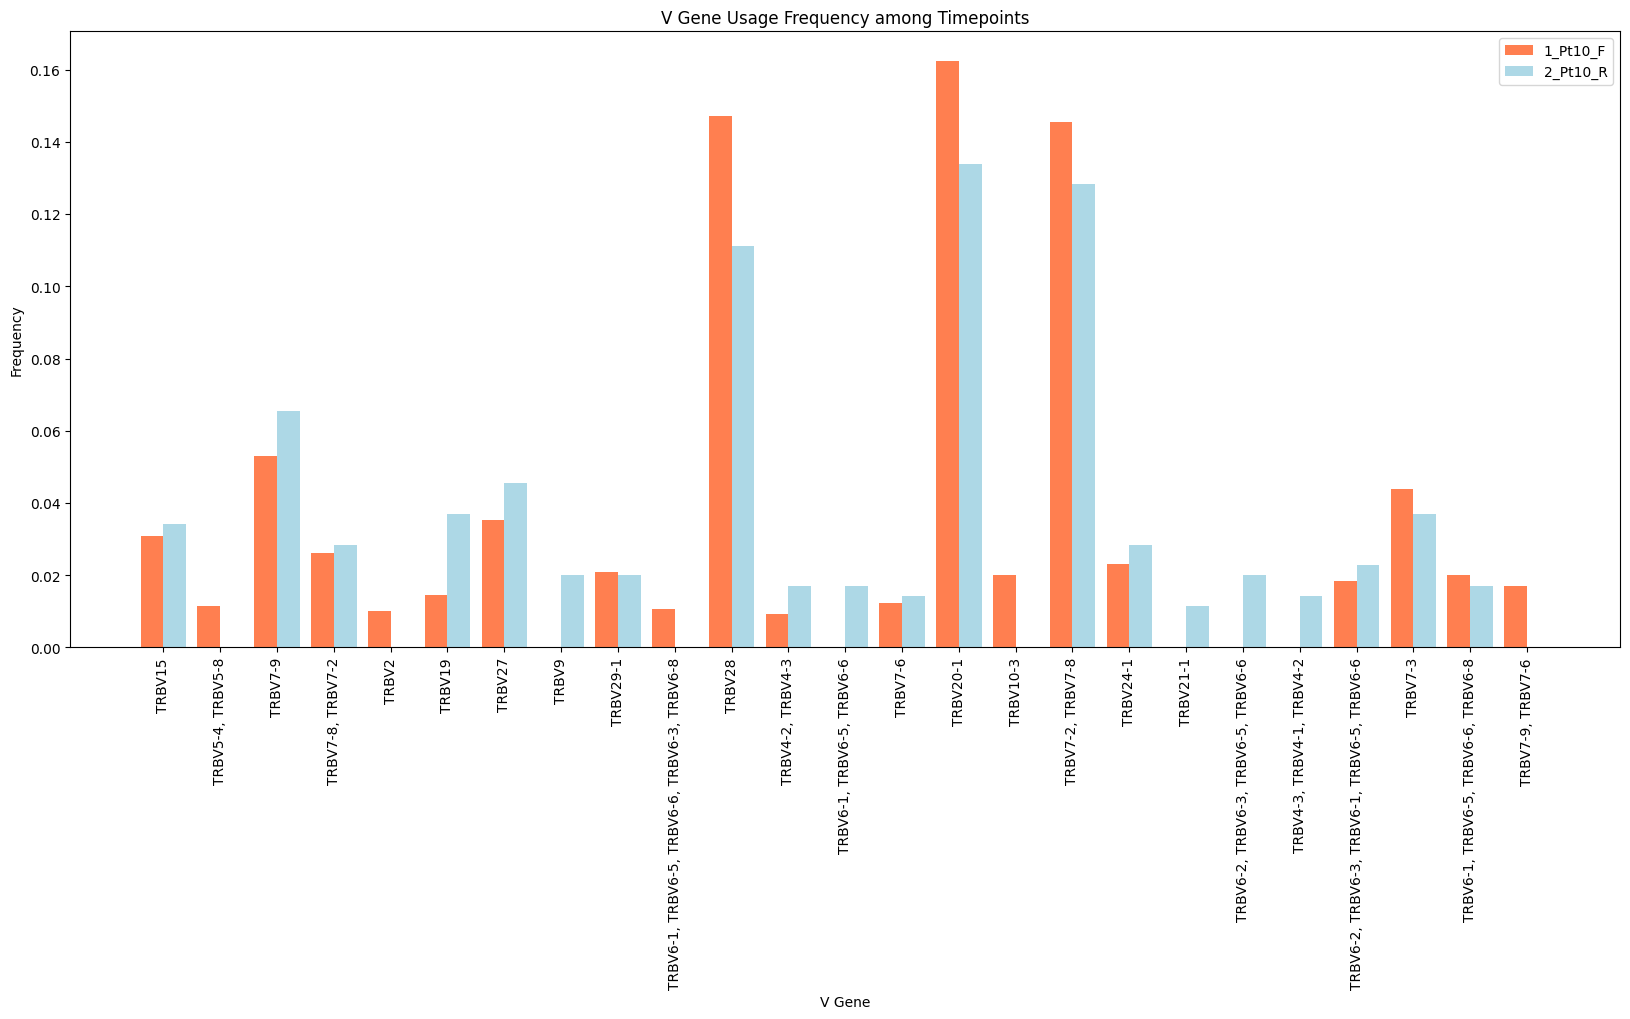

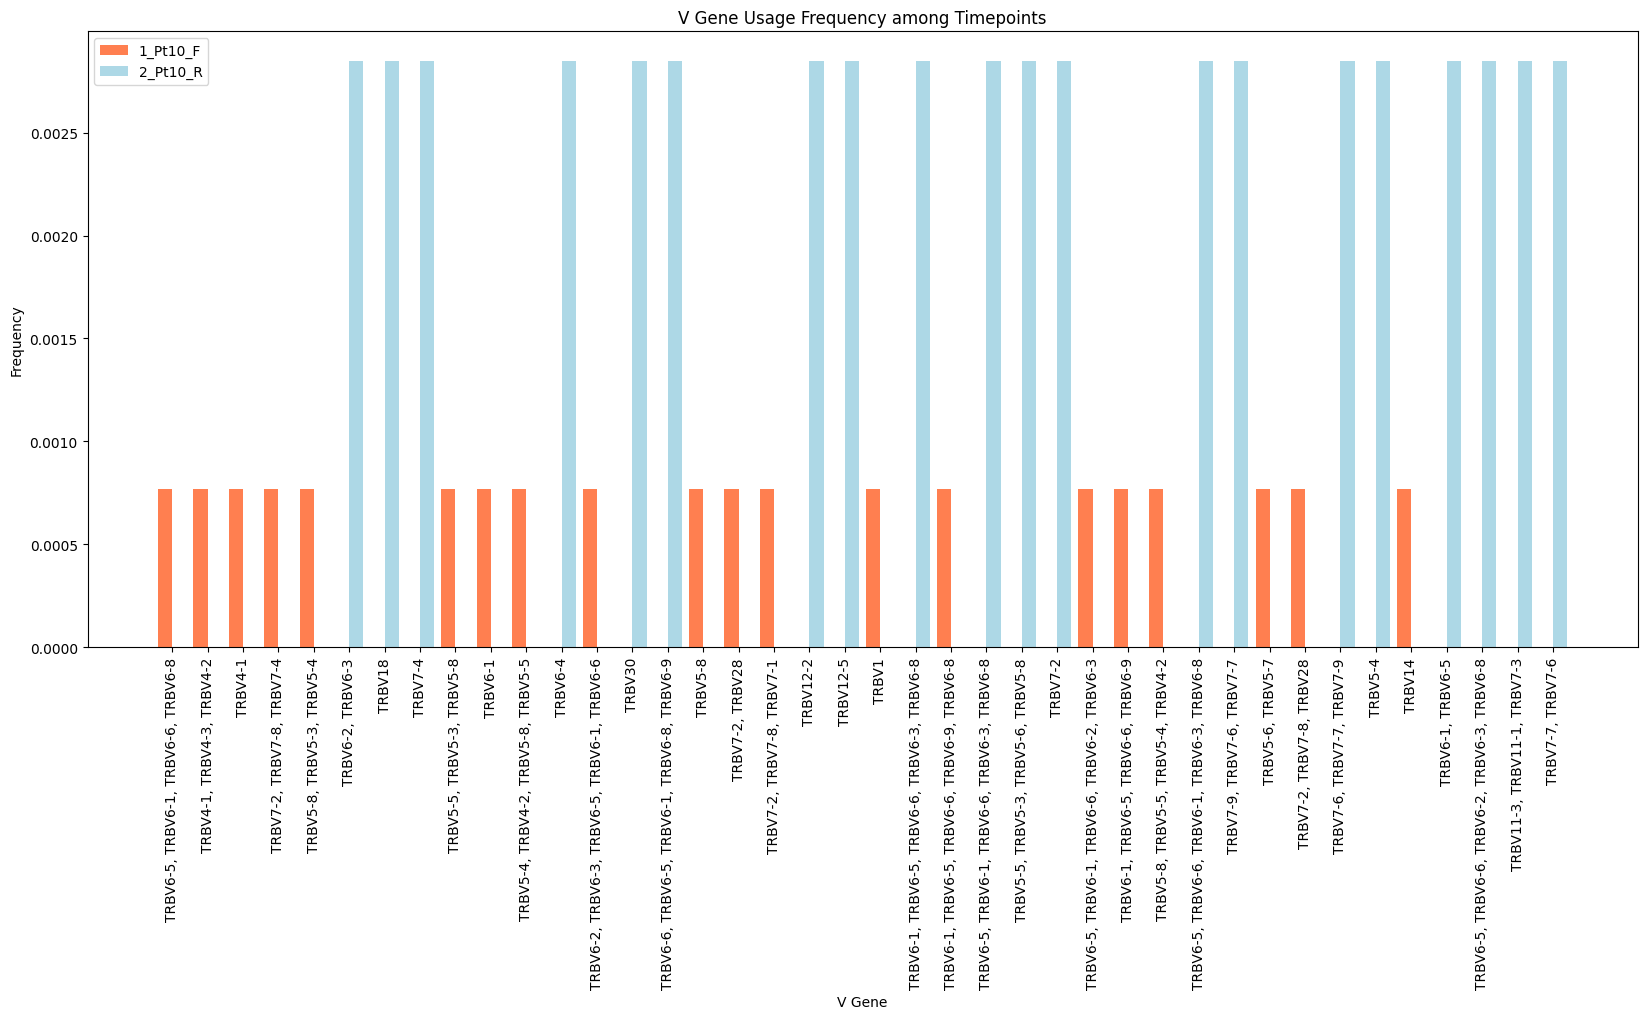

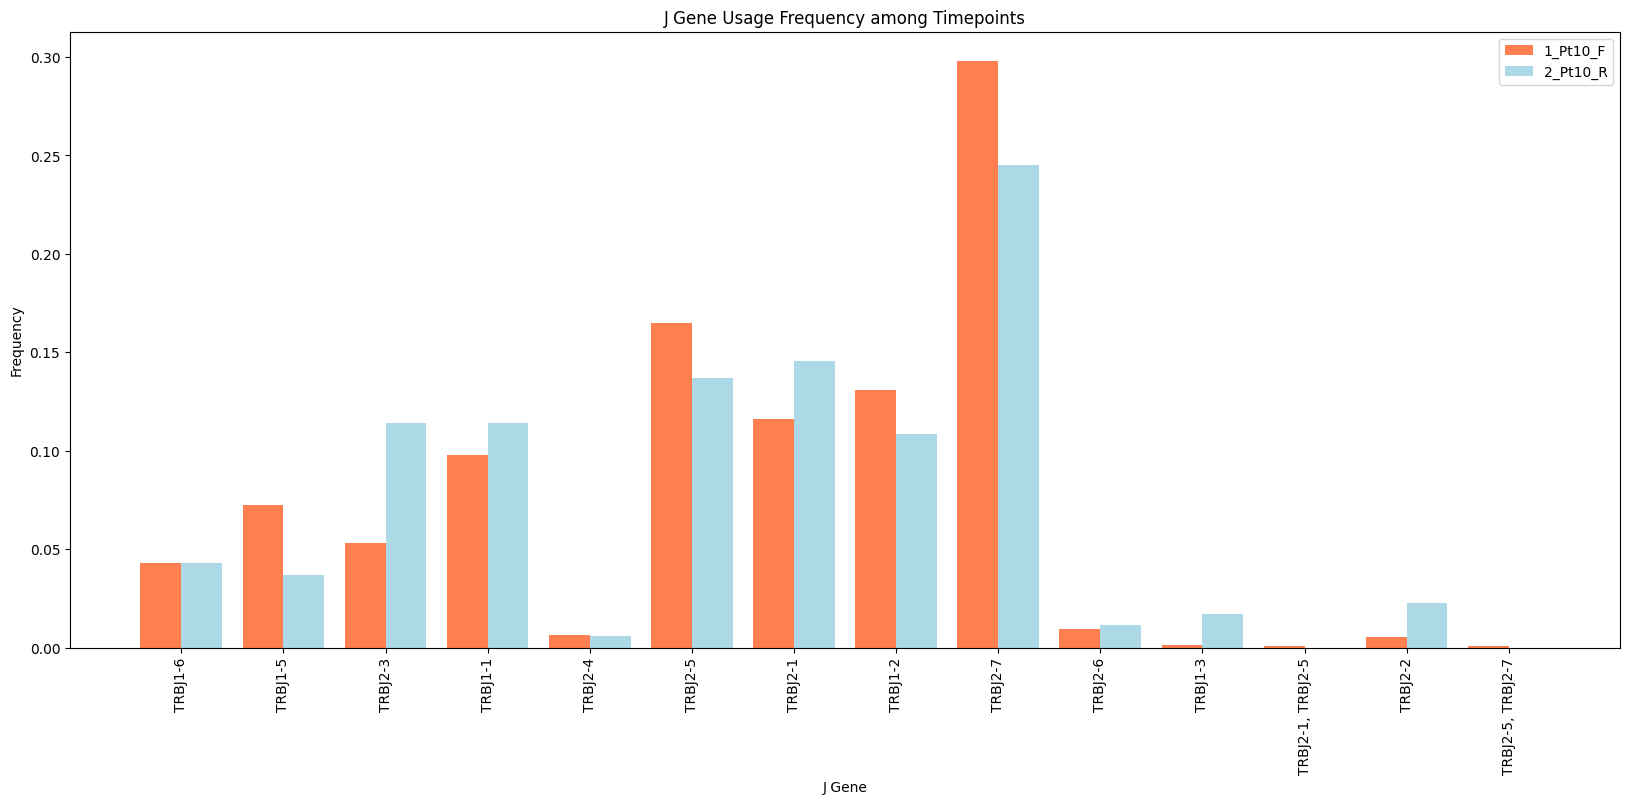

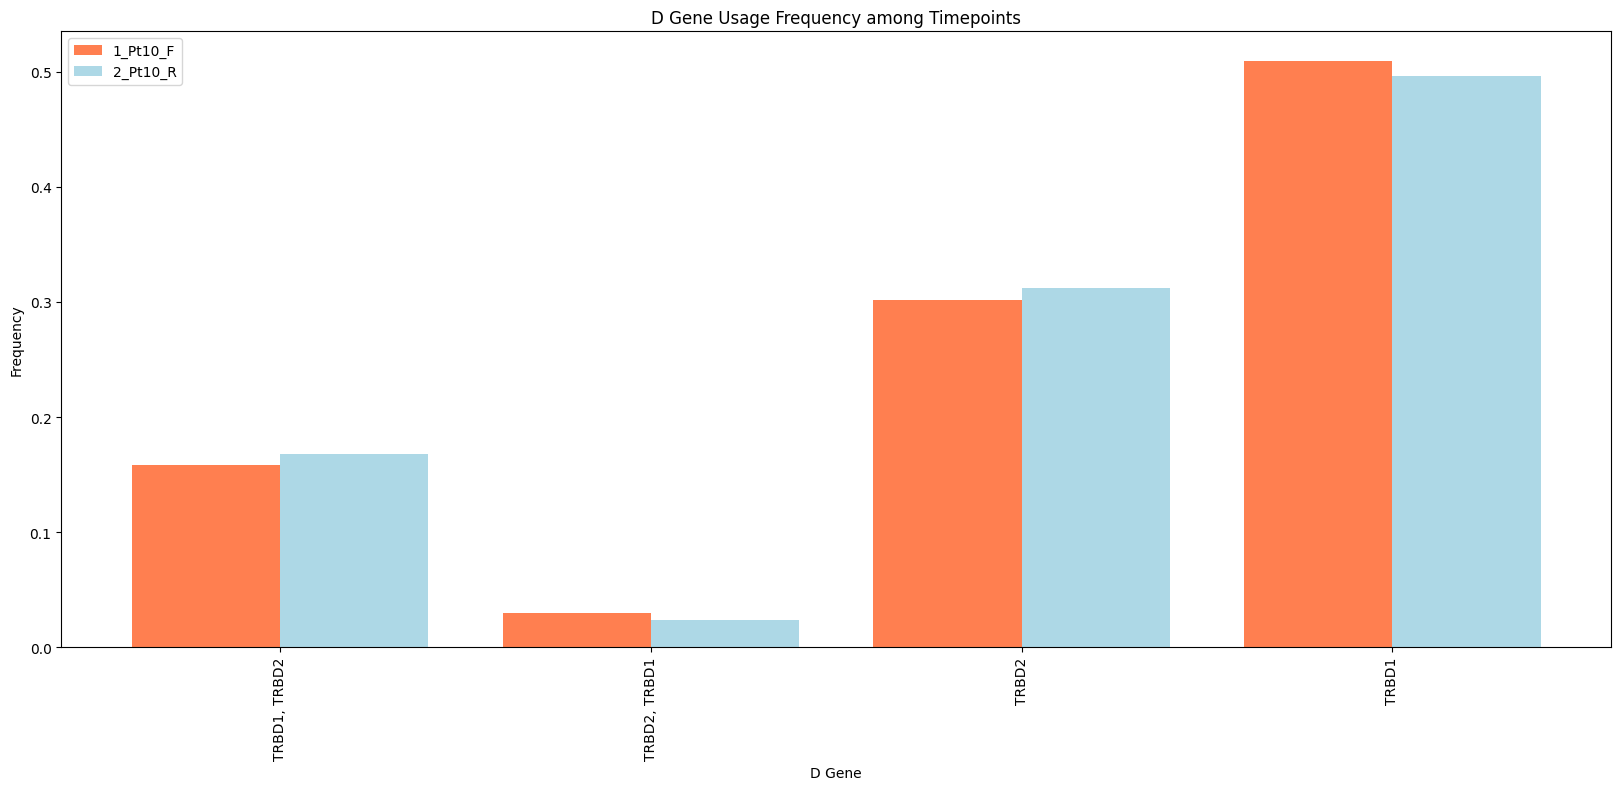

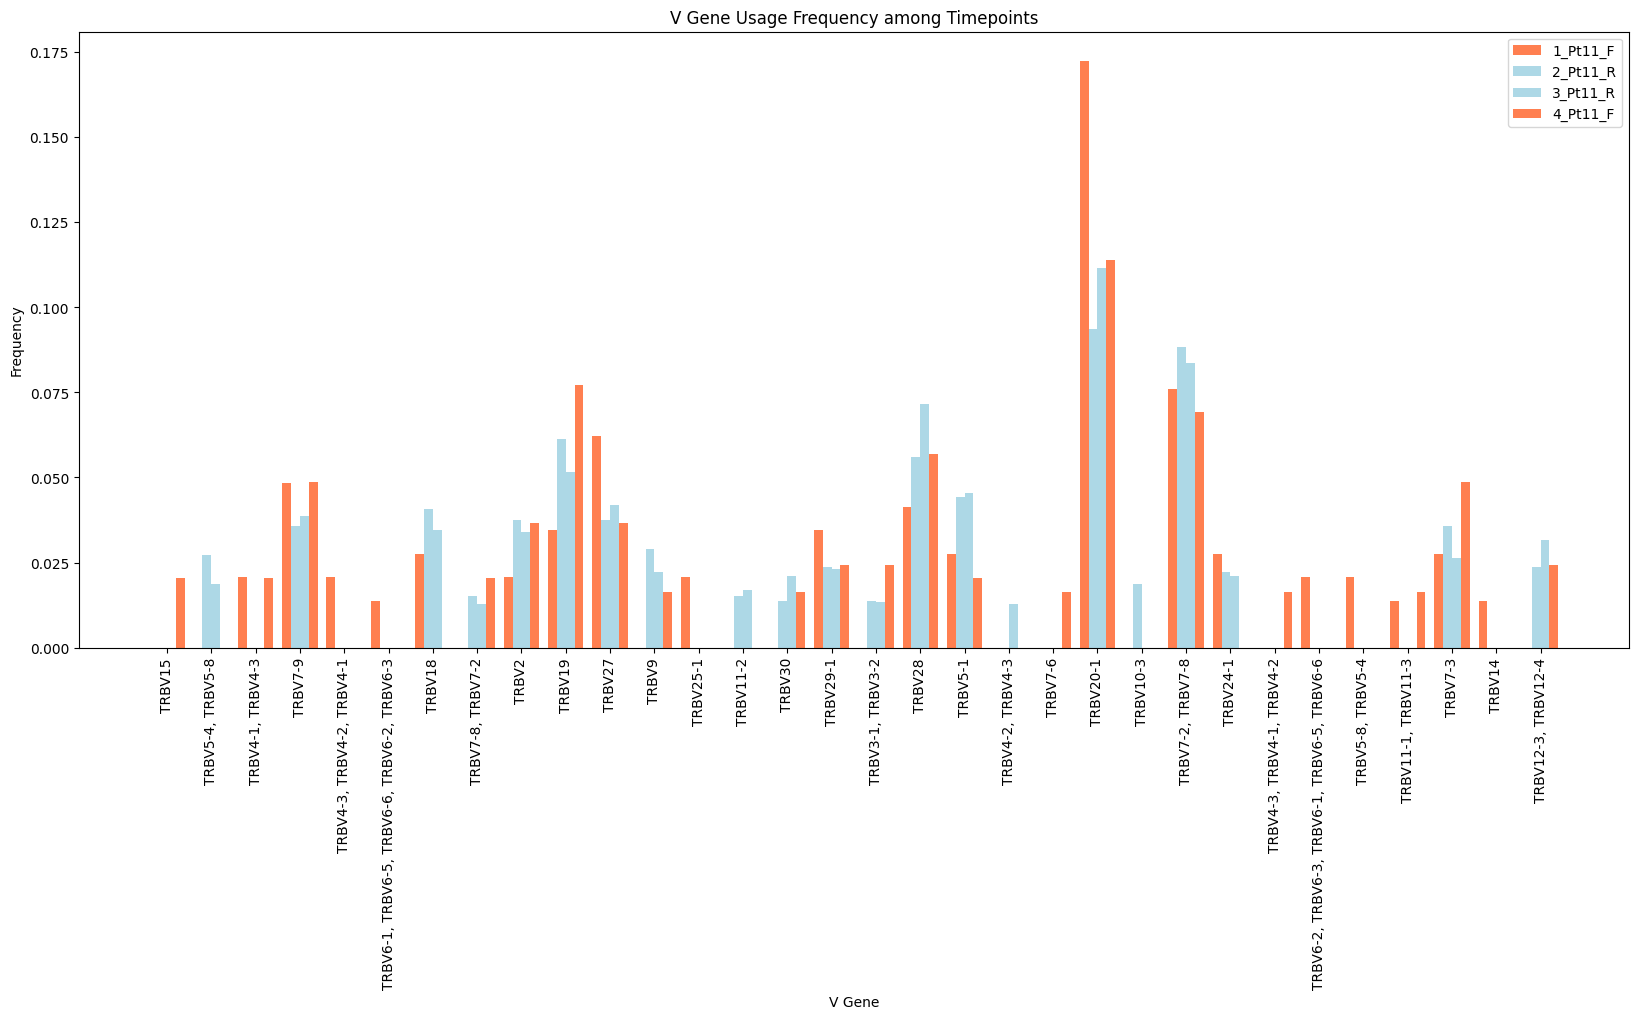

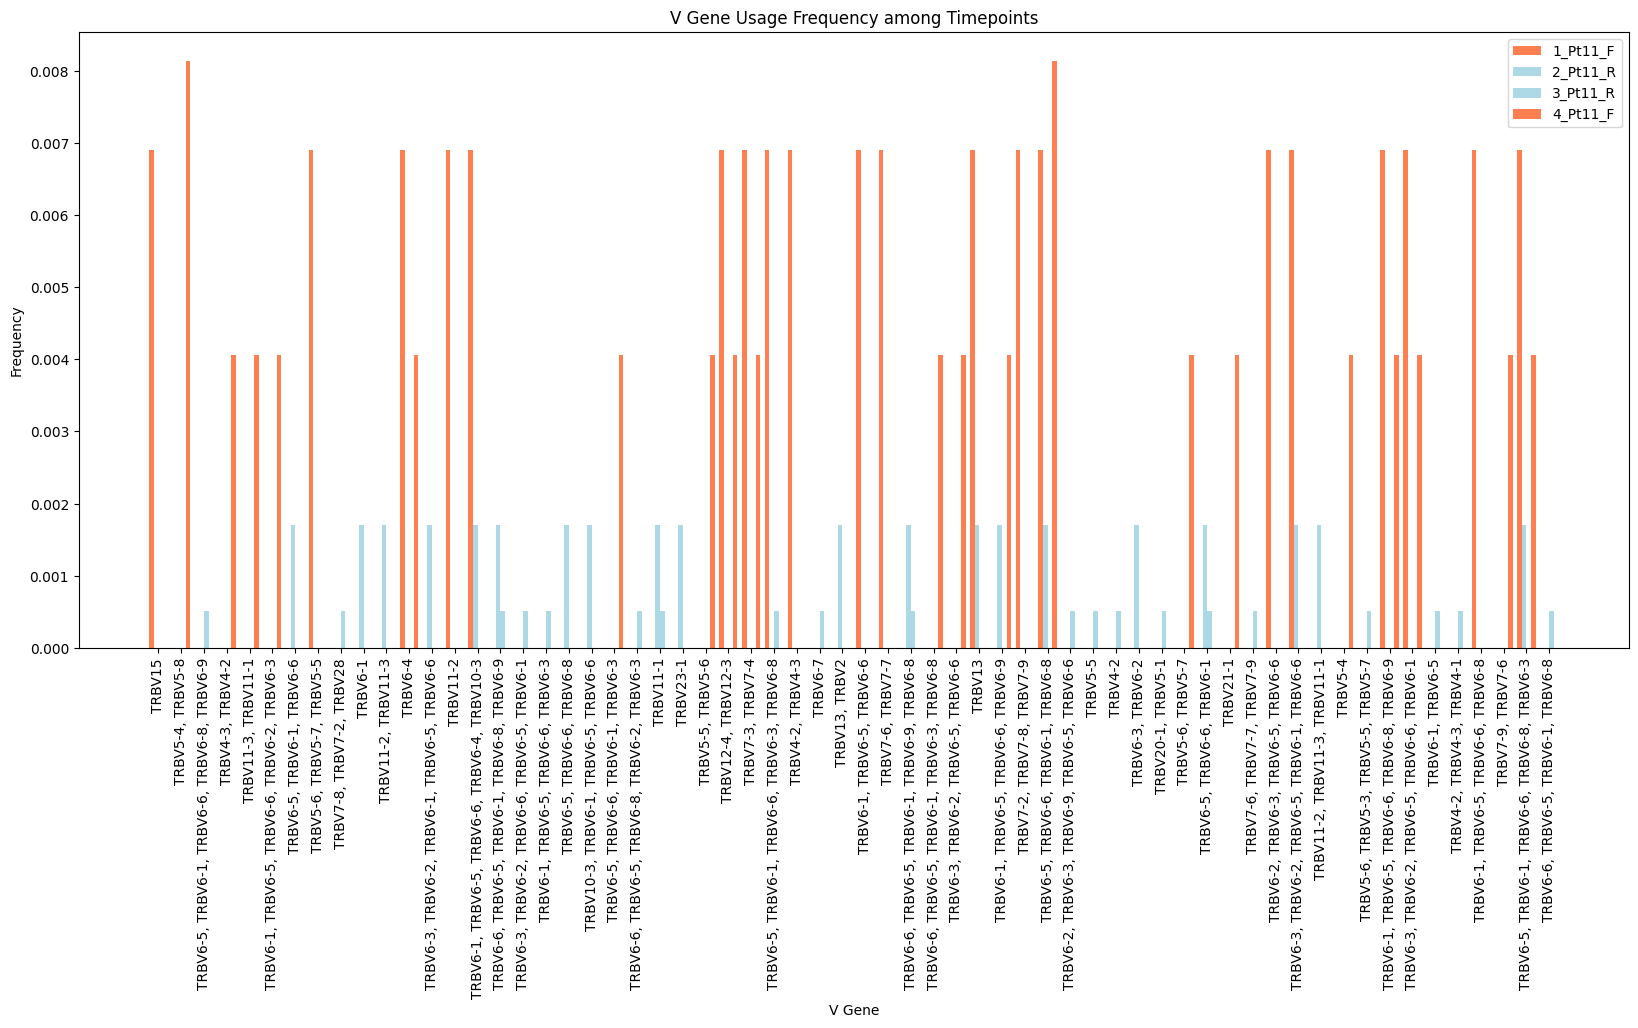

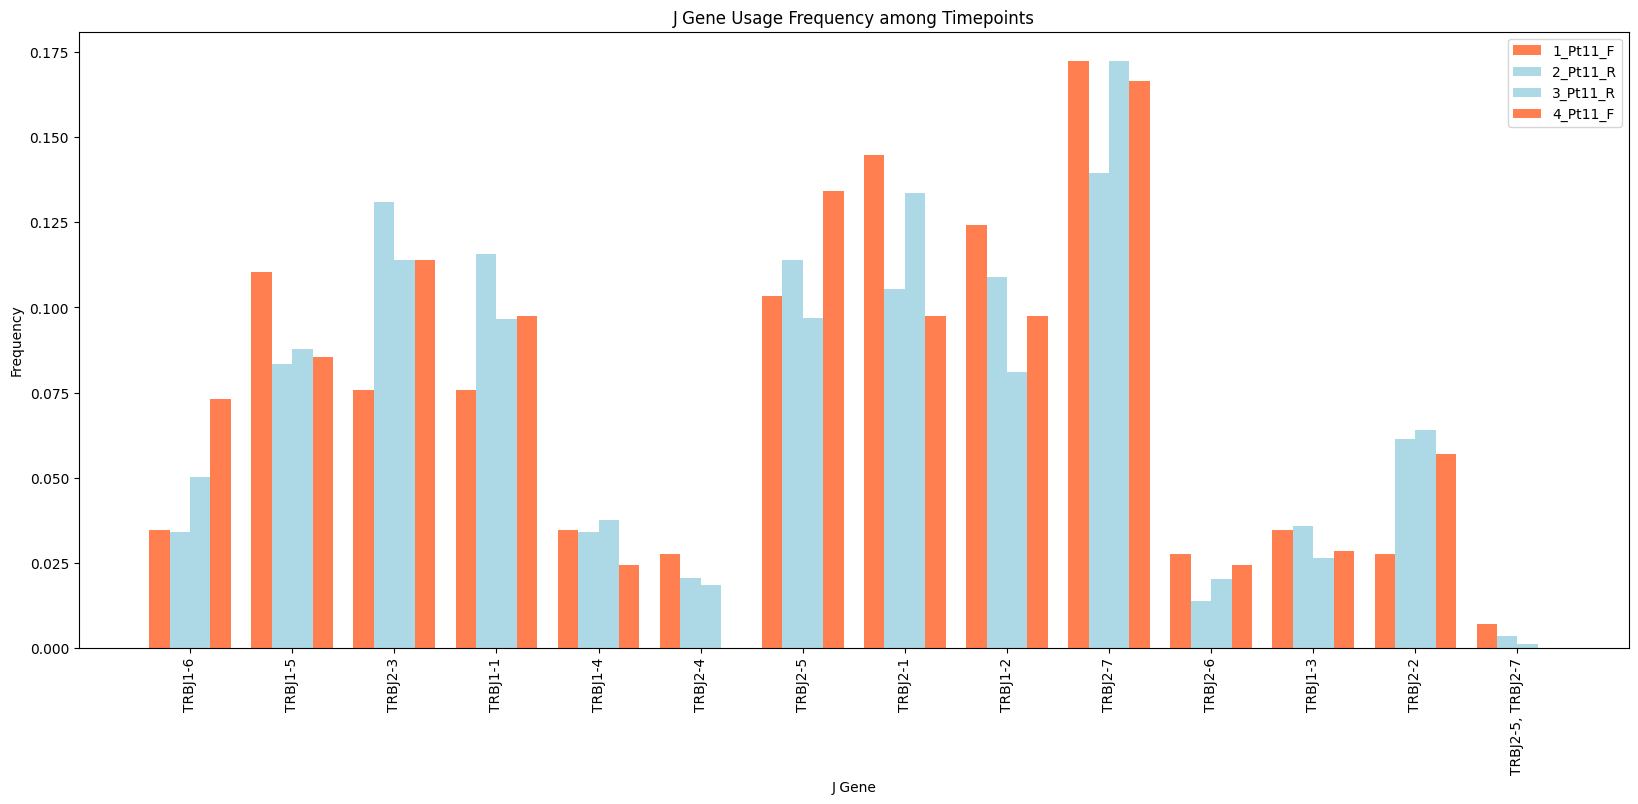

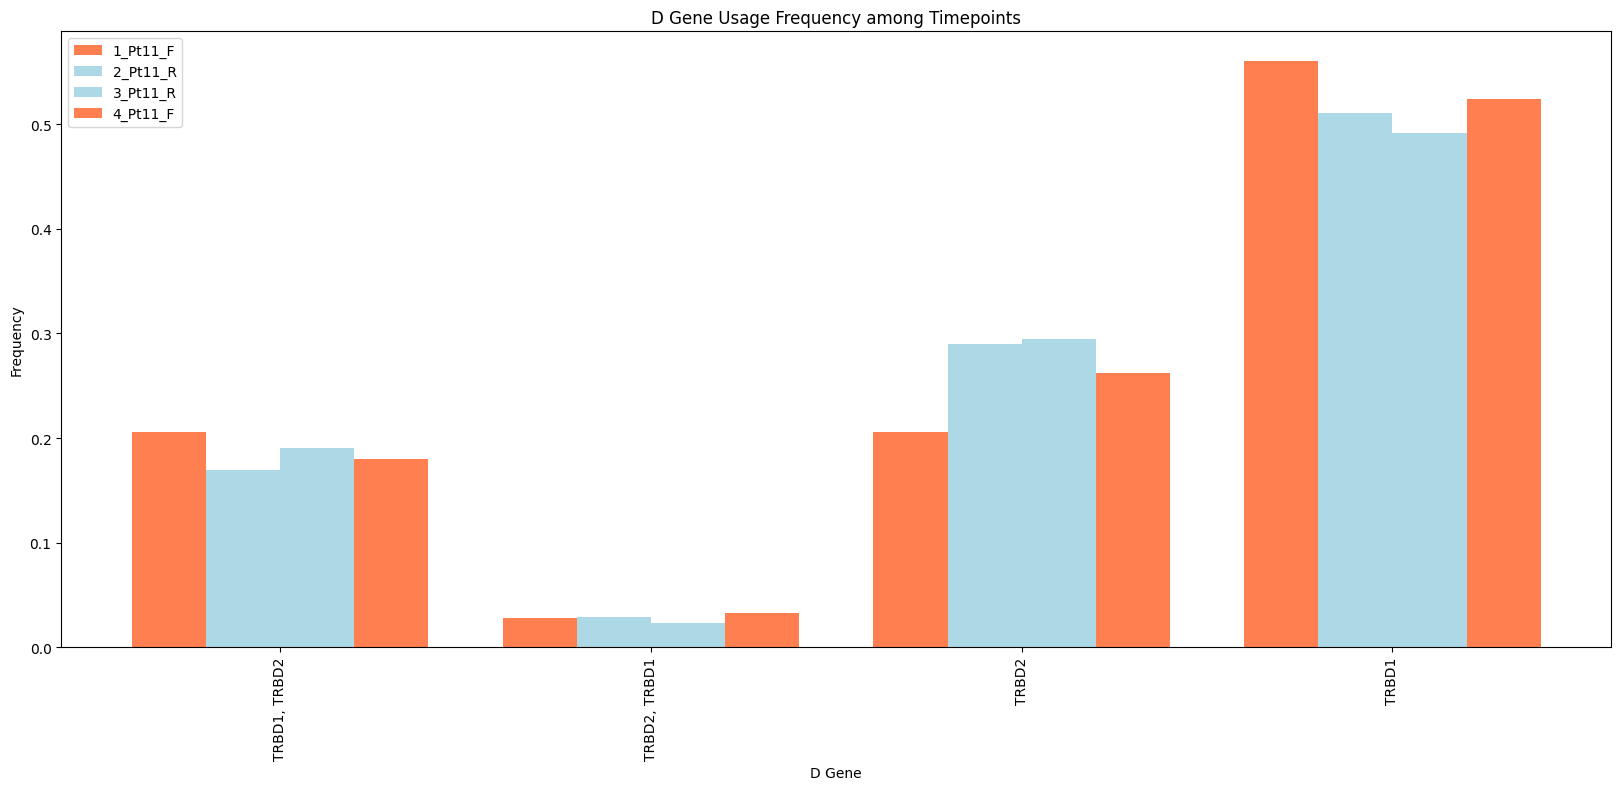

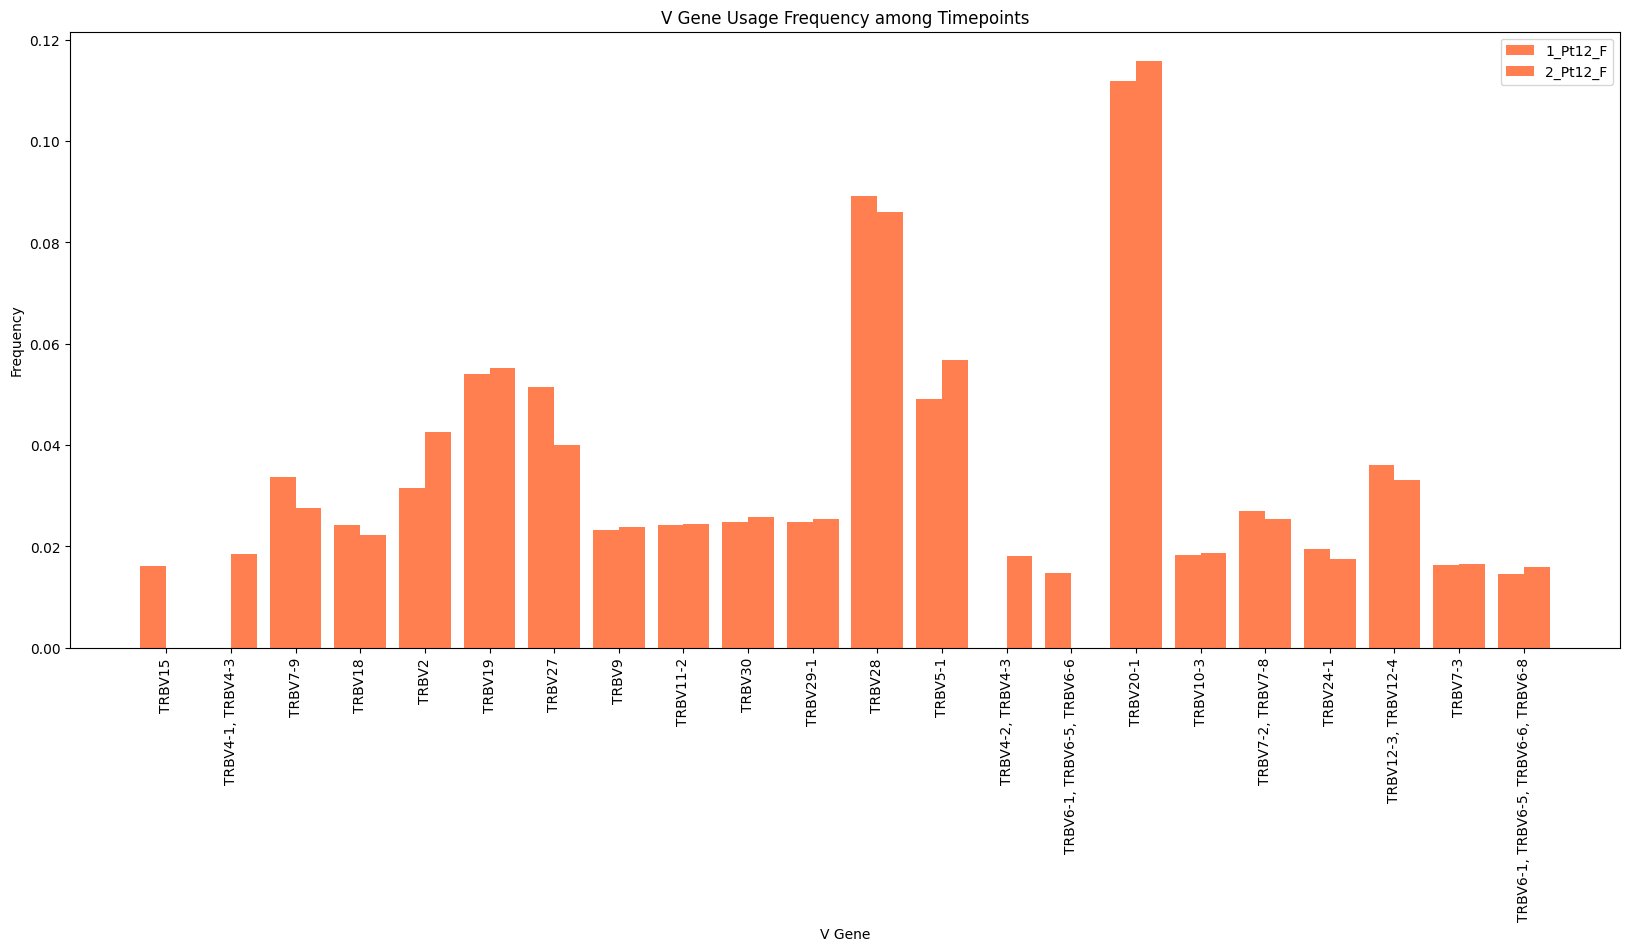

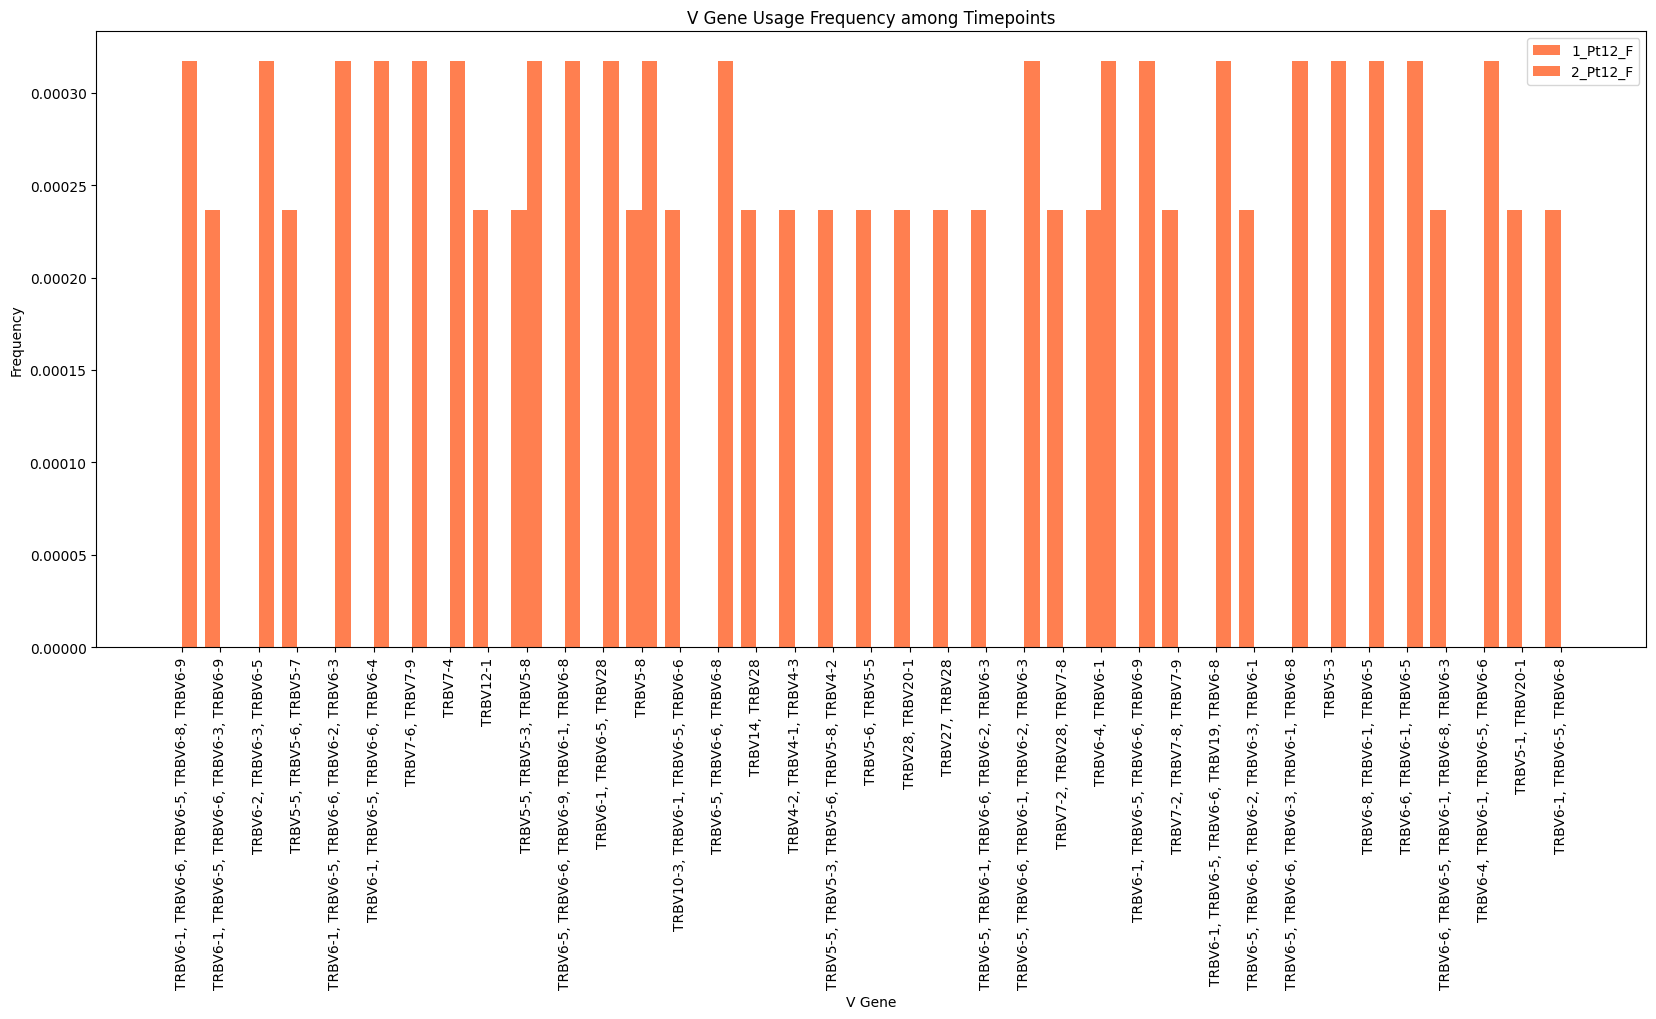

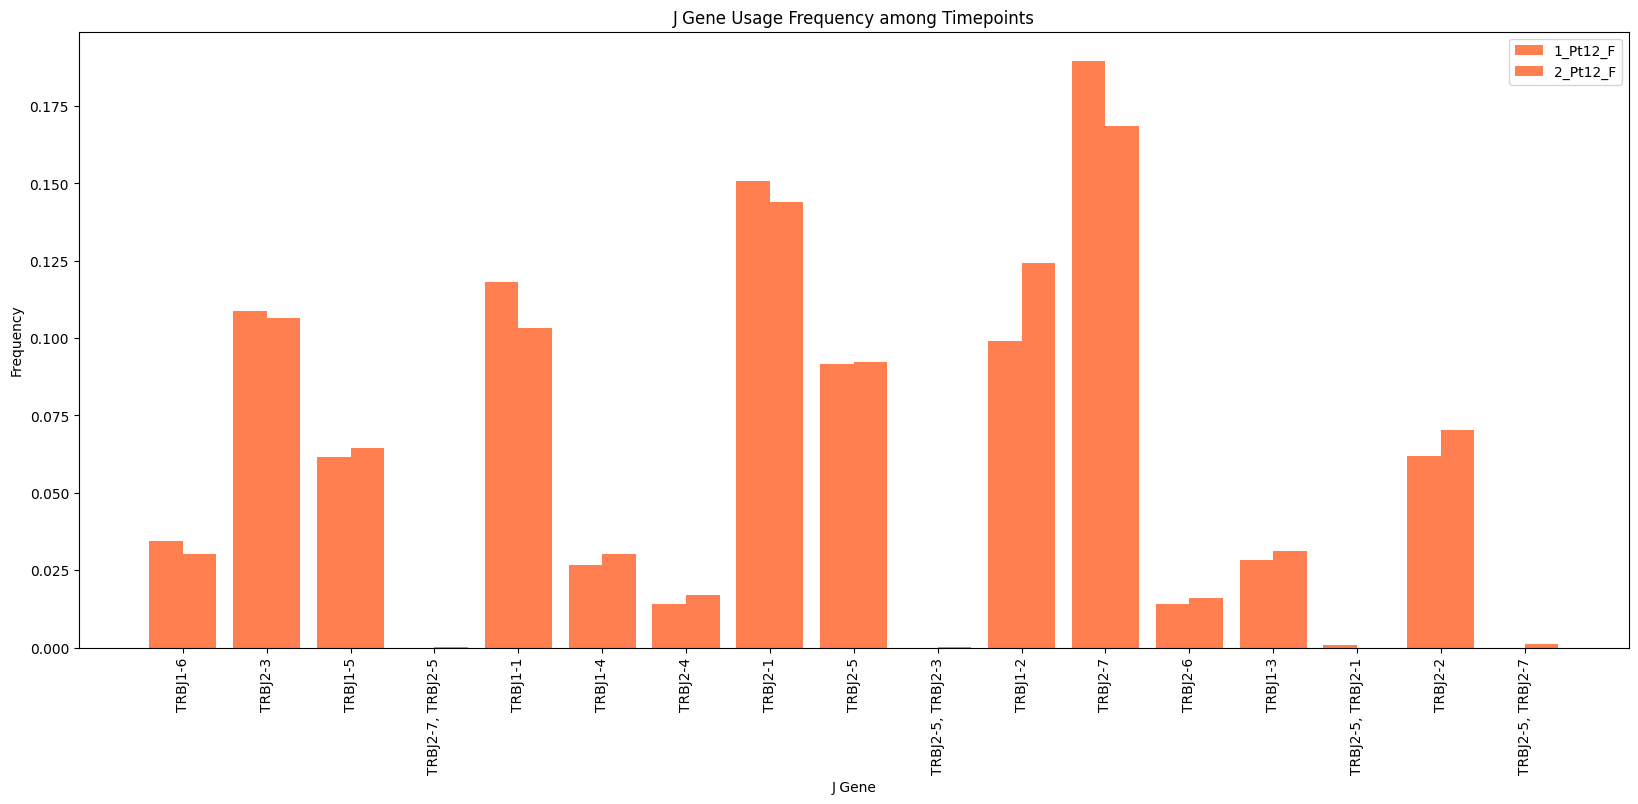

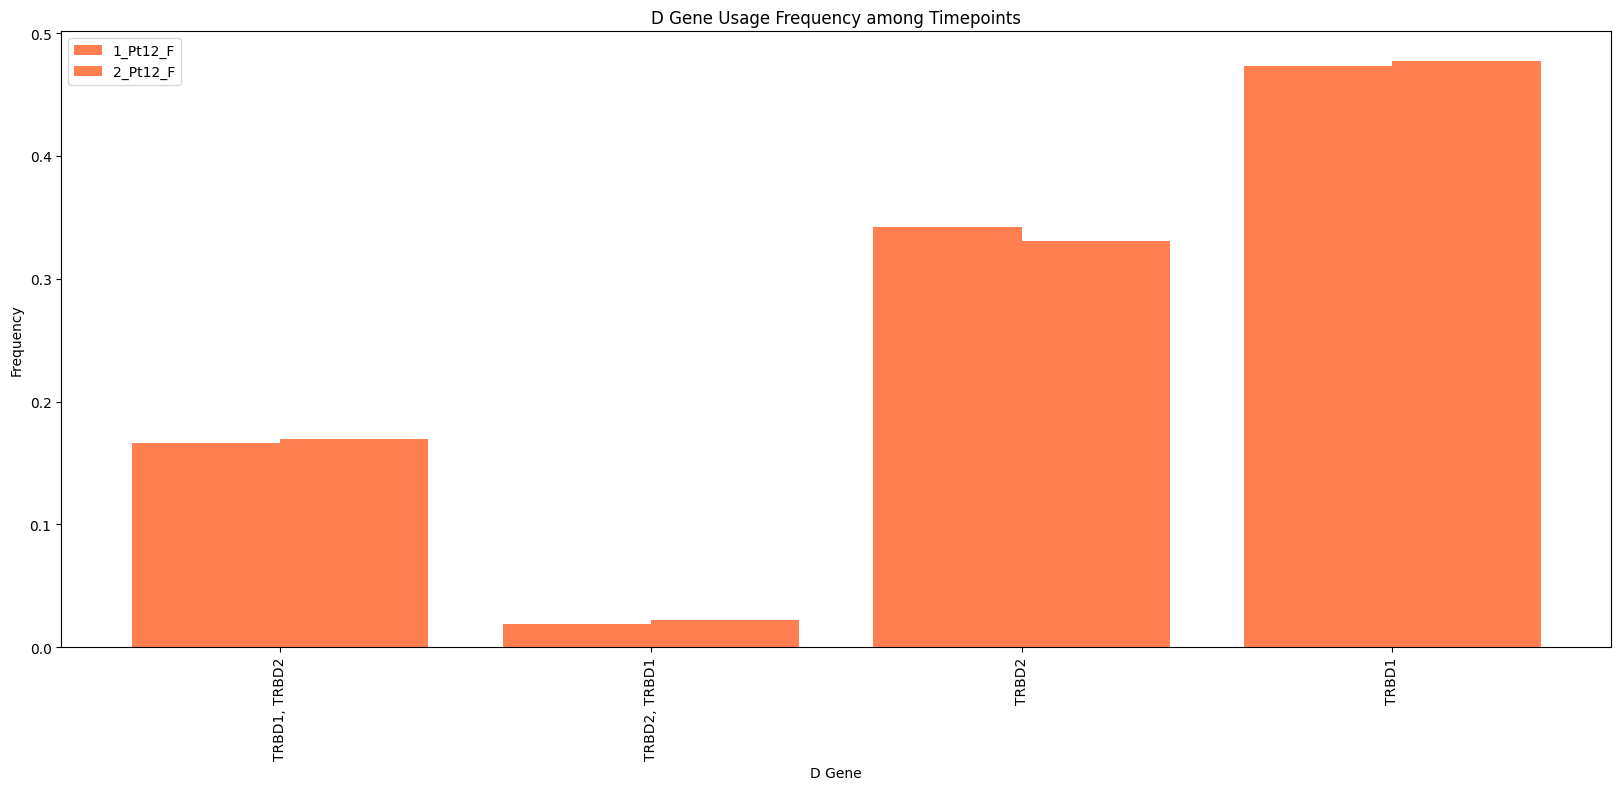

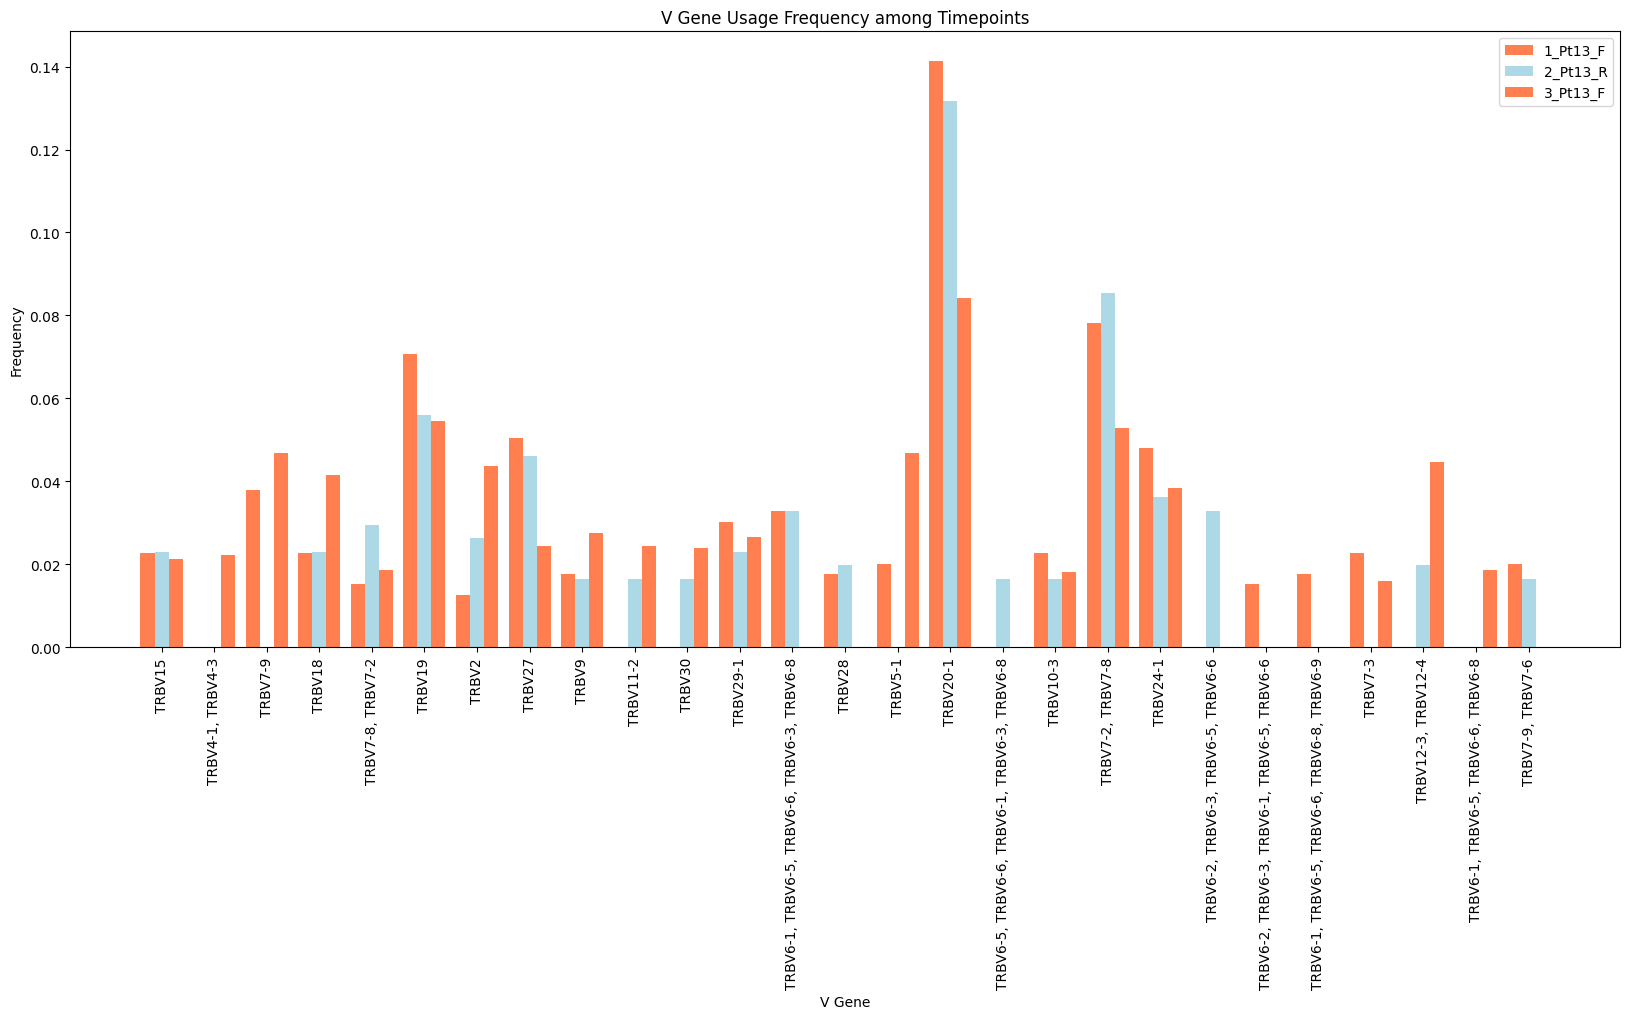

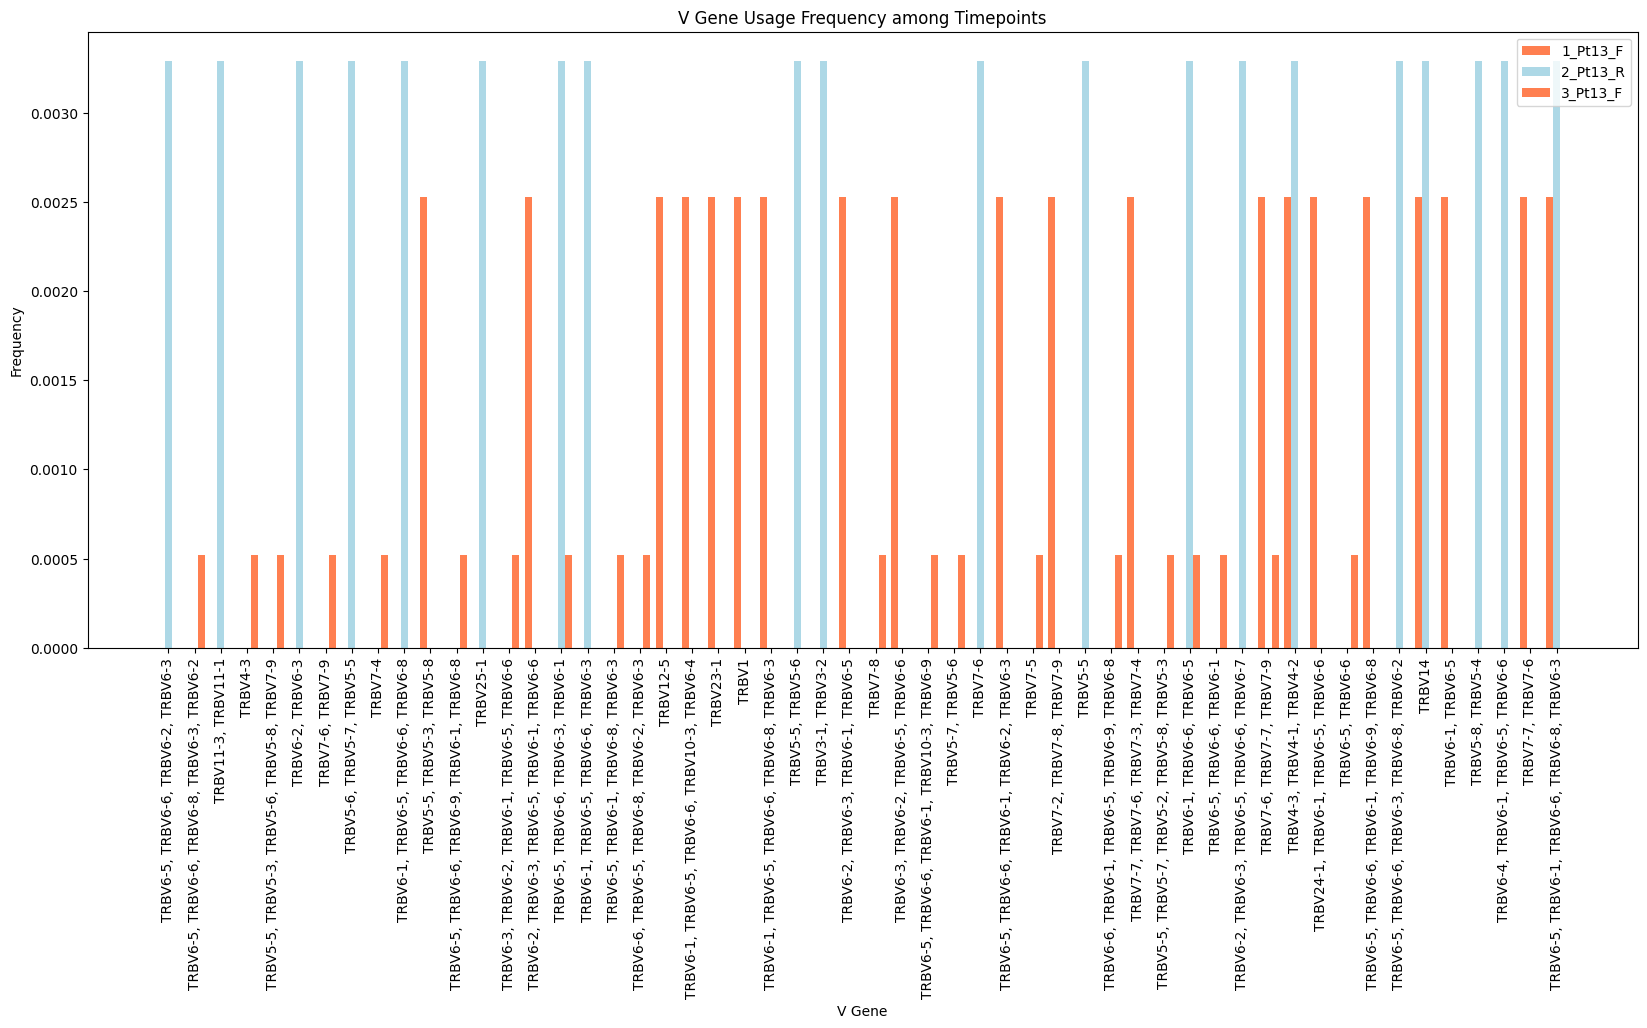

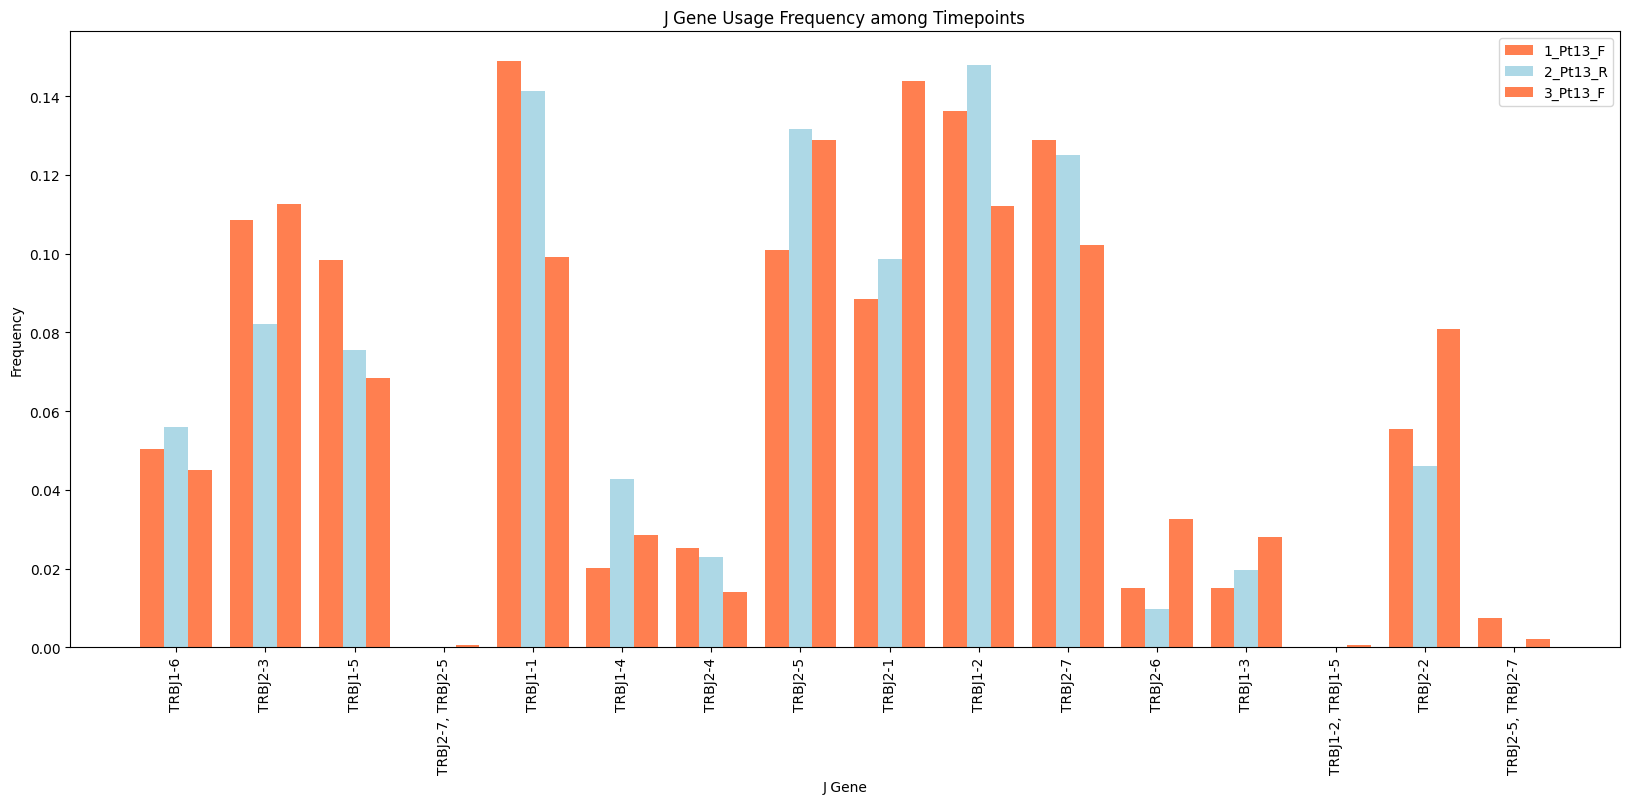

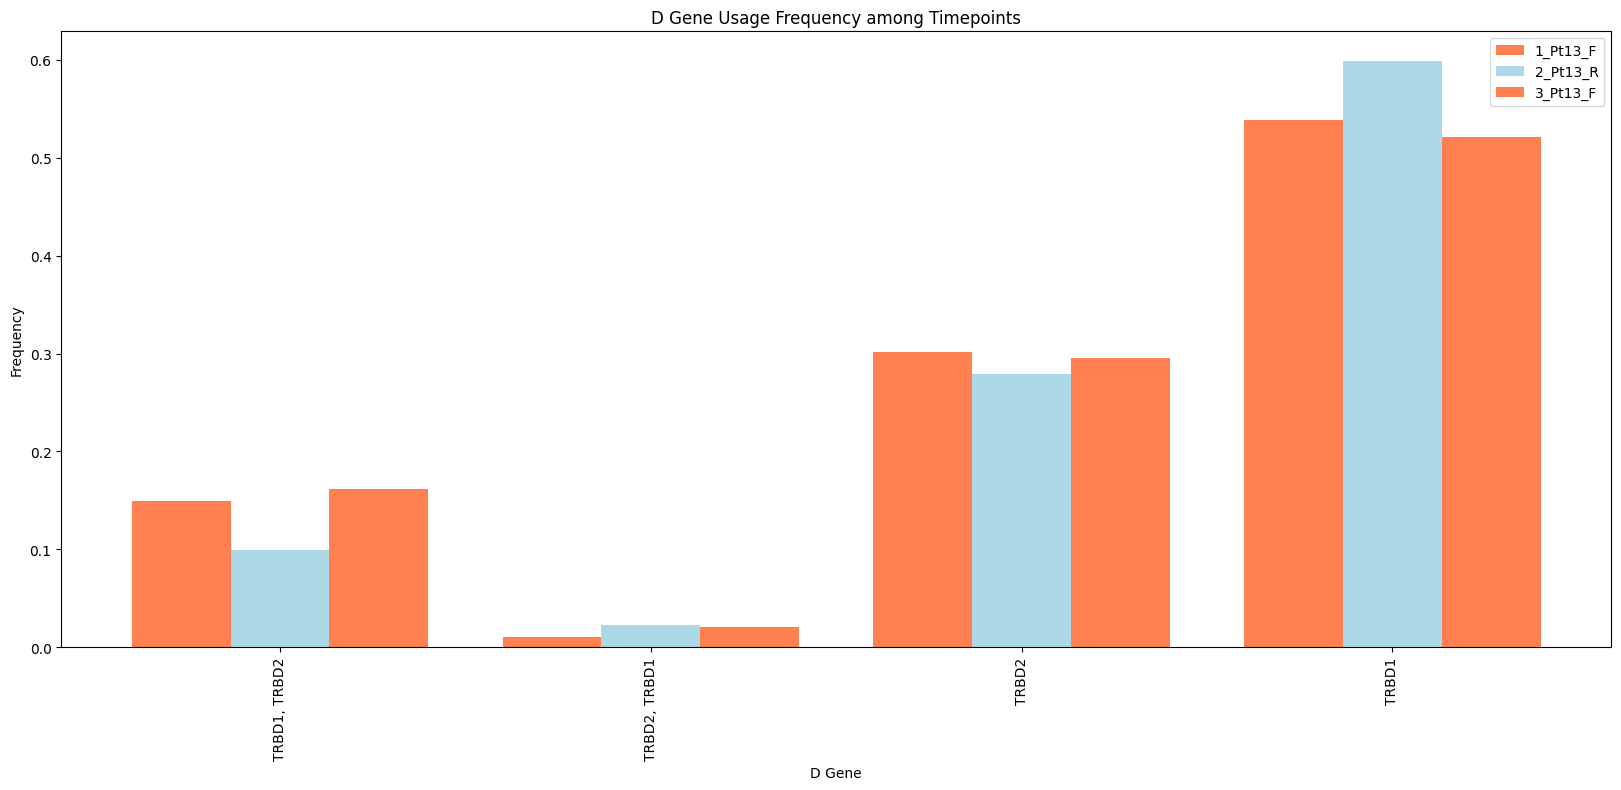

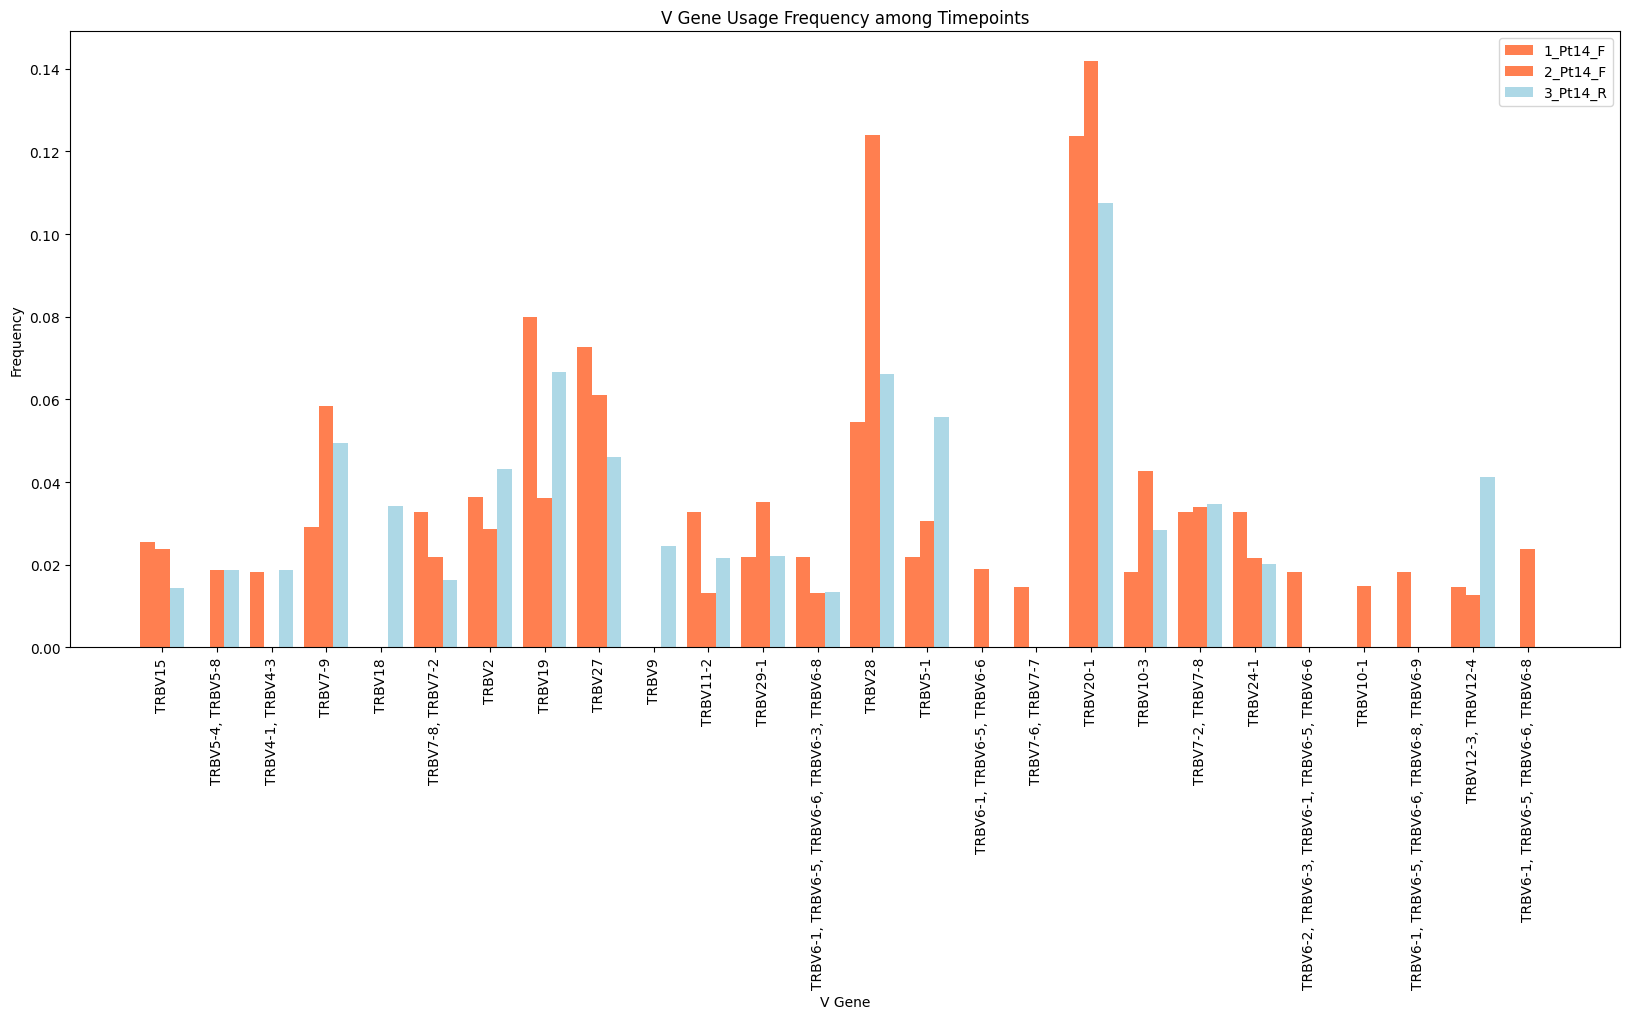

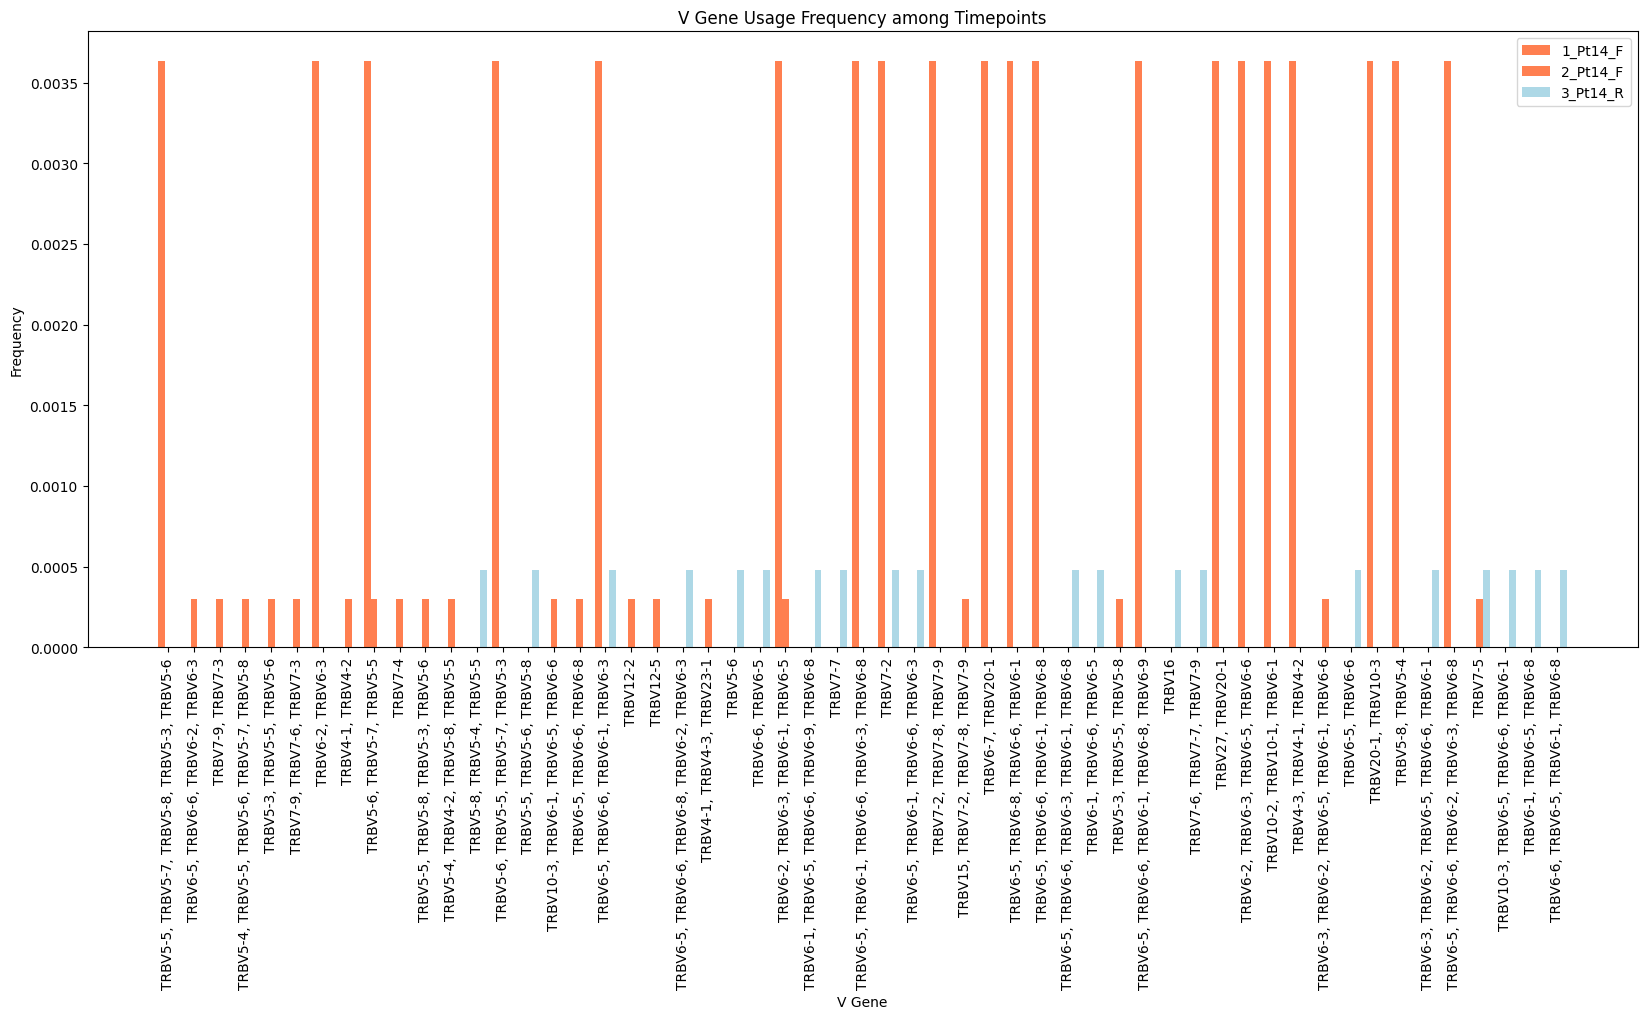

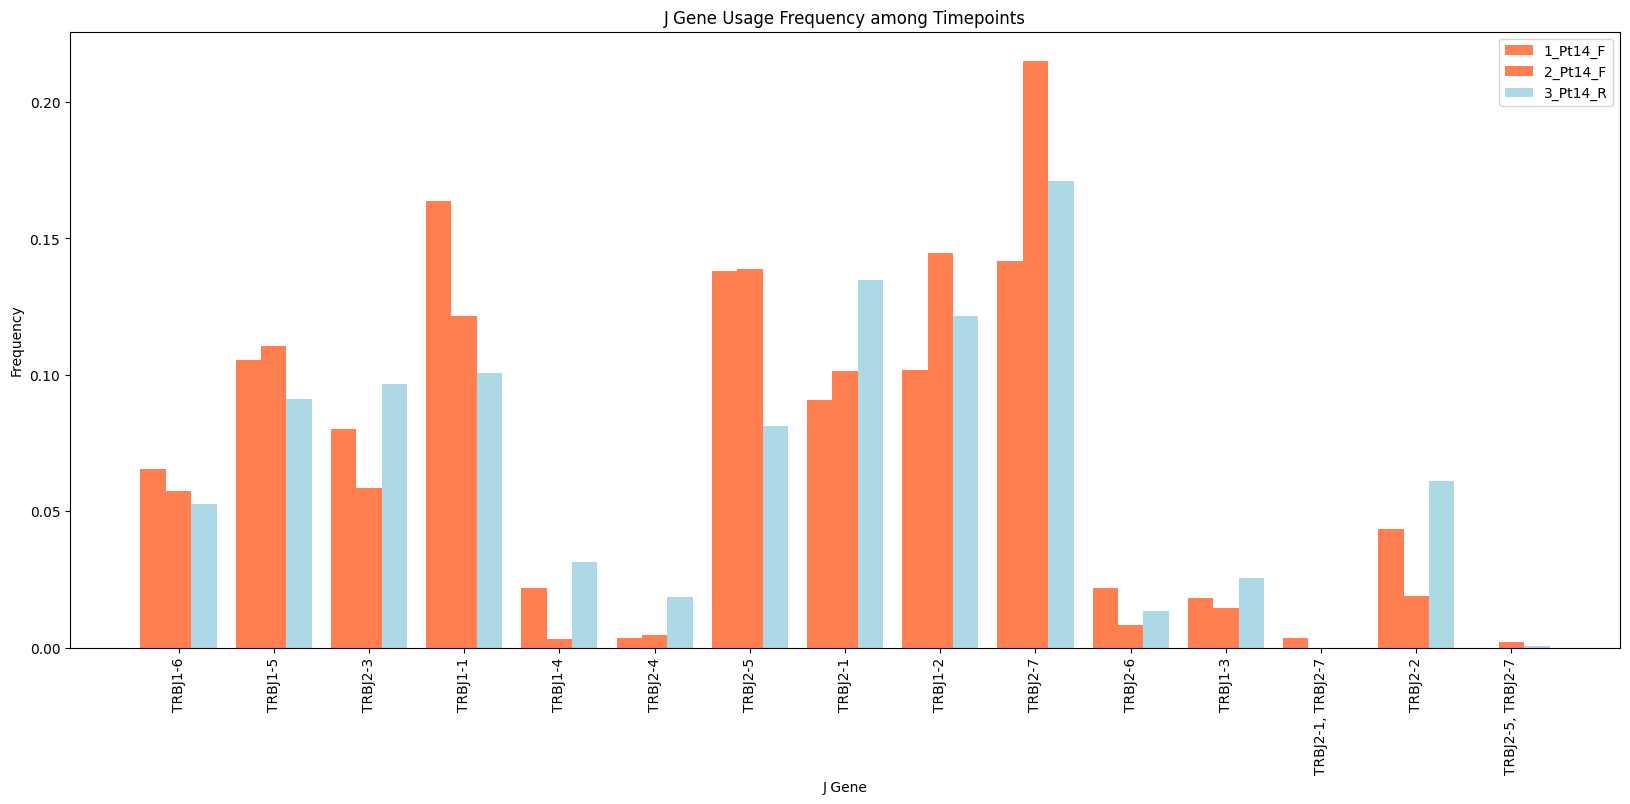

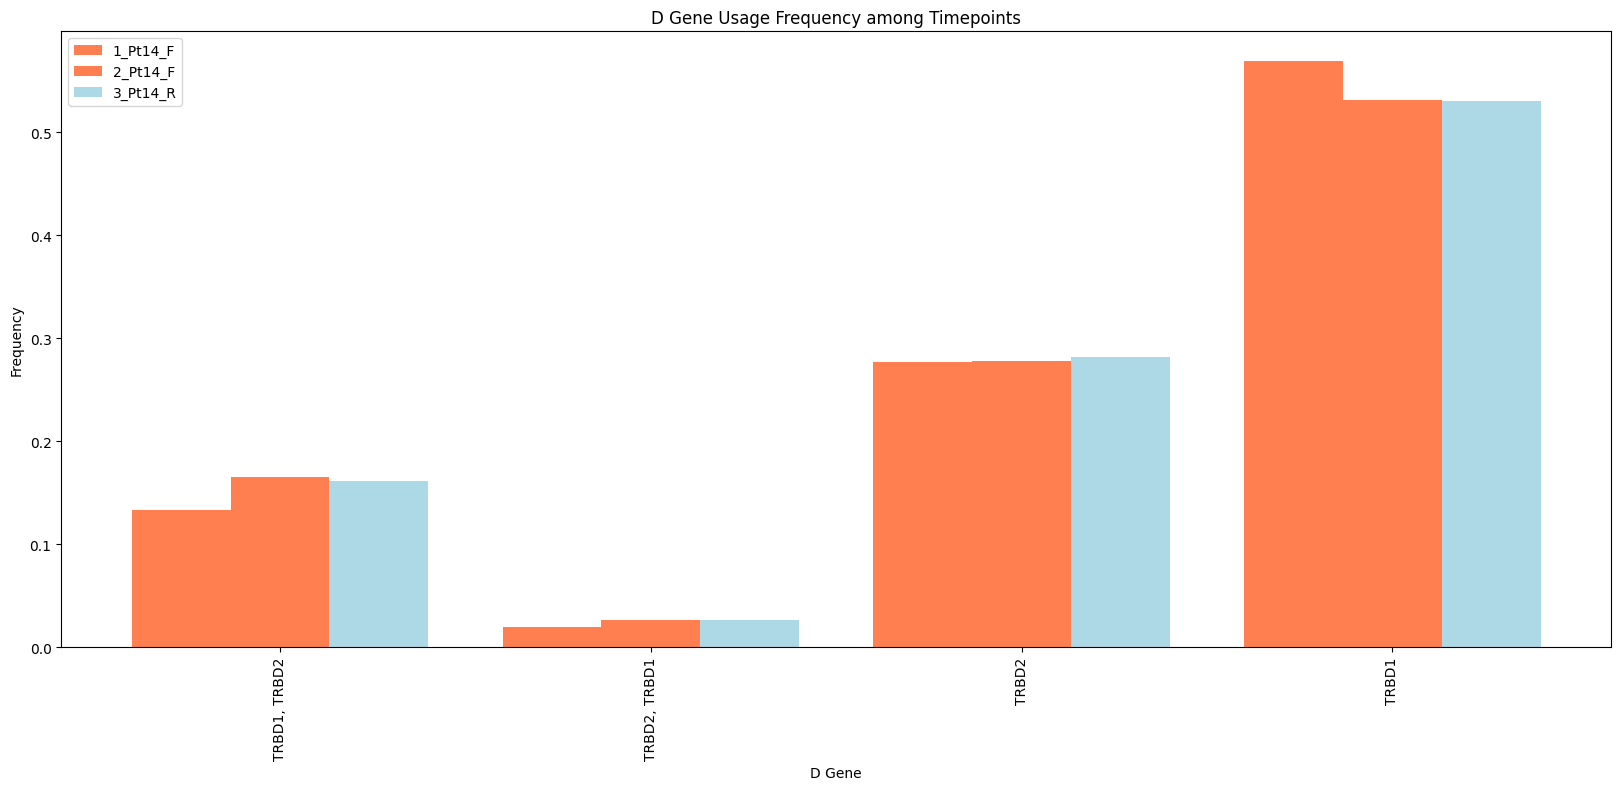

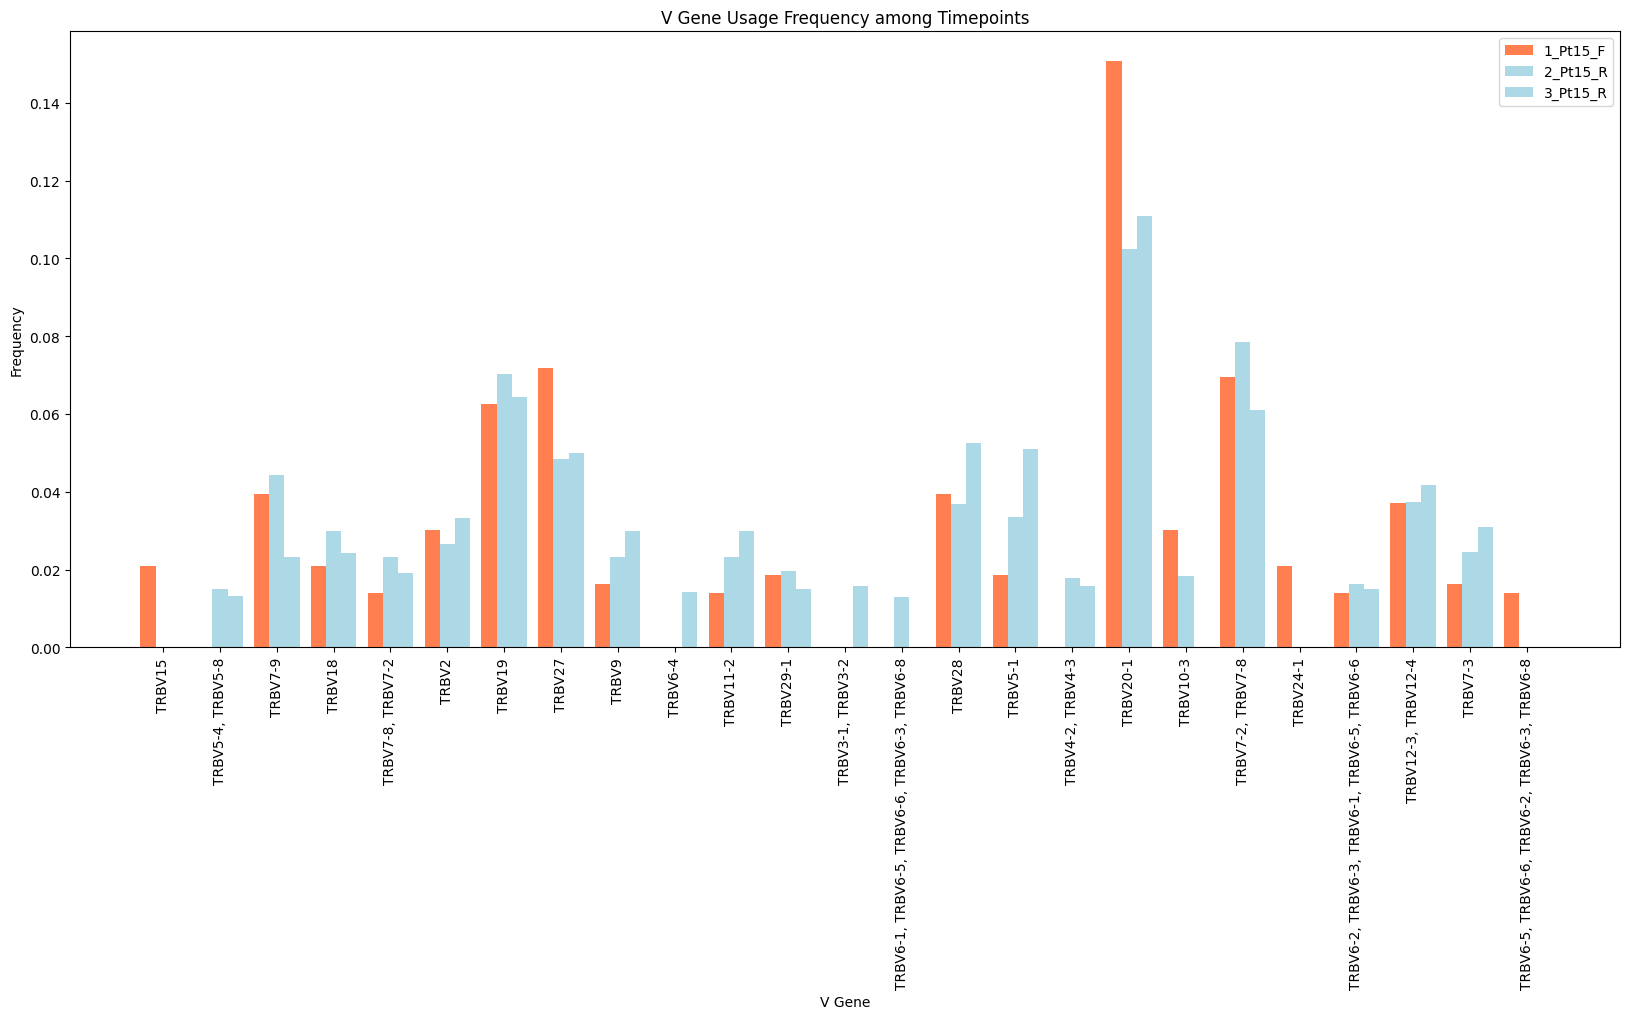

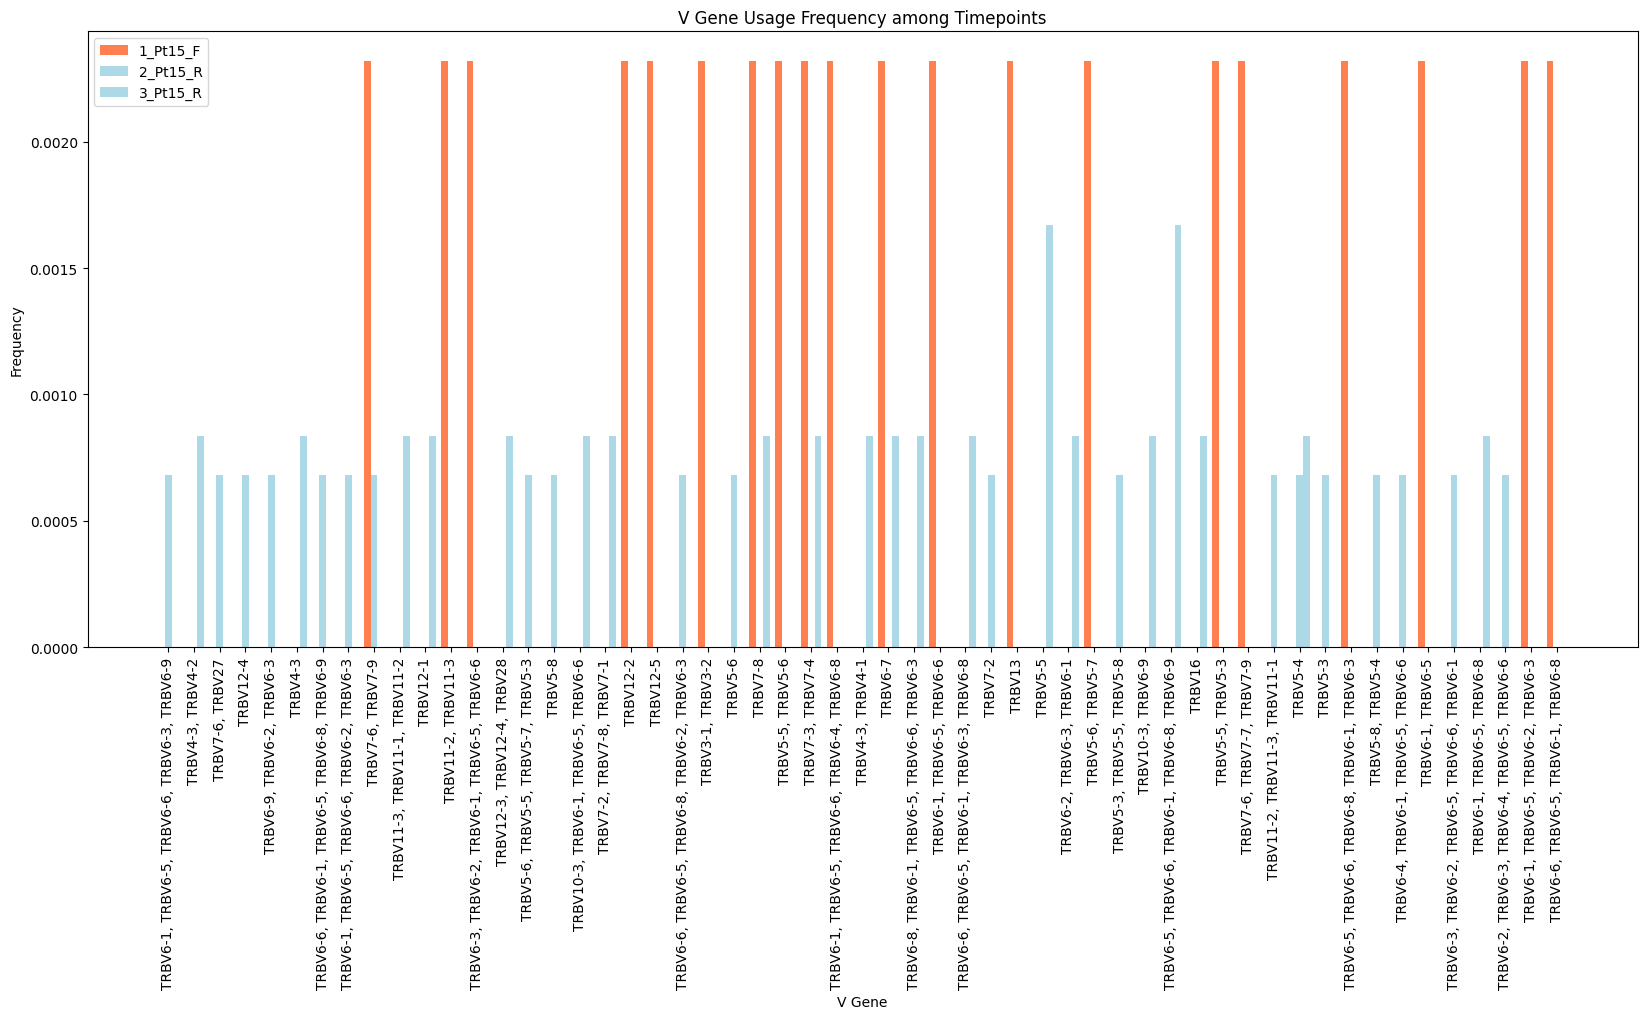

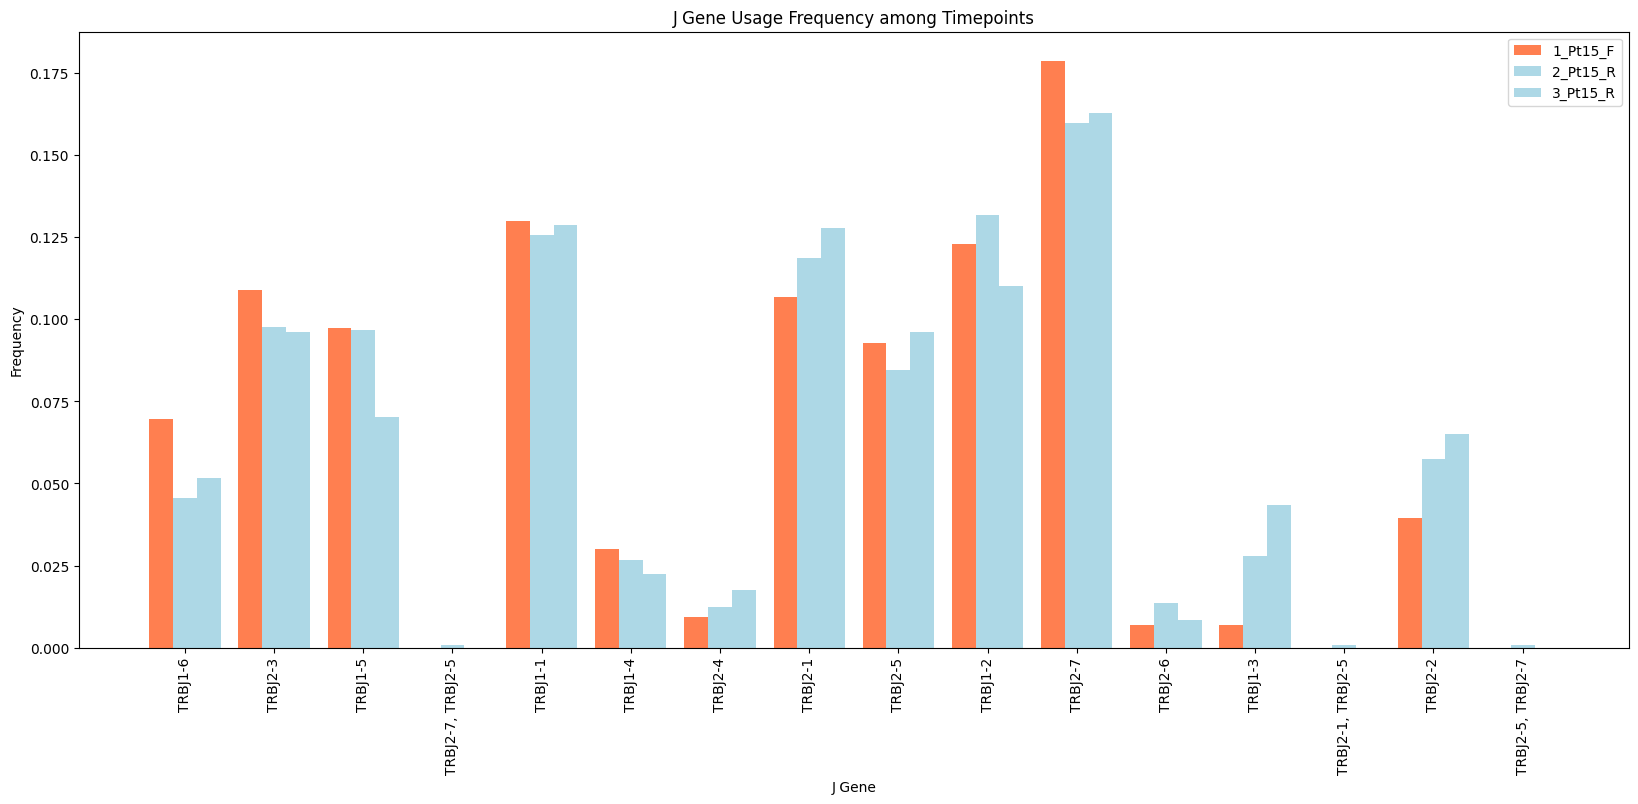

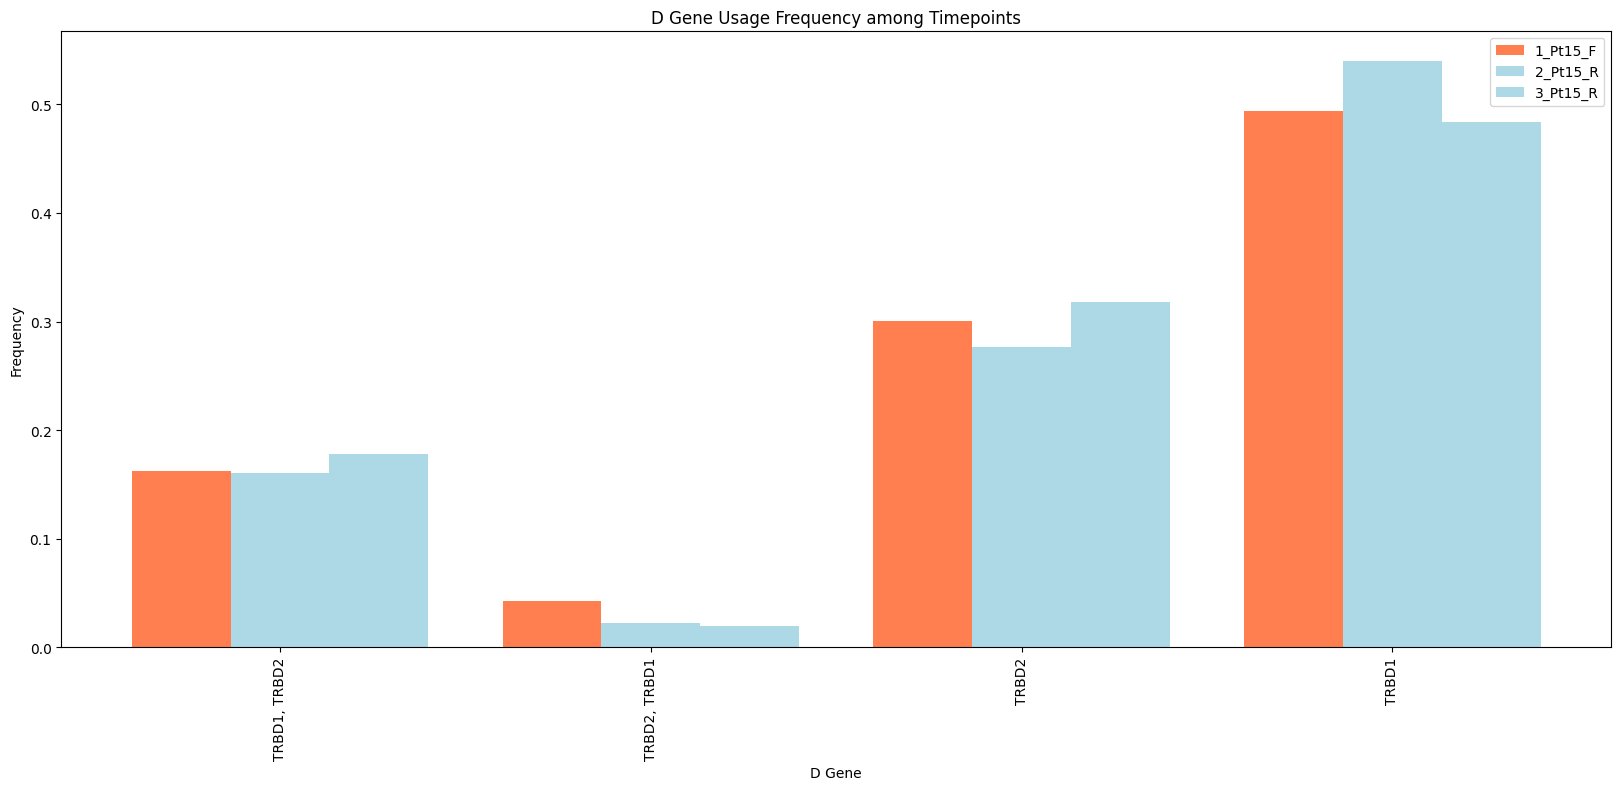

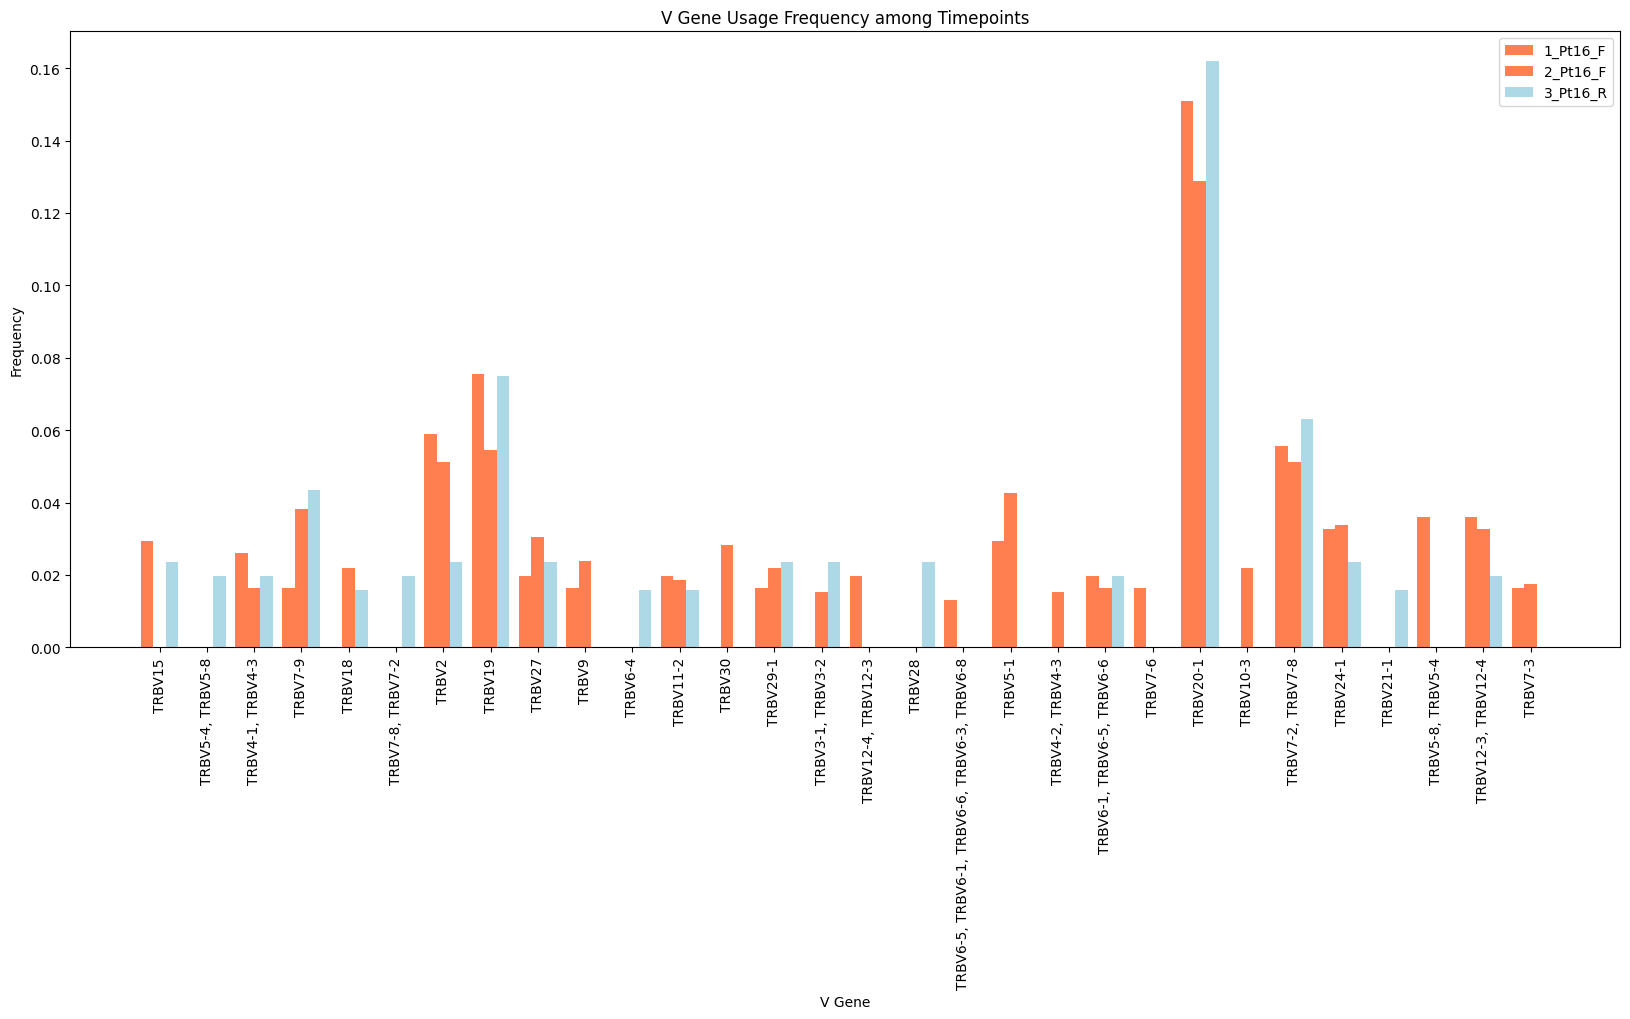

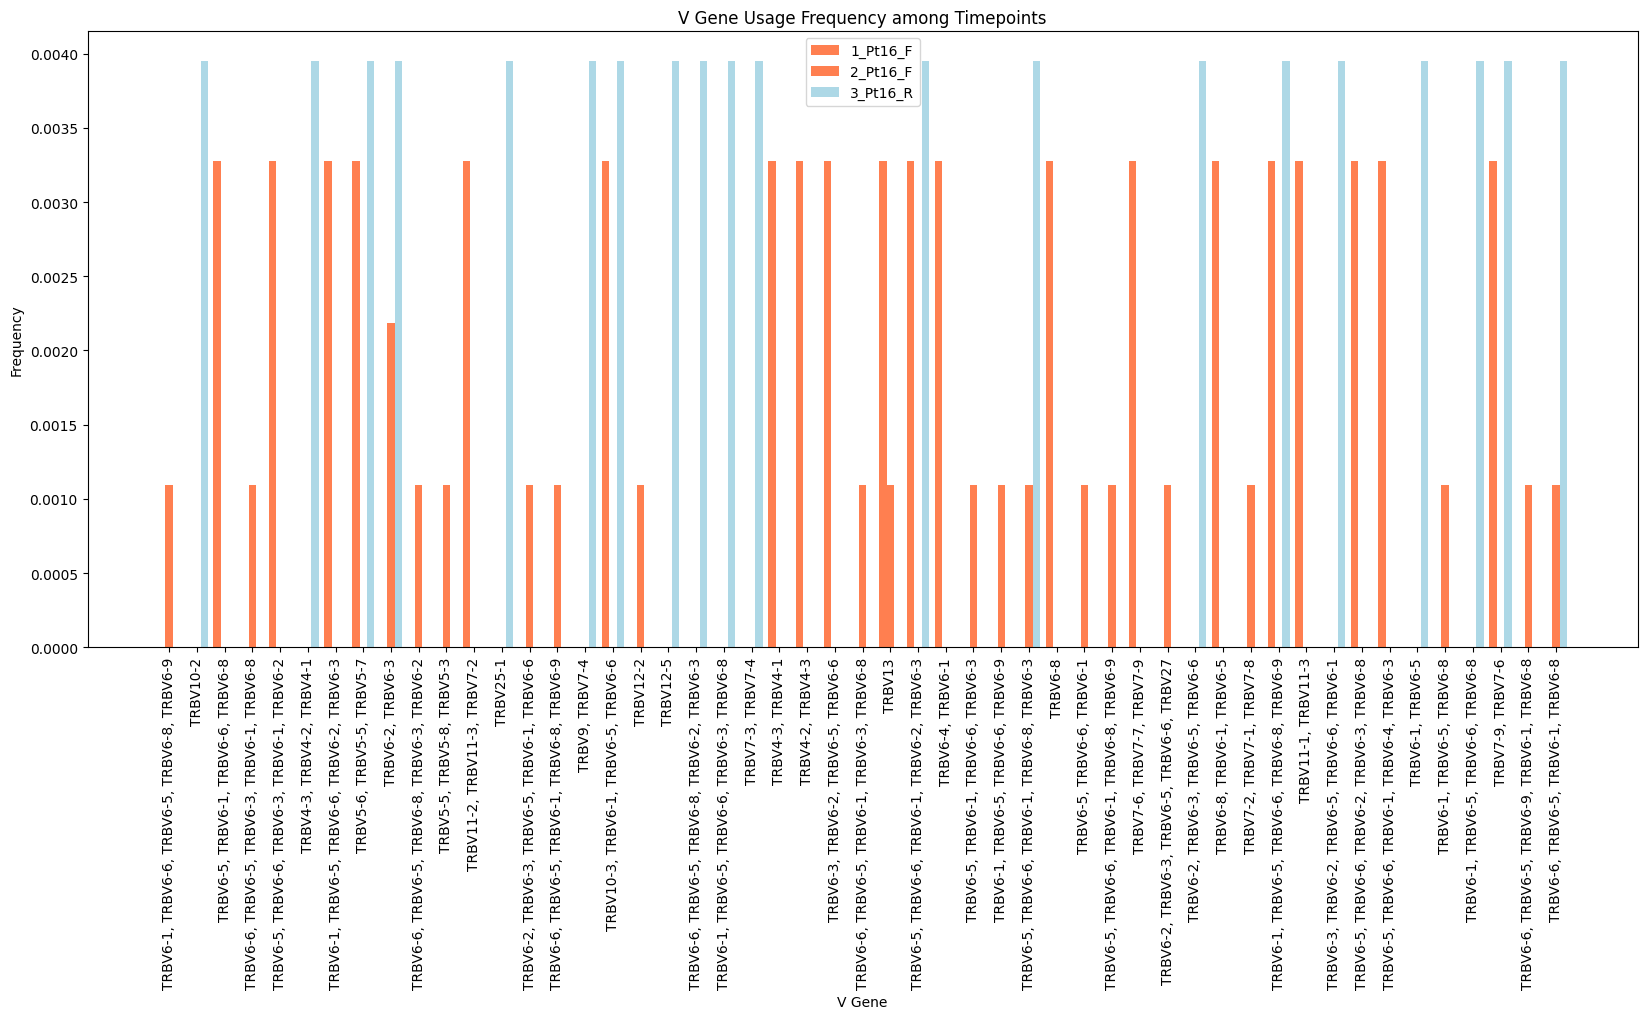

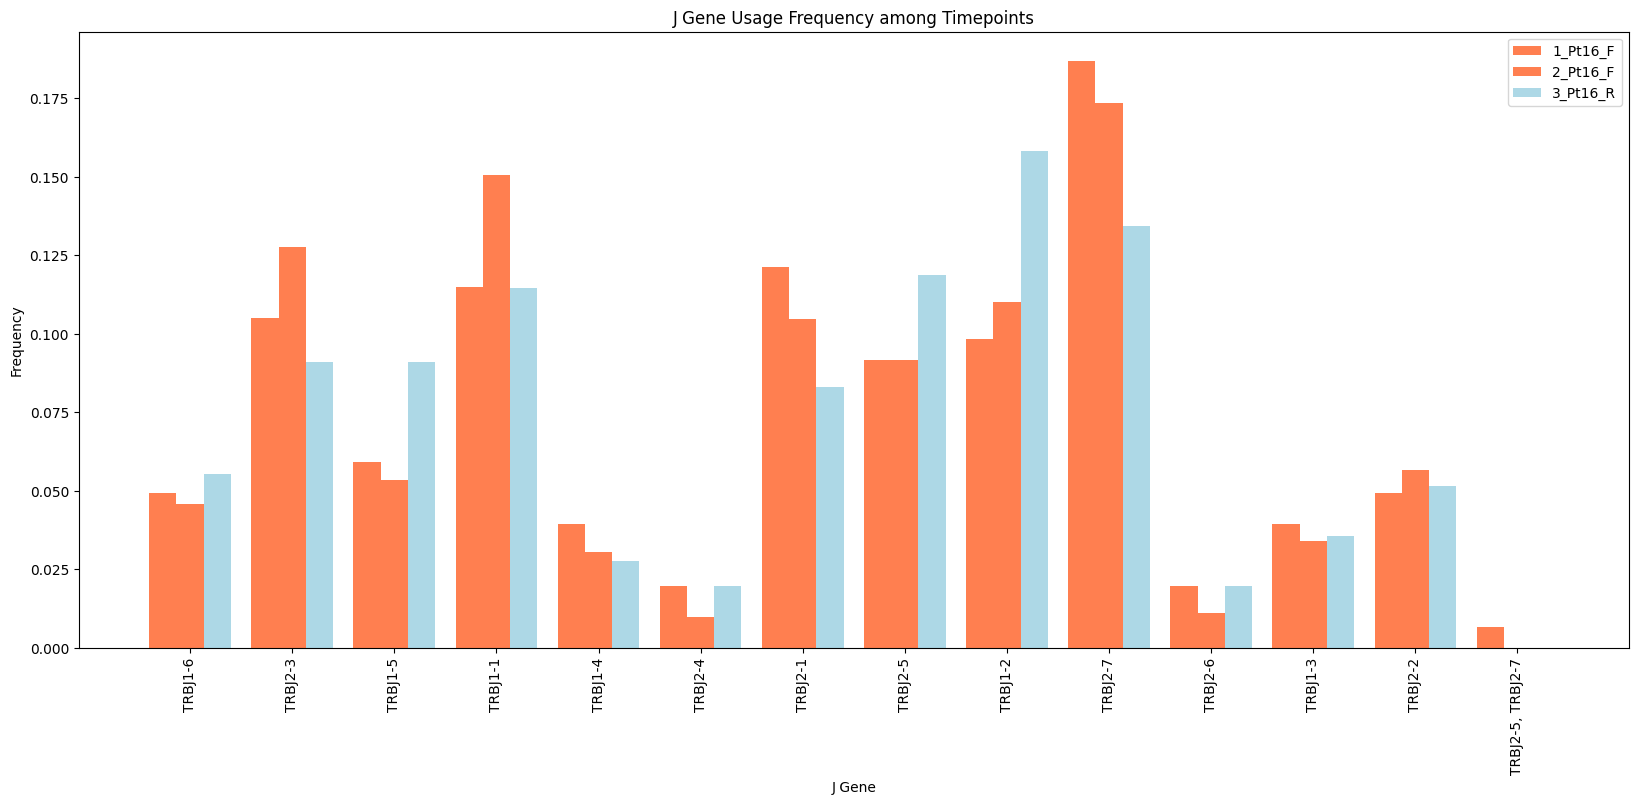

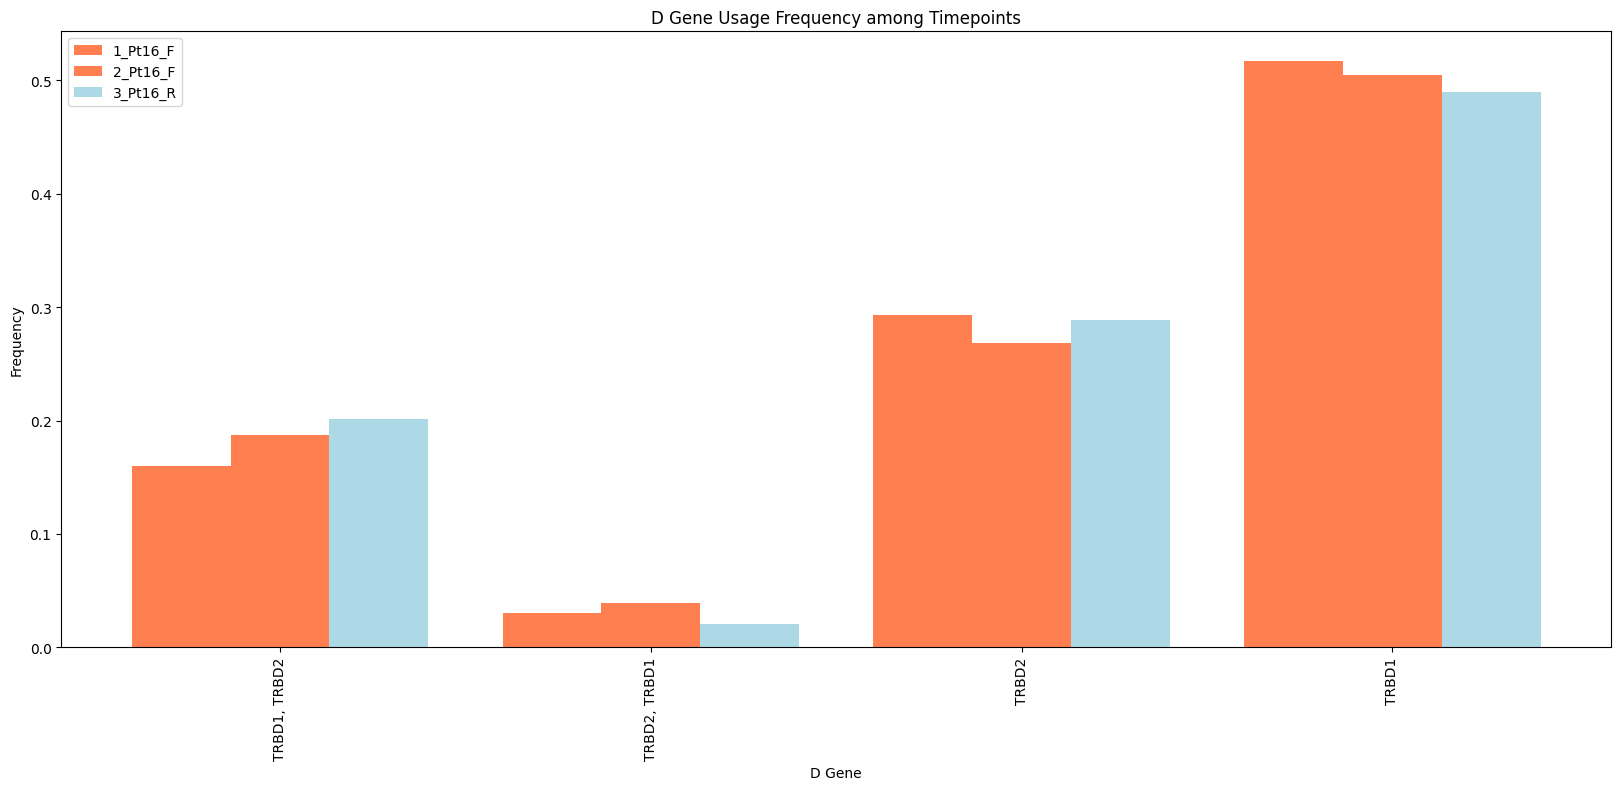

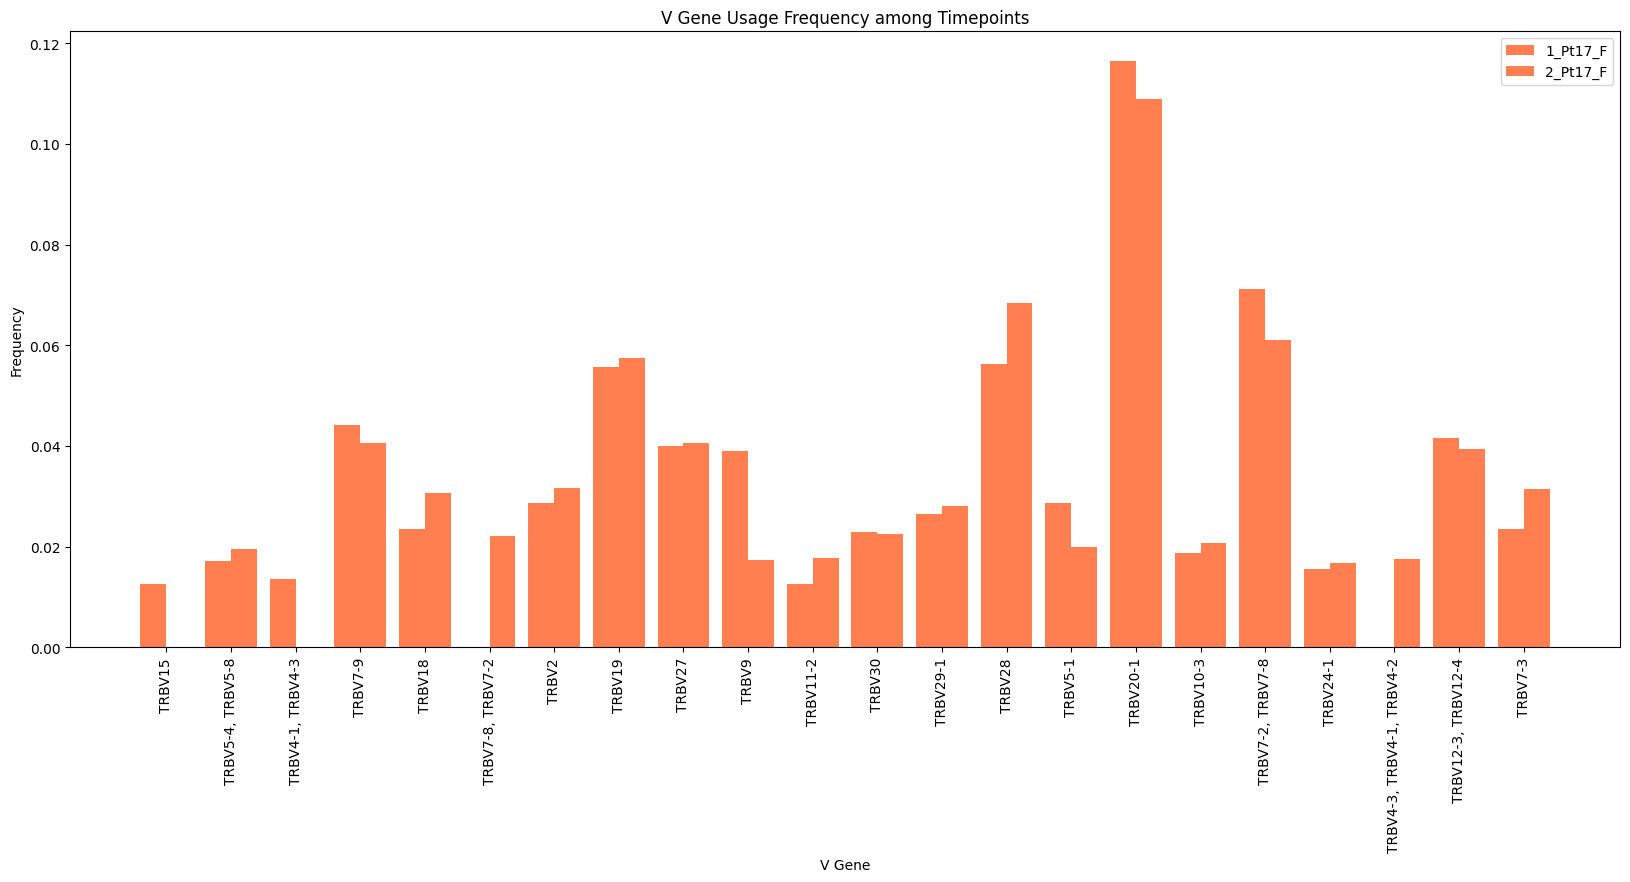

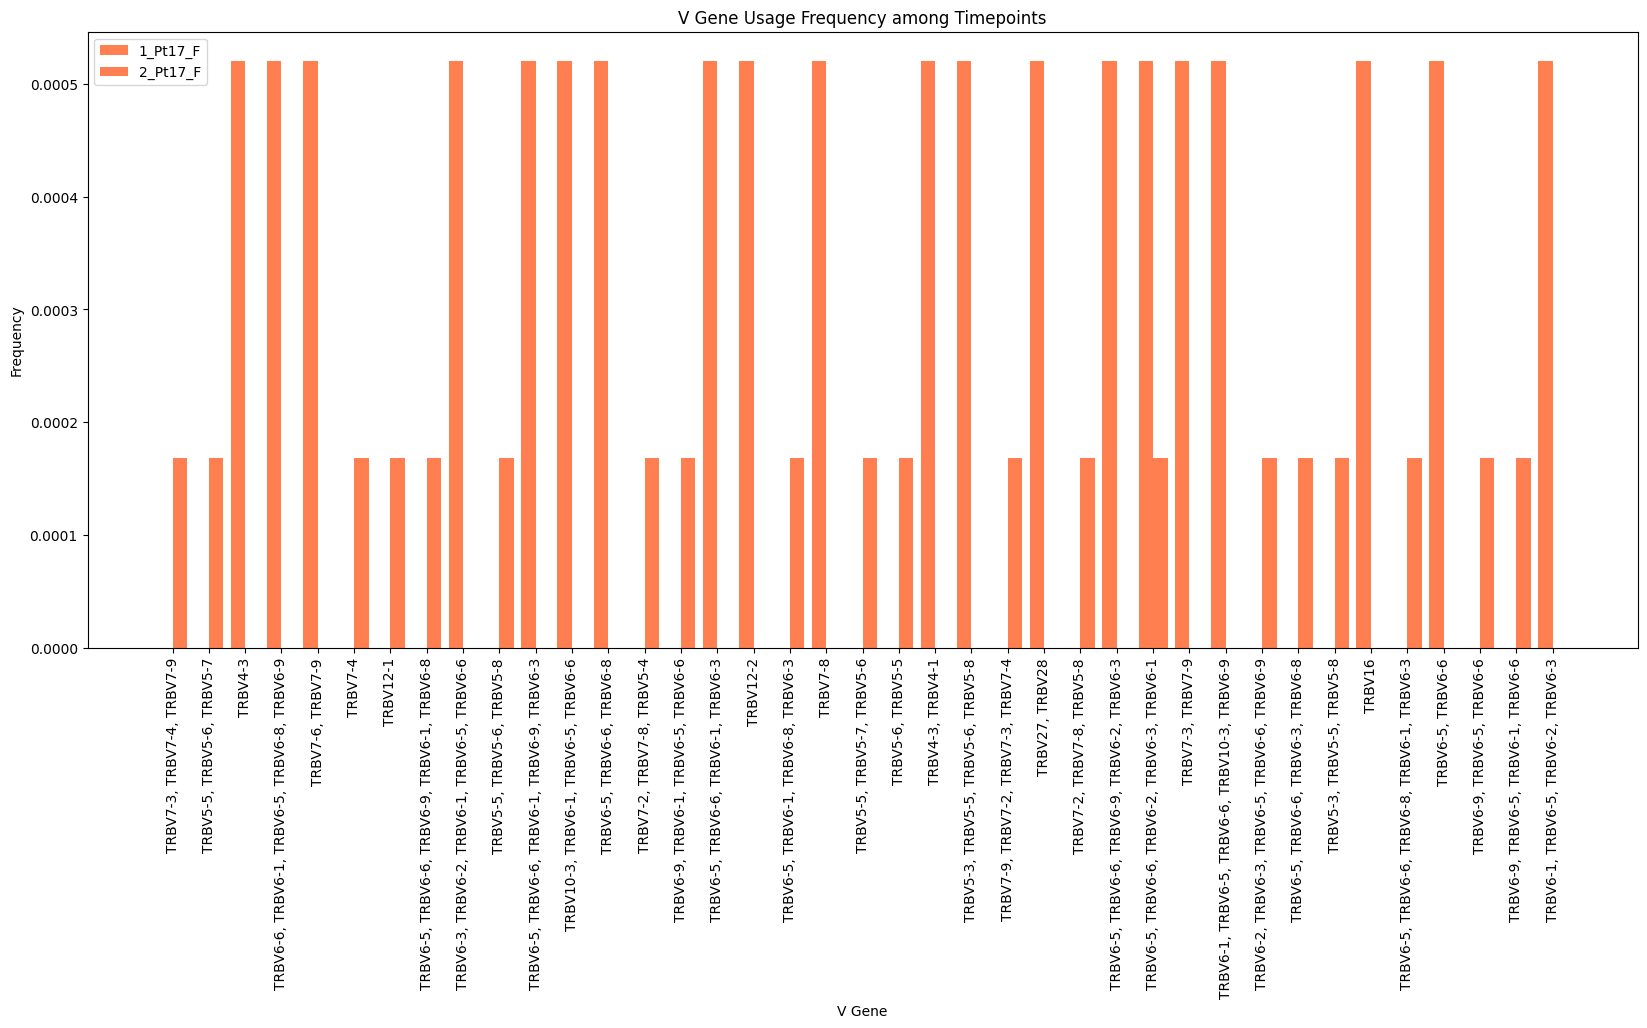

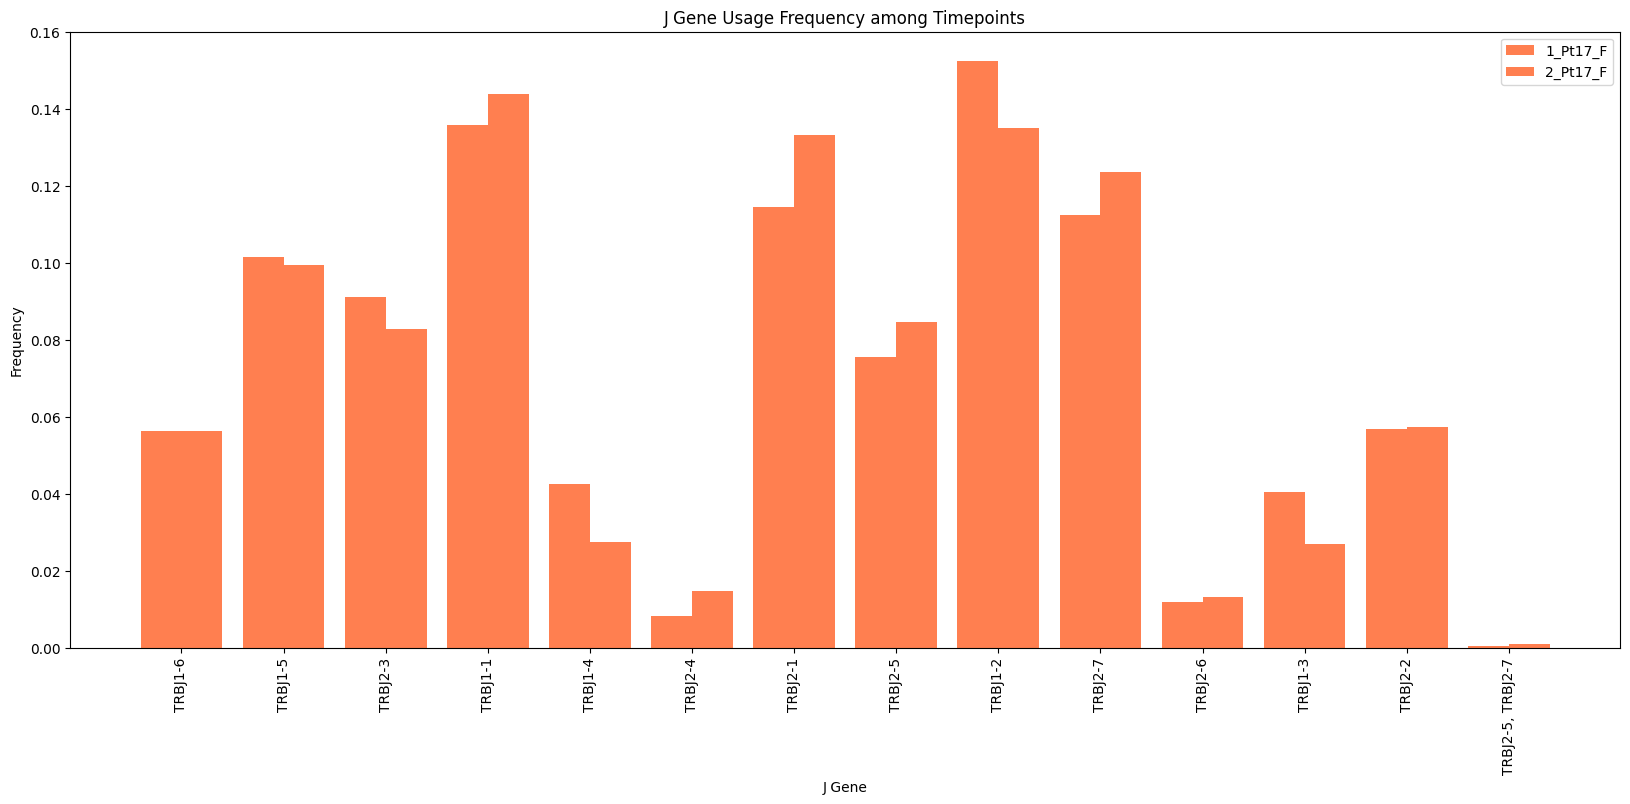

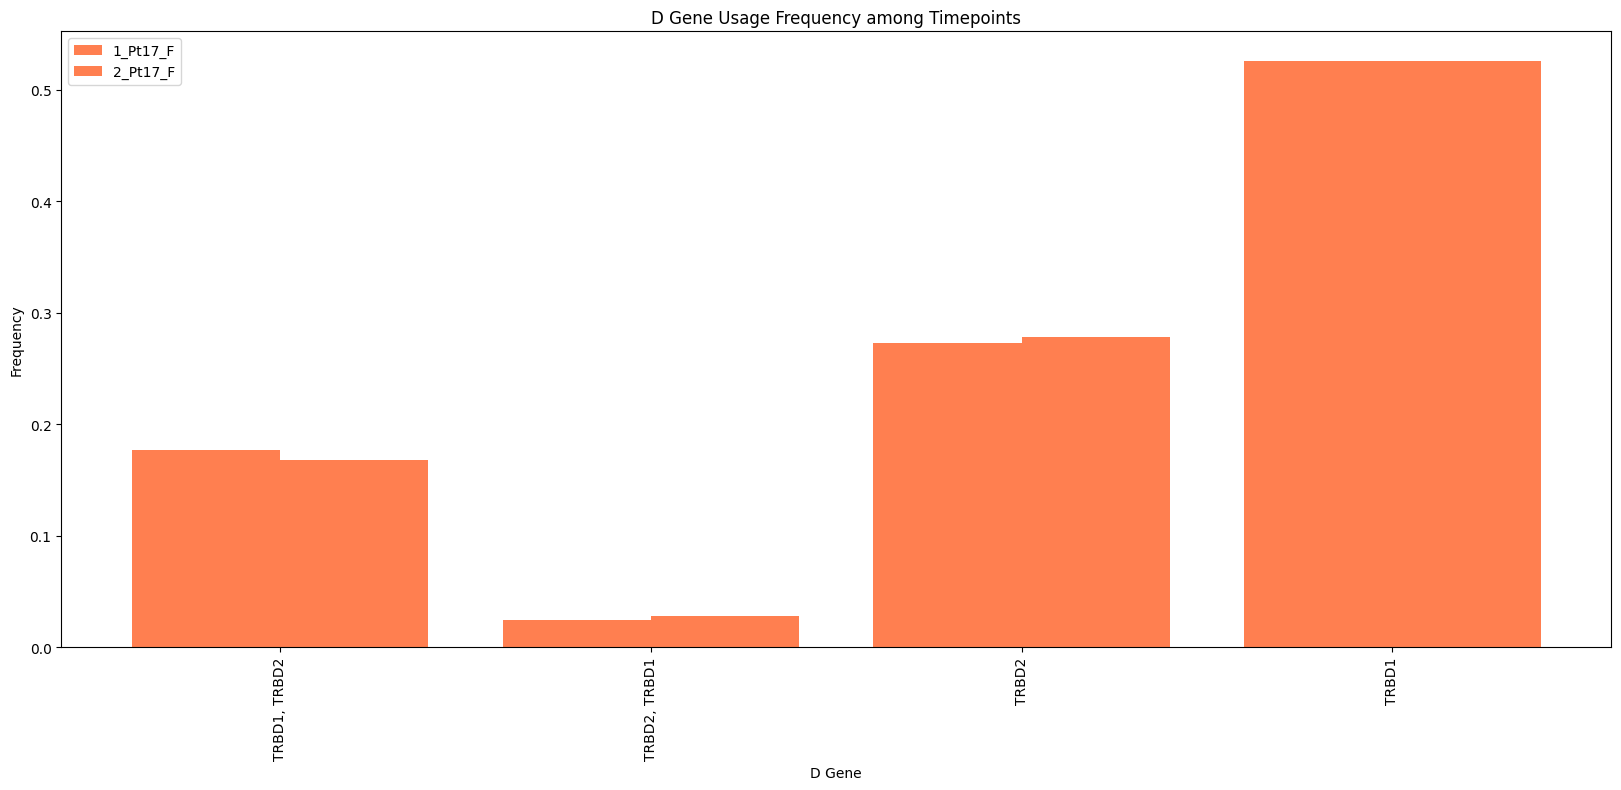

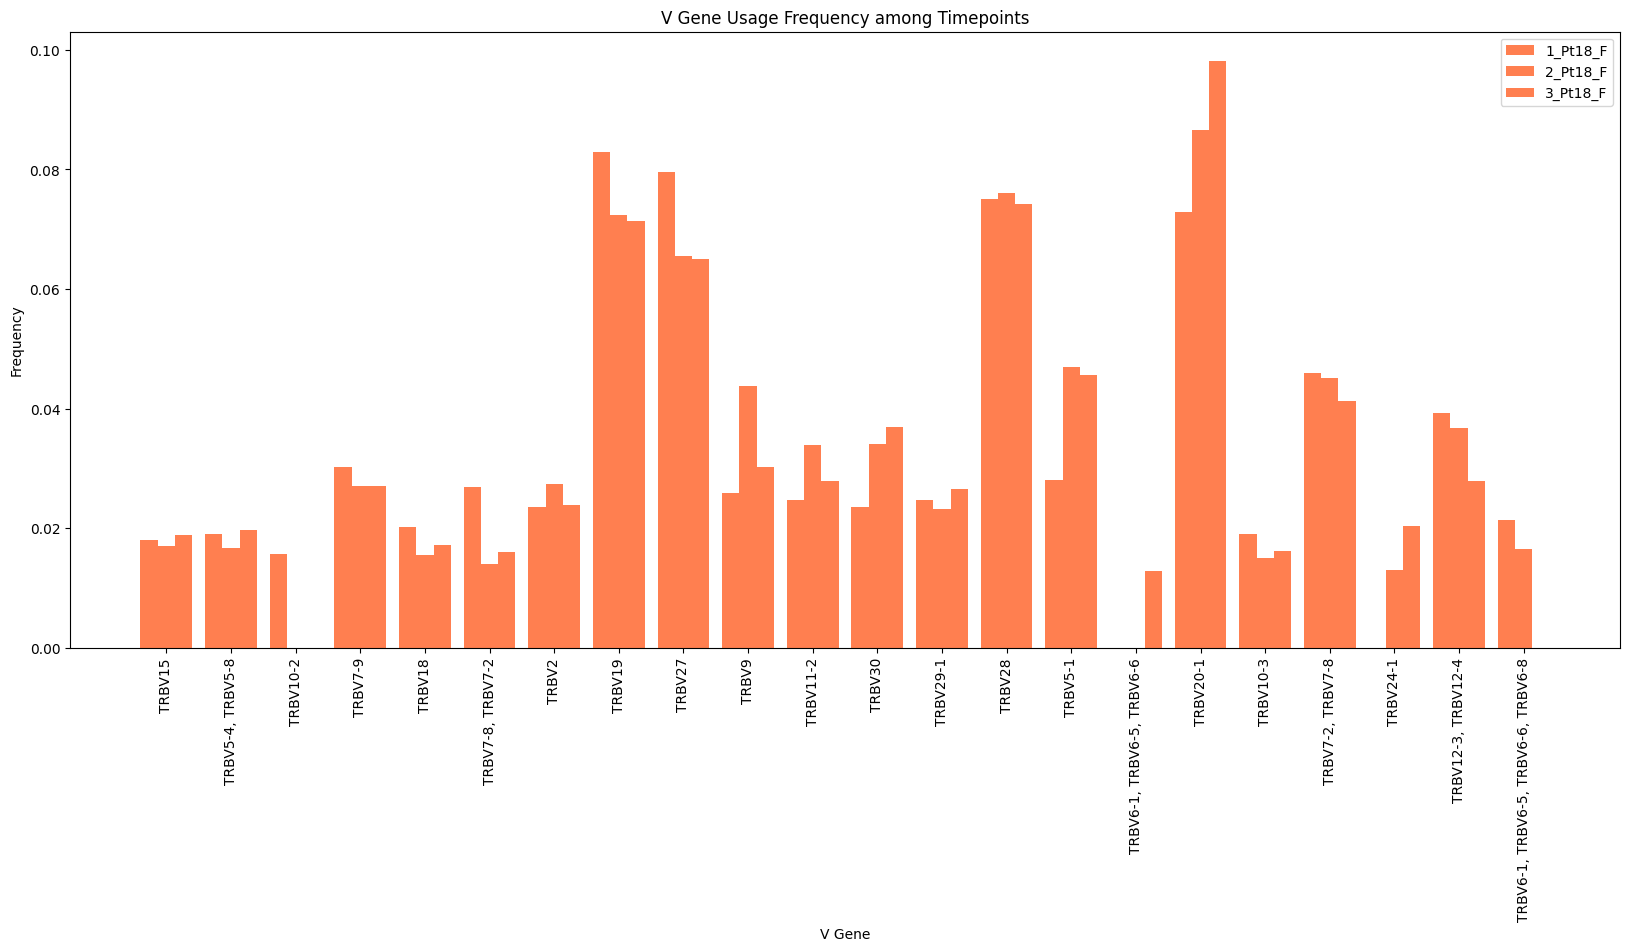

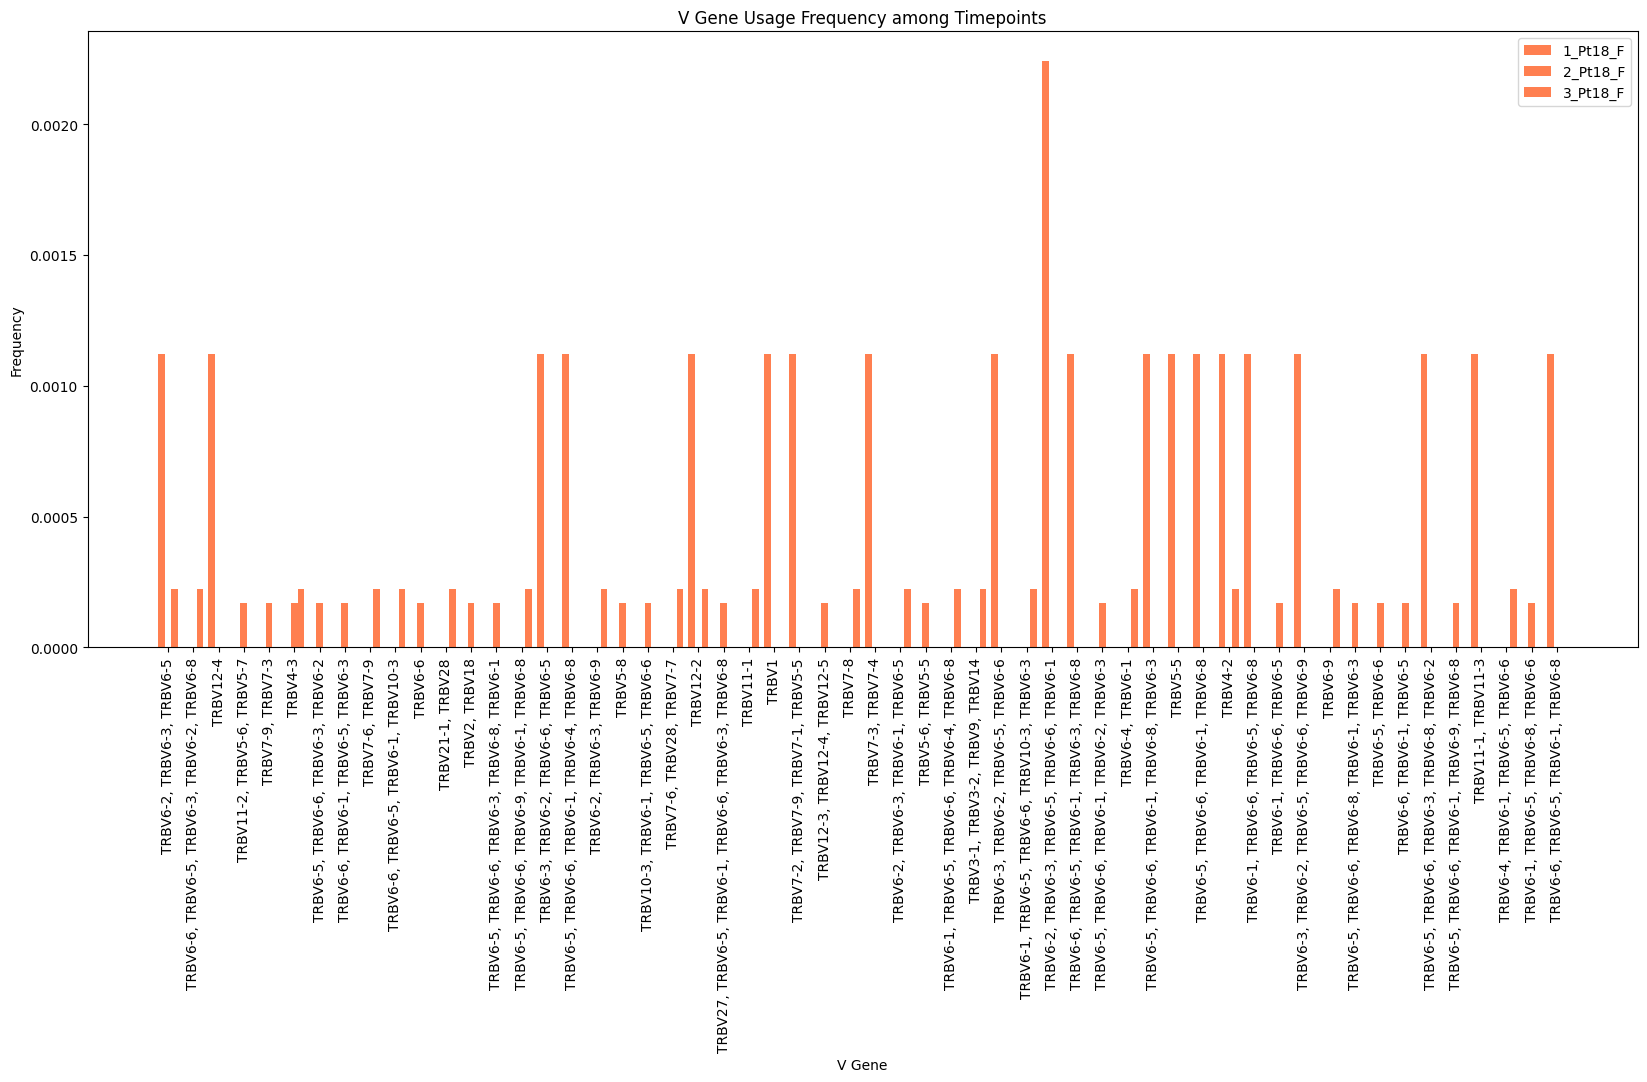

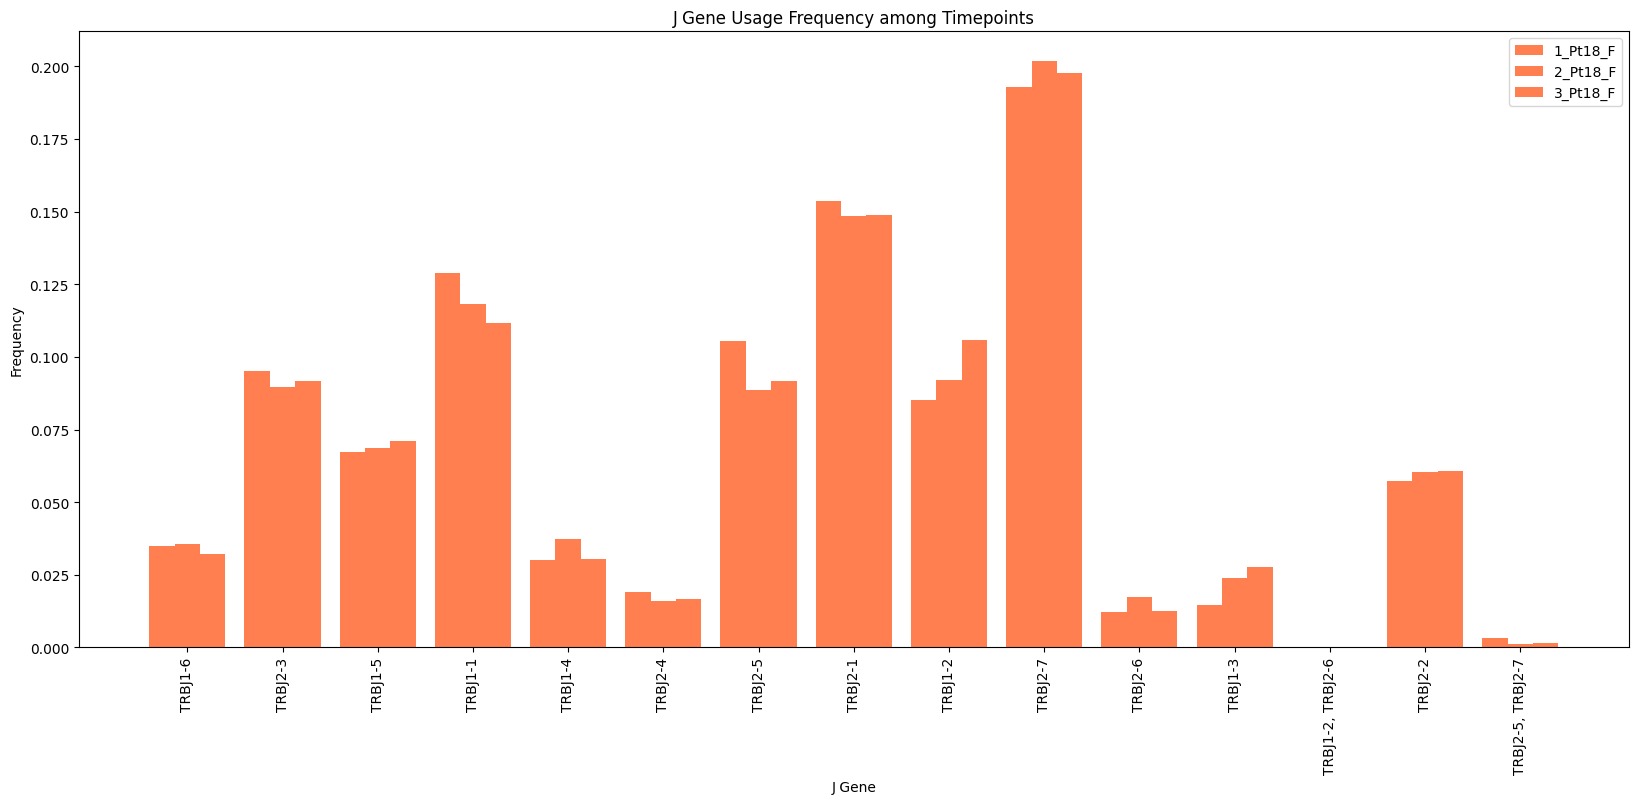

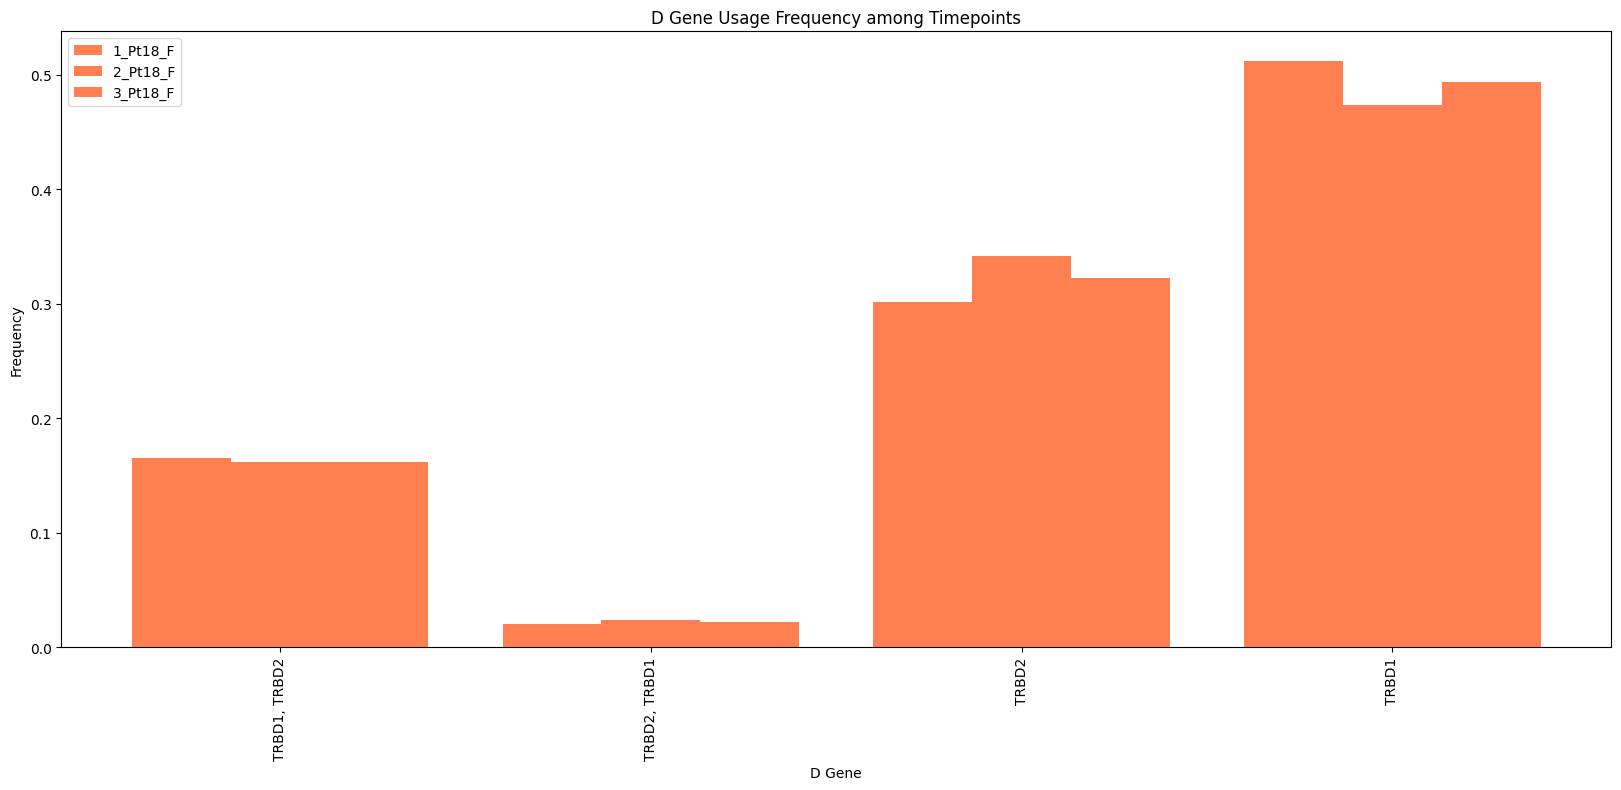

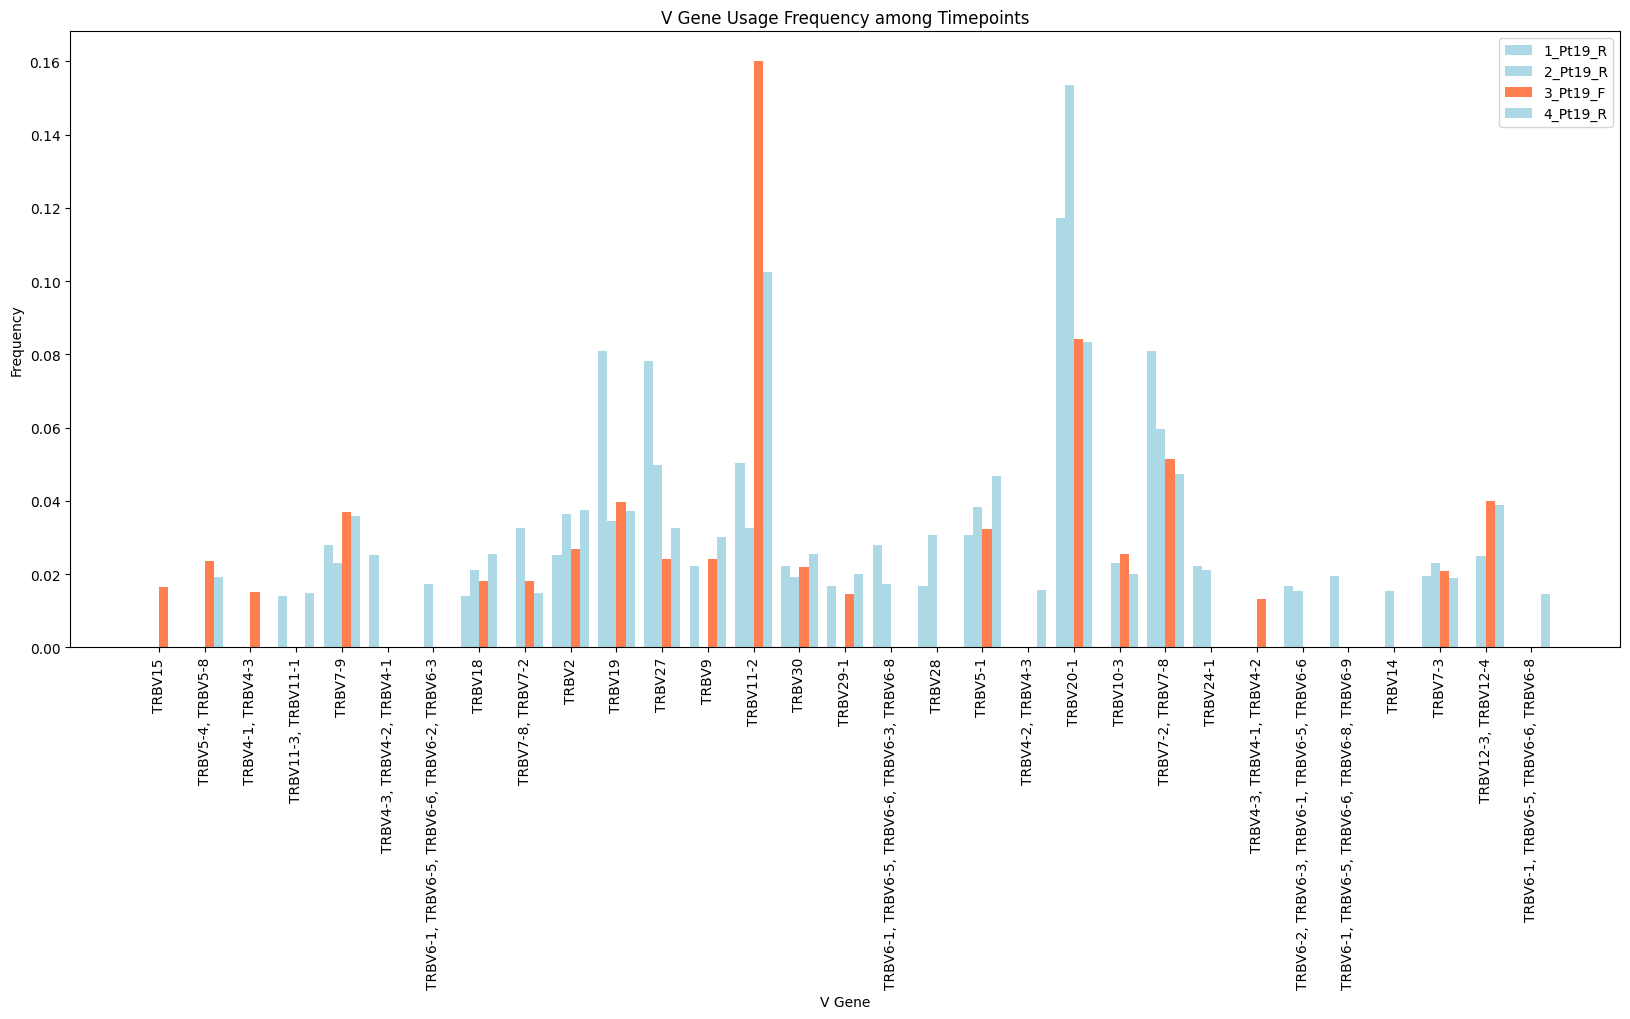

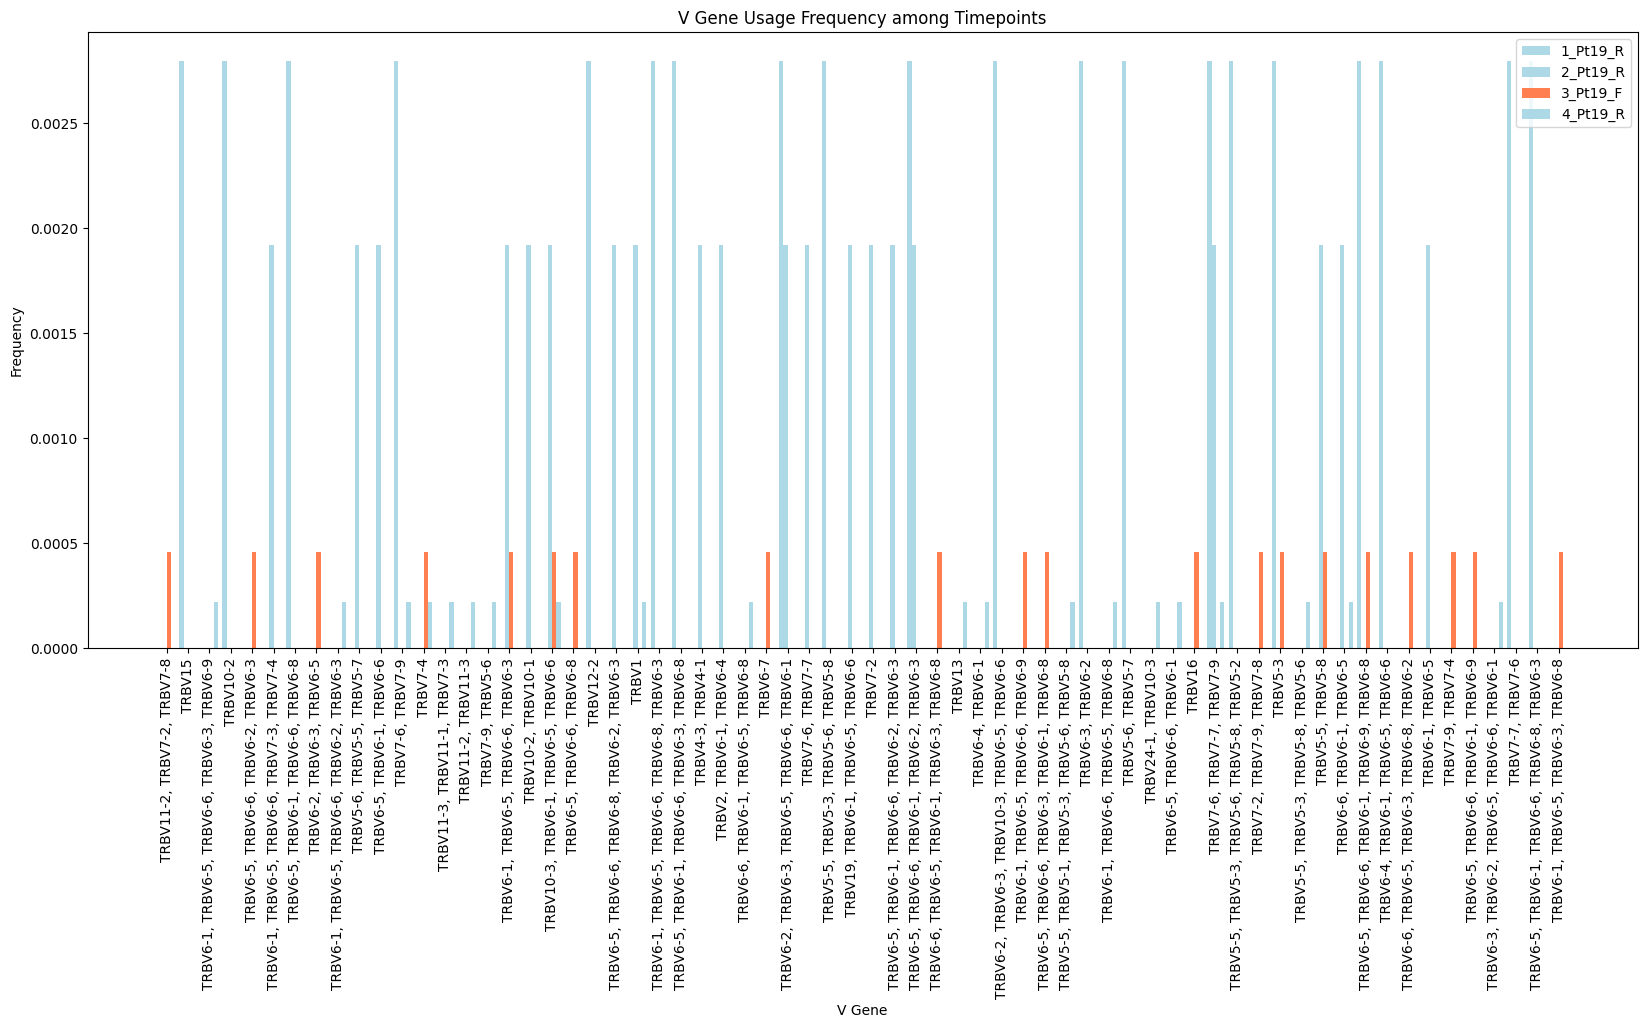

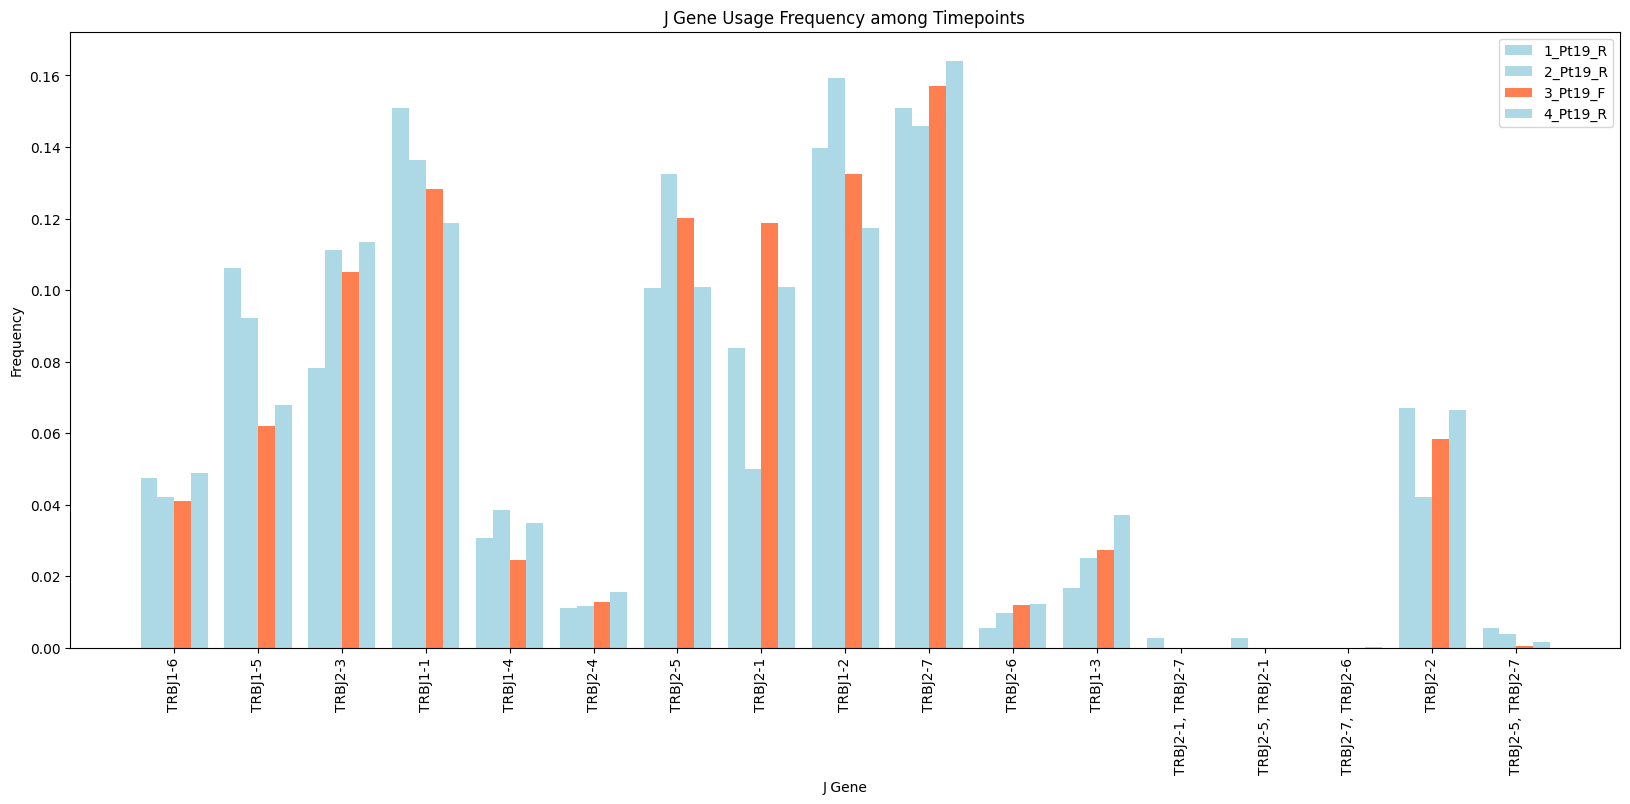

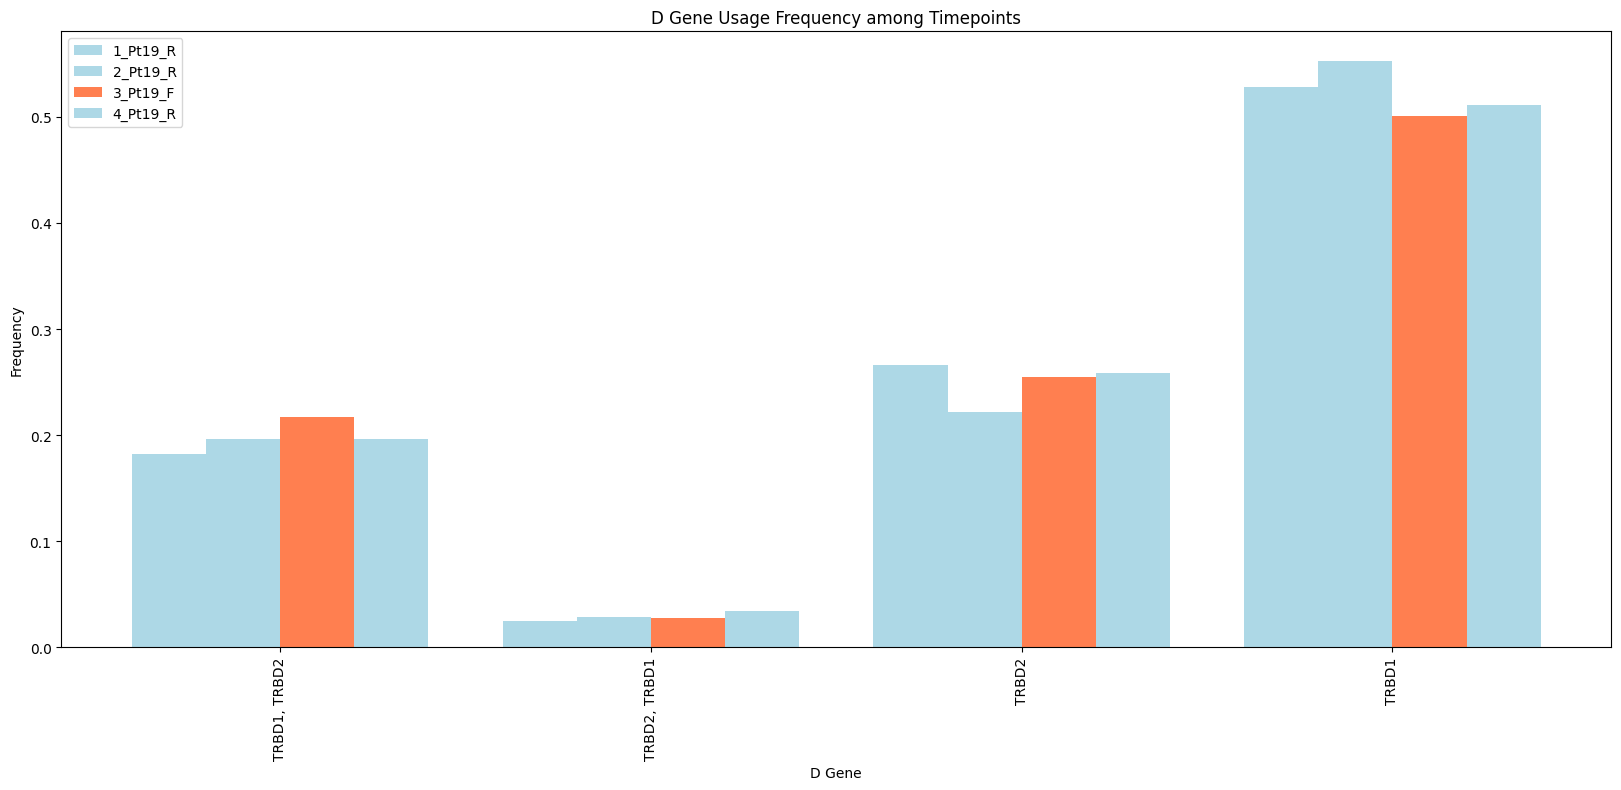

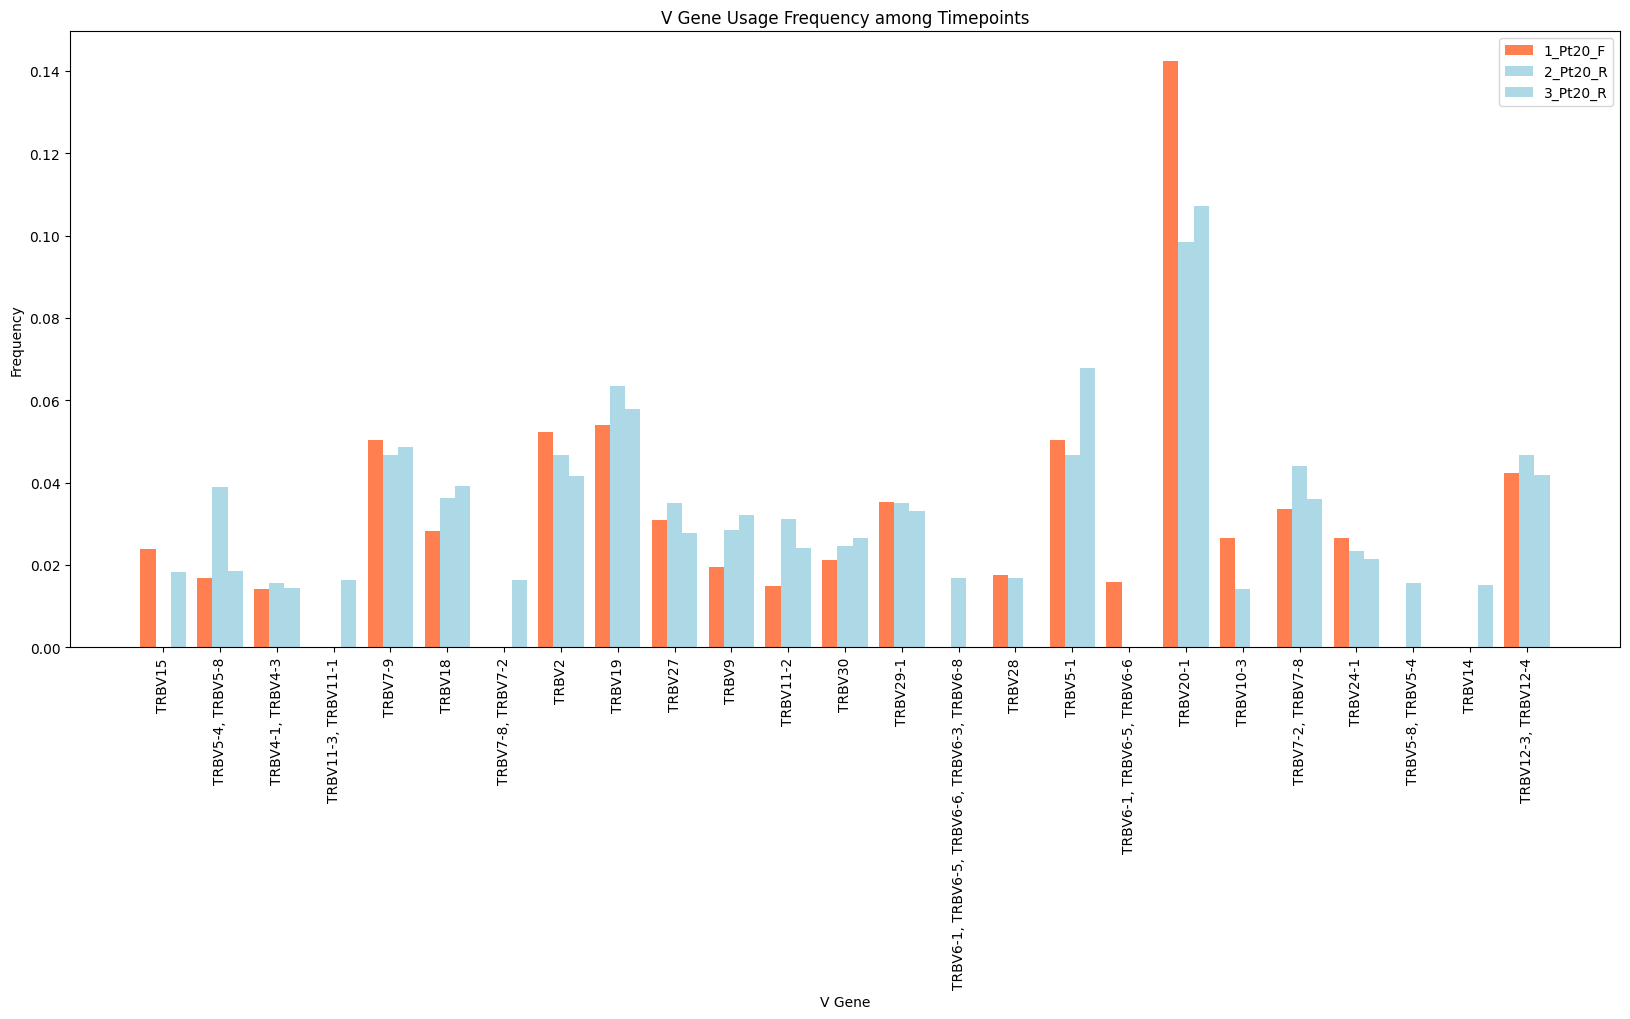

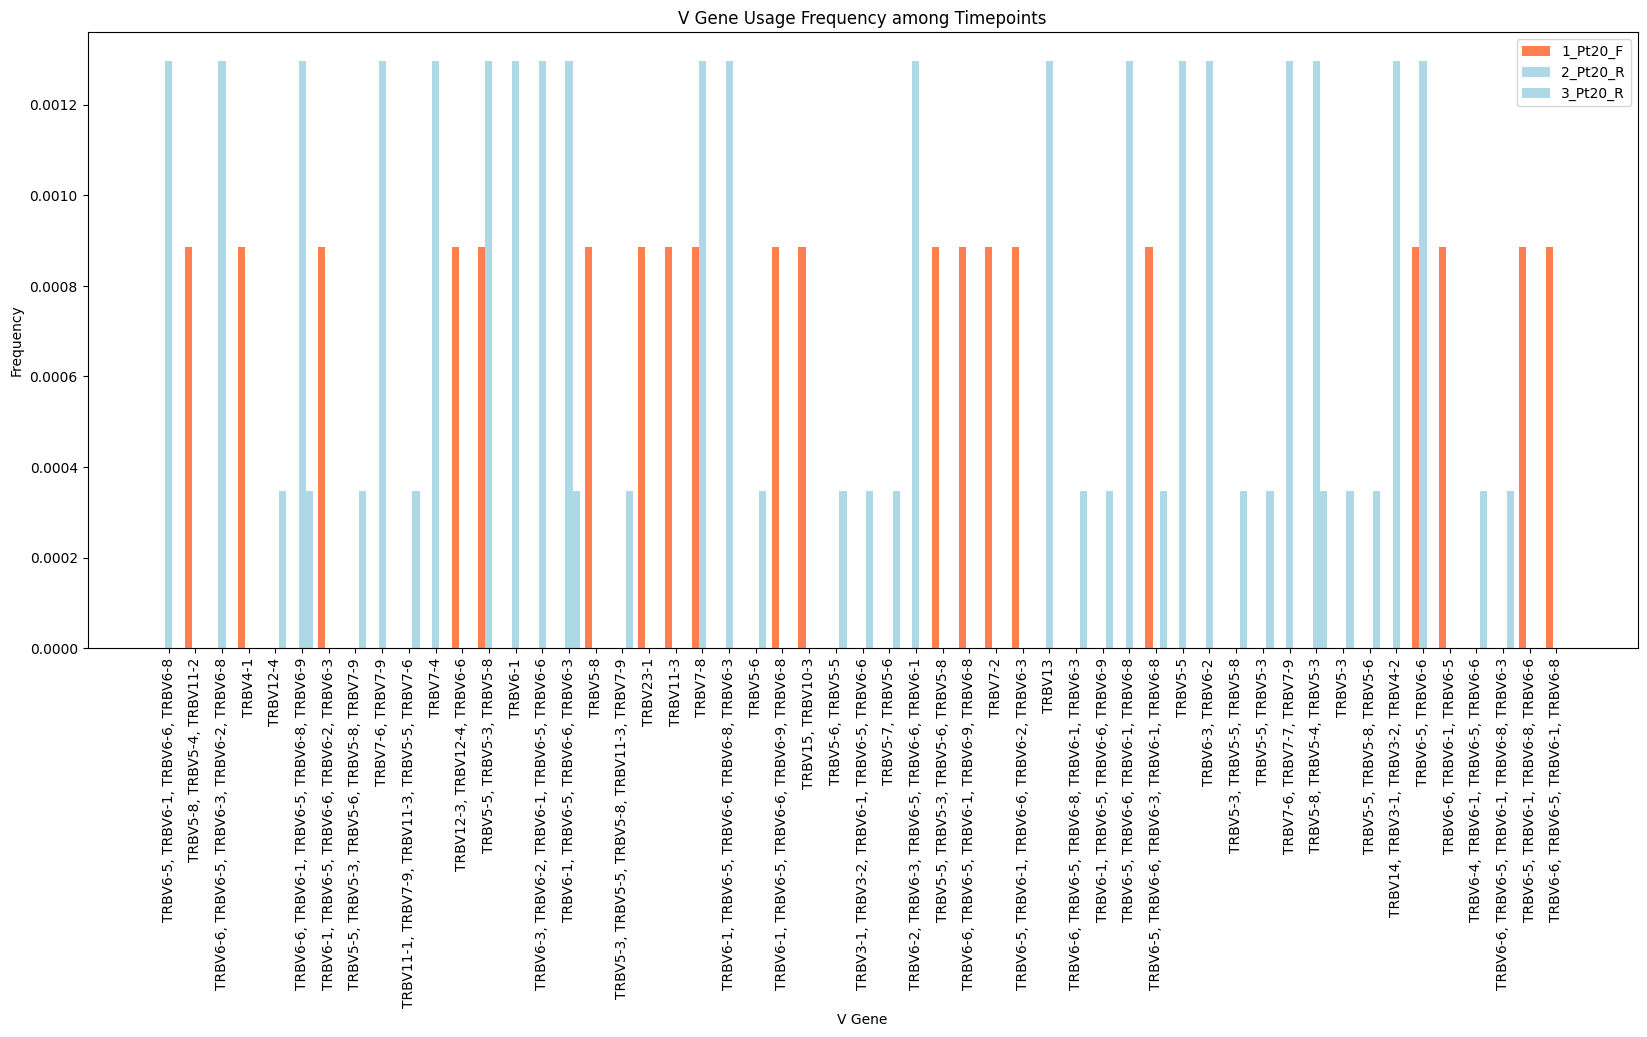

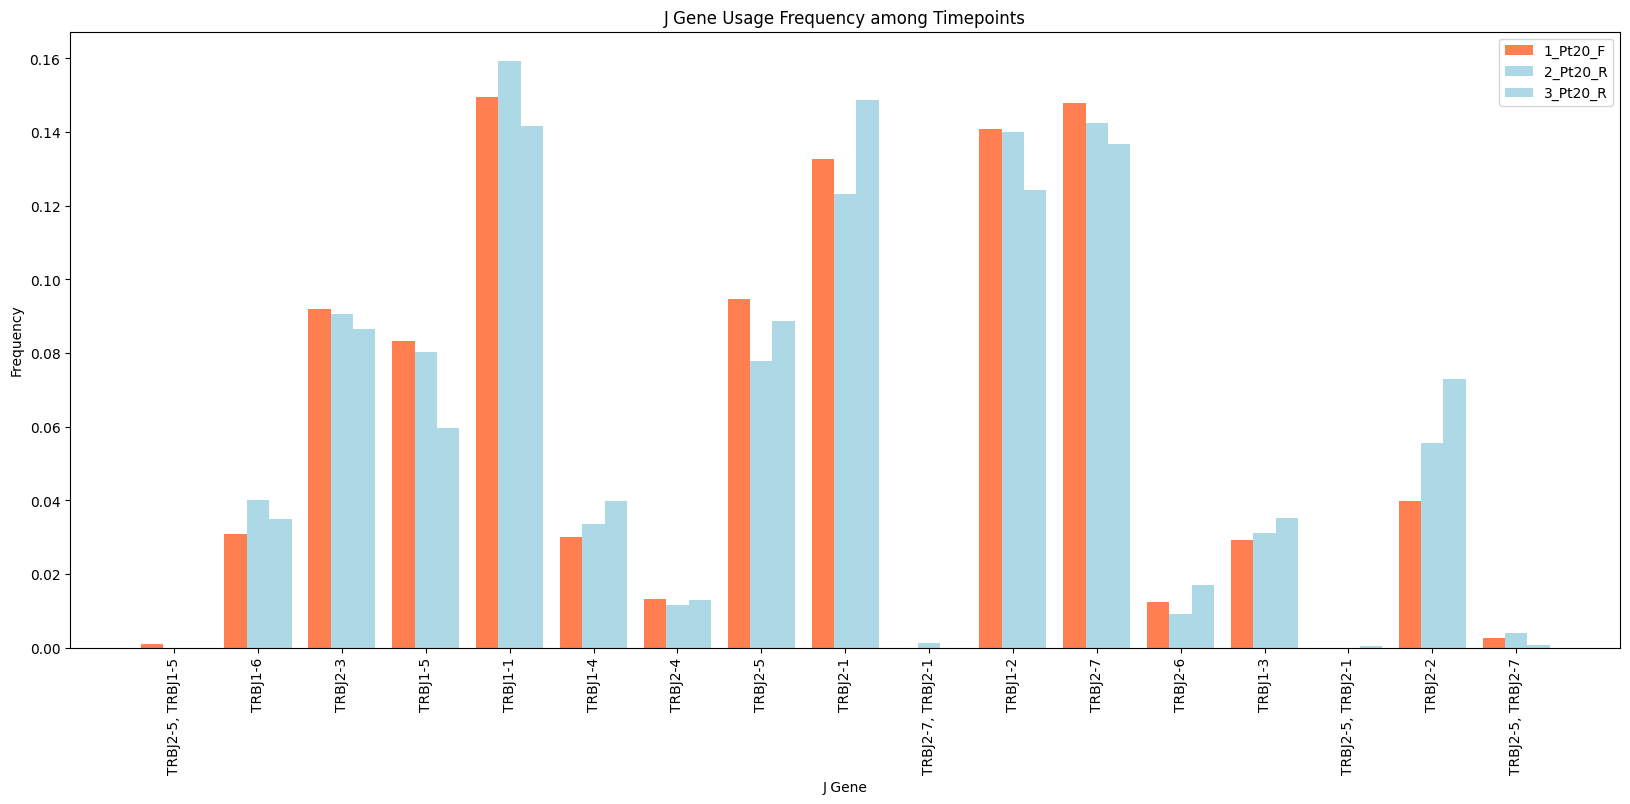

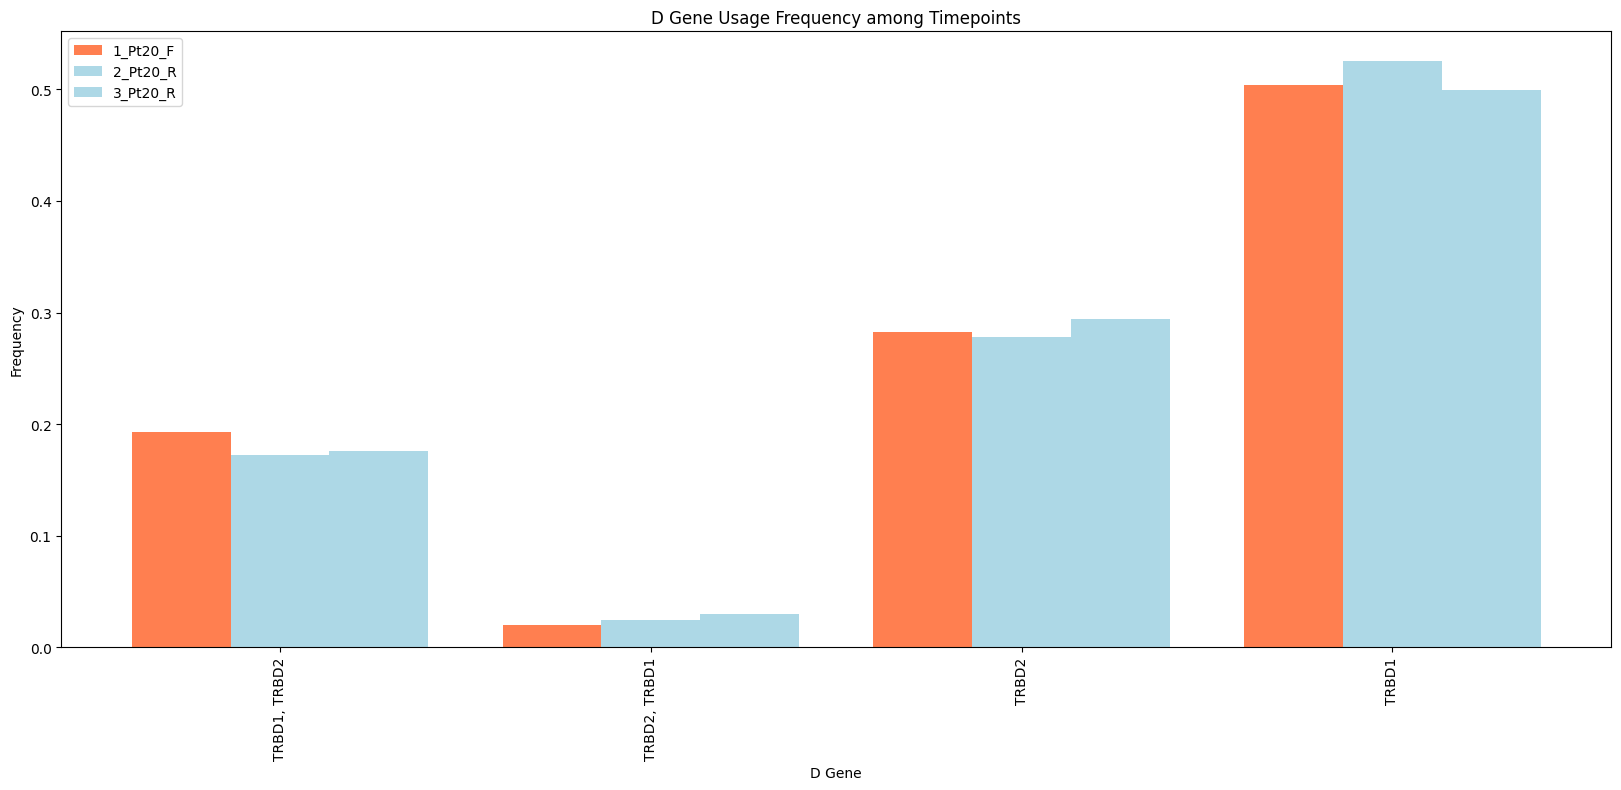

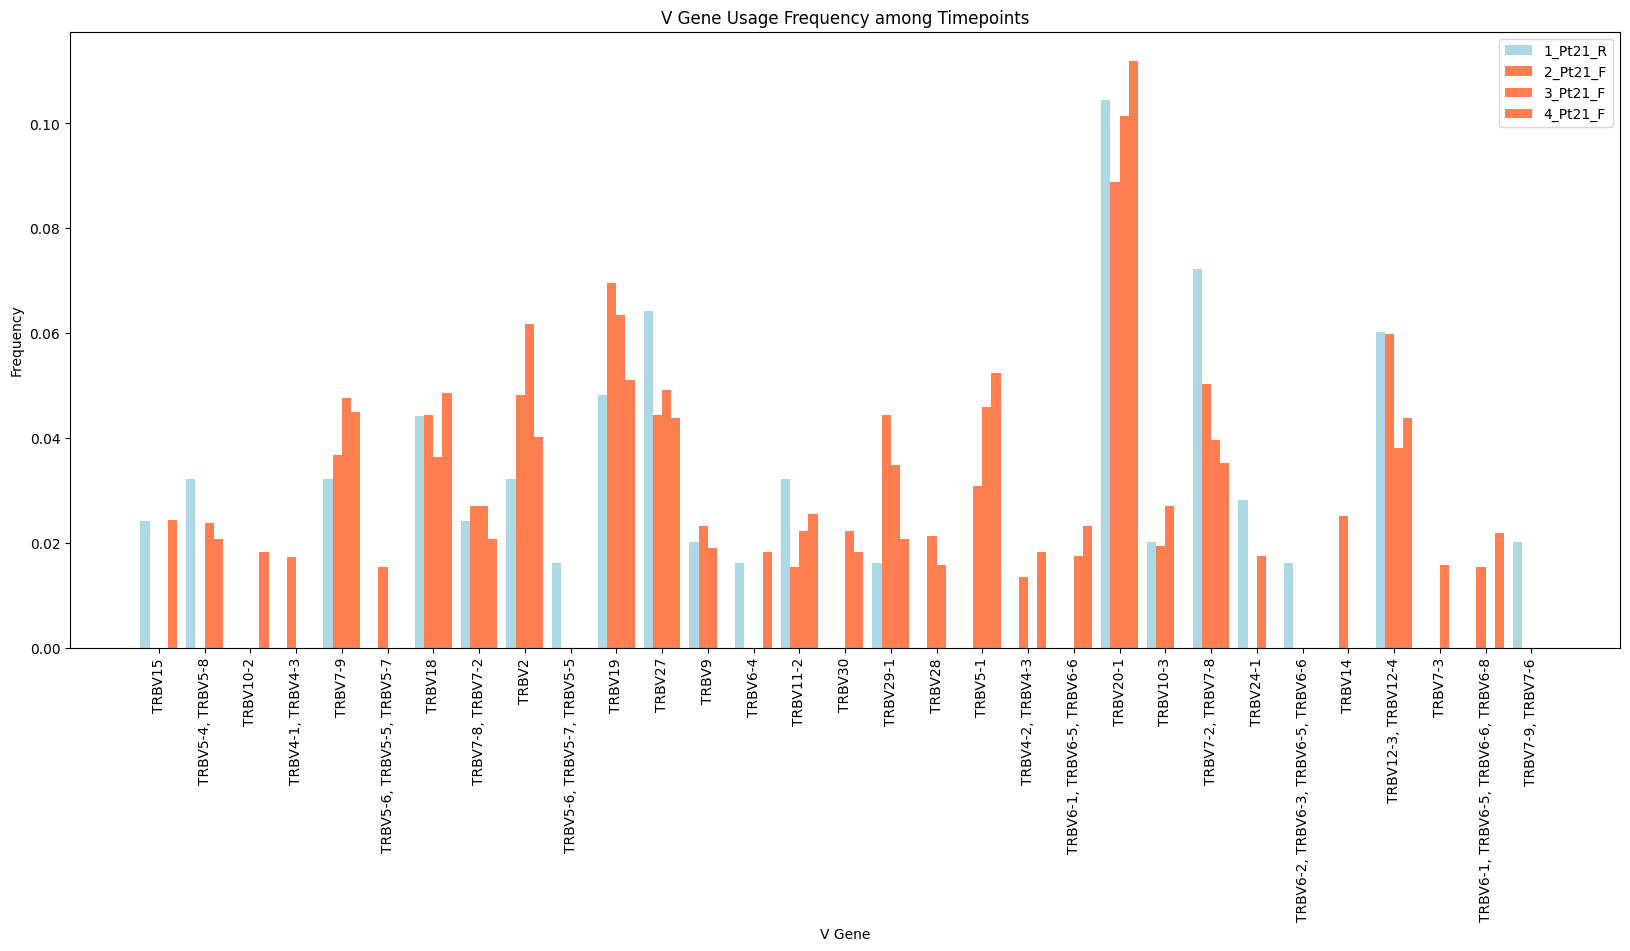

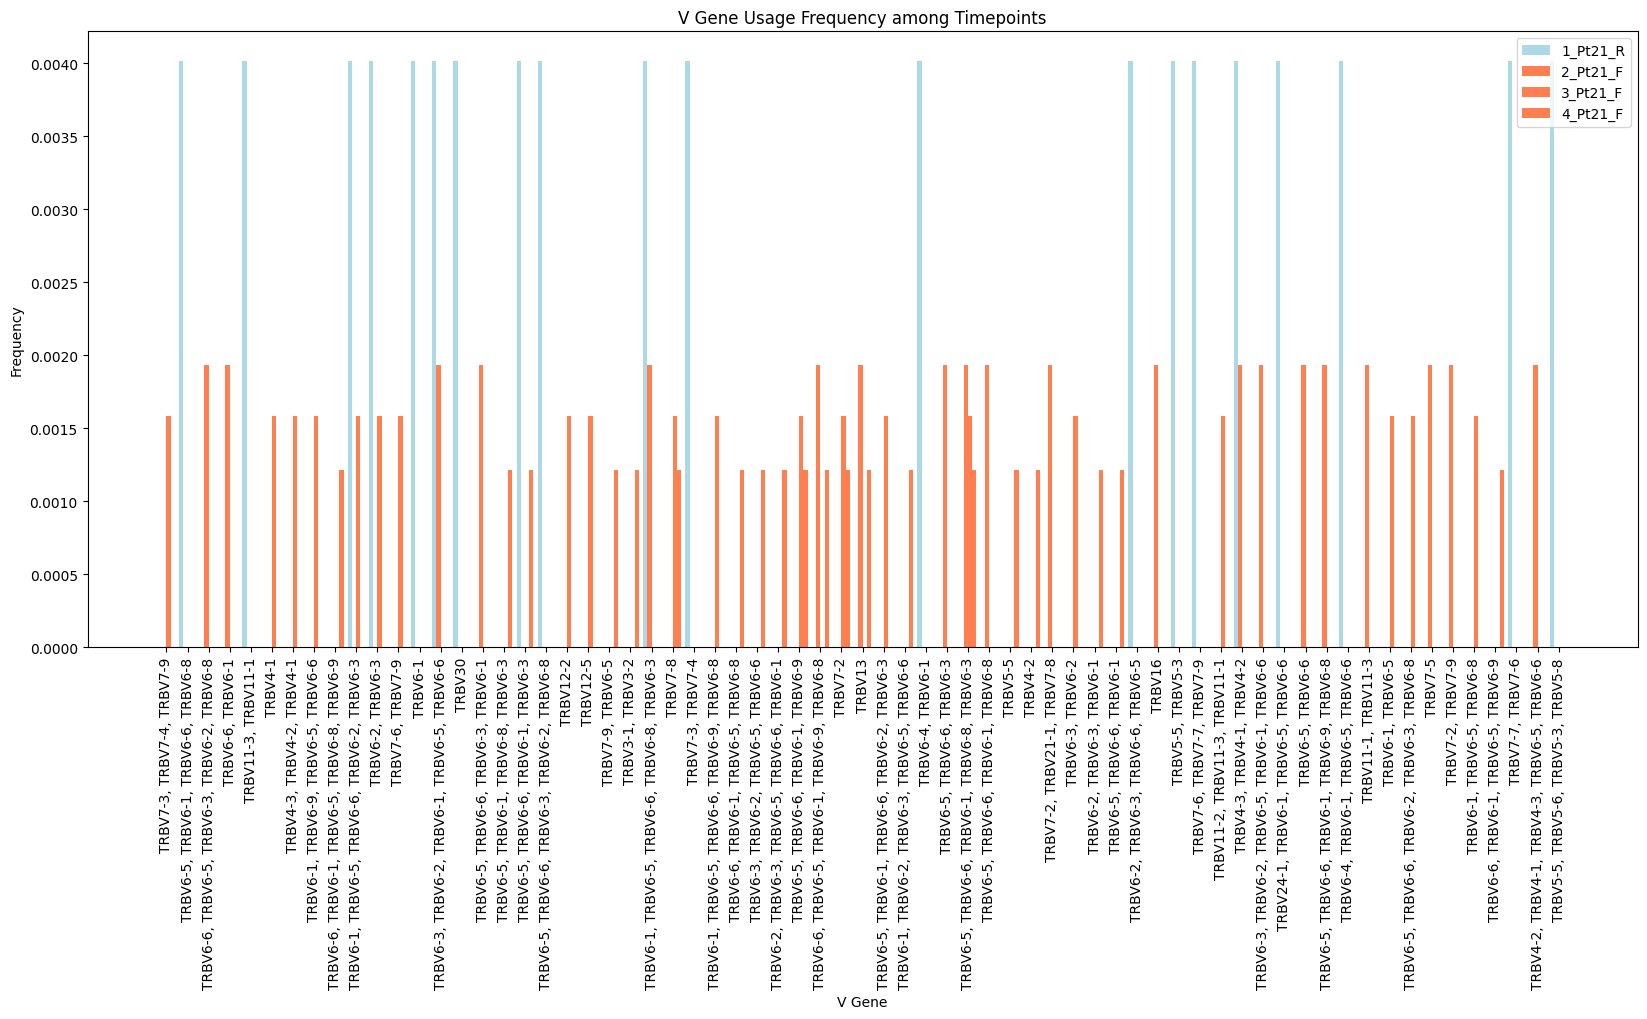

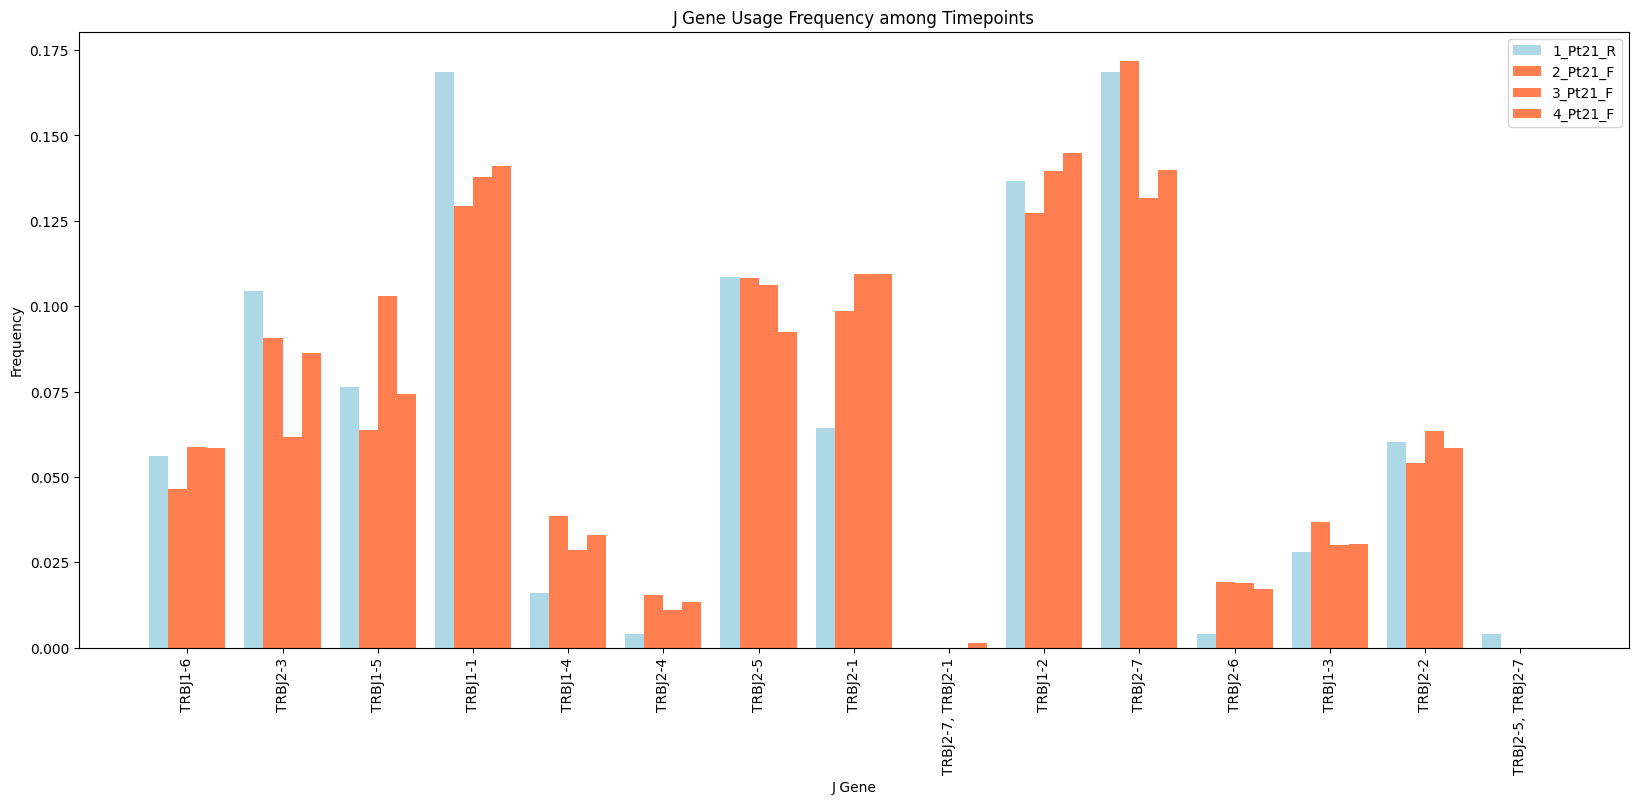

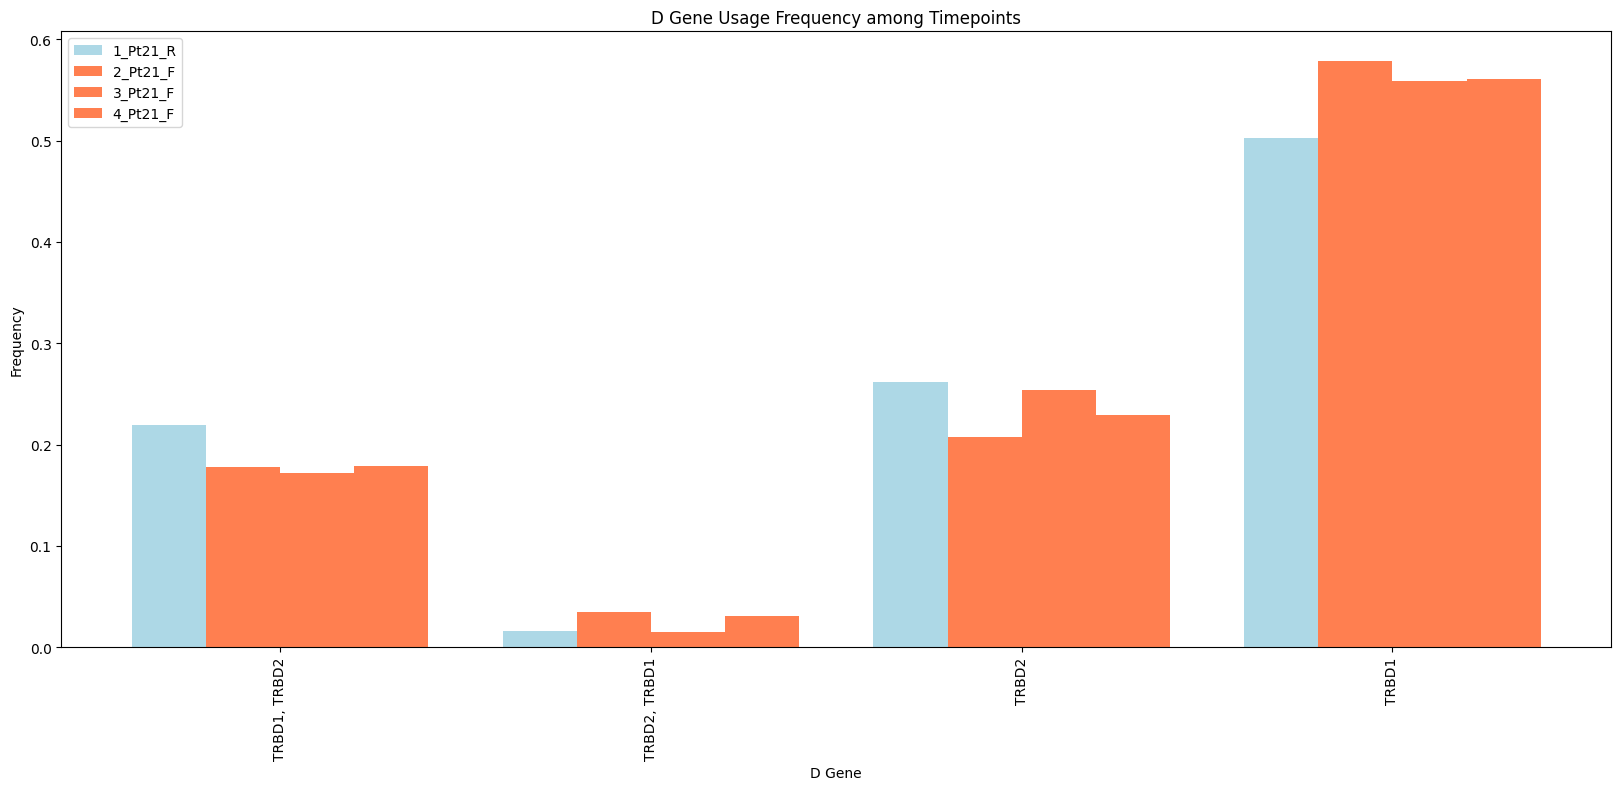

In [25]:
filedir = 'C:/Users/administer/Desktop/PCM__EHR/pigeon/data/TCR Data/'
for i in range(1, 22):
    relative_path = f'C:/Users/administer/Desktop/PCM__EHR/pigeon/data/TCR Data/Pt{i}/'
    file_list = [os.path.join(relative_path, file) for file in os.listdir(os.path.join(filedir, relative_path)) if 'metadata' not in file]
    fig1, ax1 = plot_gene_usage(file_list, 'V', figsize=(20, 8), head=True)
    plt.savefig(f'C:/Users/administer/Desktop/PCM__EHR/pigeon/ehr/feature_analysis/gene_usage/longitudinal/Pt{i}/Pt{i}_V_top20.png')
    fig2, ax2 = plot_gene_usage(file_list, 'V', figsize=(20, 8), head=False)
    plt.savefig(f'C:/Users/administer/Desktop/PCM__EHR/pigeon/ehr/feature_analysis/gene_usage/longitudinal/Pt{i}/Pt{i}_V_bottom20.png')
    fig3, ax3 = plot_gene_usage(file_list, 'J', figsize=(20, 8))
    plt.savefig(f'C:/Users/administer/Desktop/PCM__EHR/pigeon/ehr/feature_analysis/gene_usage/longitudinal/Pt{i}/Pt{i}_J.png')
    fig4, ax4 = plot_gene_usage(file_list, 'D', figsize=(20, 8))
    plt.savefig(f'C:/Users/administer/Desktop/PCM__EHR/pigeon/ehr/feature_analysis/gene_usage/longitudinal/Pt{i}/Pt{i}_D.png')

## Spectratype plot in V gene

In [55]:
# Get all the cdr3aa lengths and store them in a new column
def plot_spectratype(data, top_n, state):
    data['cdr3_length'] = data['cdr3aa'].str.len()
    top_v_genes = data['v'].value_counts().head(top_n).index
    v_genes = data[data['v'].isin(top_v_genes)]
    cdr3_spectrum_data = v_genes.groupby(['v', 'cdr3_length'])['count'].sum().reset_index()

    plt.figure(figsize=(14, 8))
    hist = sns.histplot(
        data=cdr3_spectrum_data,
        x='cdr3_length',
        weights='count',
        hue='v',
        multiple='stack',
        palette='Spectral',
        binwidth=1
    )

    plt.title(f'Spectratype: Top{top_n} V Gene Segement vs CDR3 Length in {state}', fontsize=16)
    plt.xlabel('CDR3 Length (Amino Acids)', fontsize=14)
    plt.ylabel('Count of V genes', fontsize=14)
    plt.xticks(range(0,30))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1400000)
    handles, labels = hist.get_legend().legendHandles, hist.get_legend().get_texts()
    plt.legend(
        handles=handles,
        labels=[label.get_text() for label in labels],
        title= f'Top{top_n} V Gene',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=False
    )
    plt.tight_layout()
    plt.show()



C:\Users\administer\AppData\Local\Temp\ipykernel_32252\353781350.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = hist.get_legend().legendHandles, hist.get_legend().get_texts()


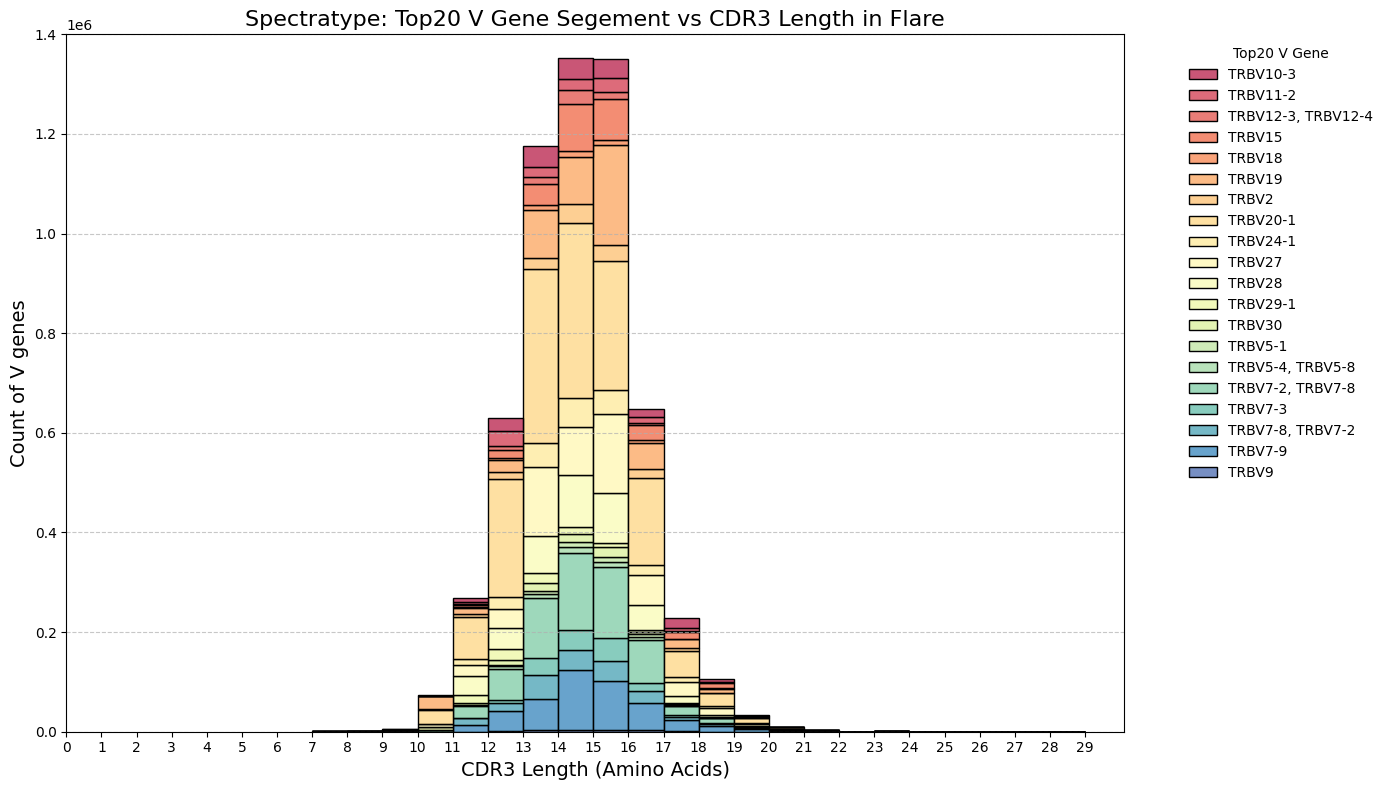

C:\Users\administer\AppData\Local\Temp\ipykernel_32252\353781350.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = hist.get_legend().legendHandles, hist.get_legend().get_texts()


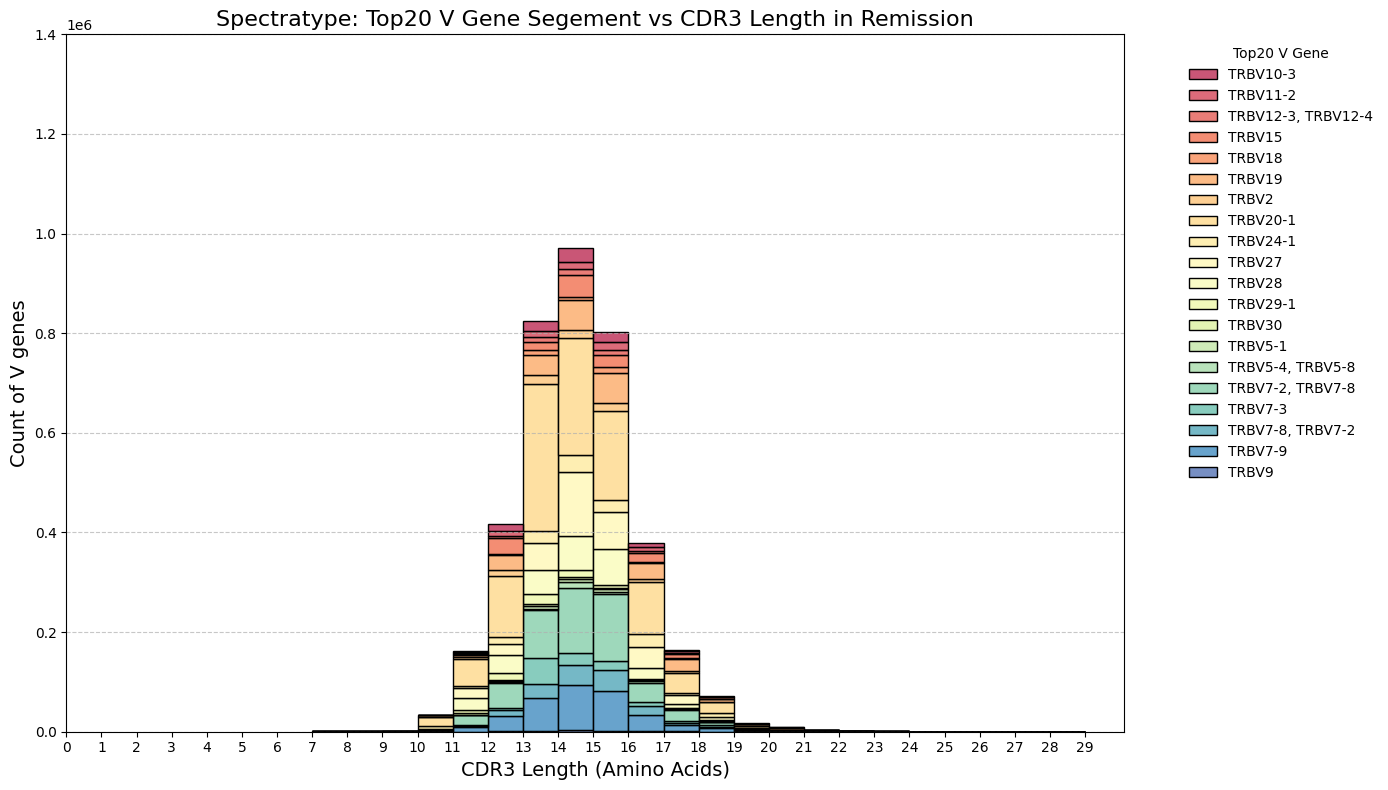

In [56]:
plot_spectratype(data_F, 20, 'Flare')
plot_spectratype(data_R, 20, 'Remission')

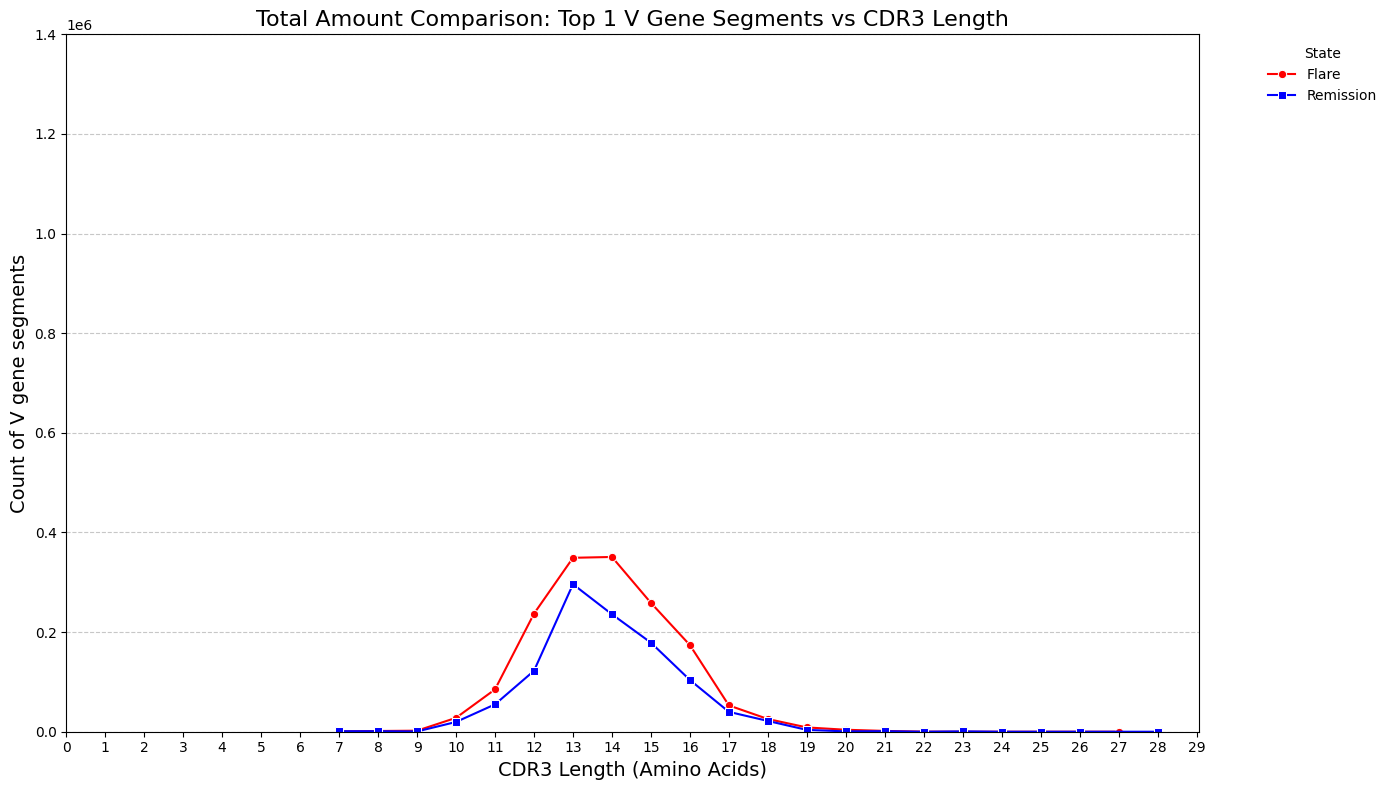

In [28]:
# Get all the cdr3aa lengths and store them in a new column
def plot_spectratype(data1, data2, top_n, state1, state2, ylim=None):
    data1['cdr3_length'] = data1['cdr3aa'].str.len()
    data2['cdr3_length'] = data2['cdr3aa'].str.len()
    
    top_v_genes1 = data1['v'].value_counts().head(top_n).index
    top_v_genes2 = data2['v'].value_counts().head(top_n).index
    top_v_genes = top_v_genes1.union(top_v_genes2)
    
    v_genes1 = data1[data1['v'].isin(top_v_genes)]
    v_genes2 = data2[data2['v'].isin(top_v_genes)]
    
    cdr3_spectrum_data1 = v_genes1.groupby('cdr3_length')['count'].sum().reset_index()
    cdr3_spectrum_data2 = v_genes2.groupby('cdr3_length')['count'].sum().reset_index()

    plt.figure(figsize=(14, 8))
    
    # Plot the first dataset
    sns.lineplot(
        data=cdr3_spectrum_data1,
        x='cdr3_length',
        y='count',
        marker='o',
        color='red',
        label=state1
    )
    
    # Plot the second dataset
    sns.lineplot(
        data=cdr3_spectrum_data2,
        x='cdr3_length',
        y='count',
        marker='s',
        color='blue',
        label=state2
    )

    plt.title(f'Total Amount Comparison: Top {top_n} V Gene Segments vs CDR3 Length', fontsize=16)
    plt.xlabel('CDR3 Length (Amino Acids)', fontsize=14)
    plt.ylabel('Count of V gene segments', fontsize=14)
    plt.xticks(range(min(cdr3_spectrum_data1['cdr3_length'].min(), cdr3_spectrum_data2['cdr3_length'].min()), 
                    max(cdr3_spectrum_data1['cdr3_length'].max(), cdr3_spectrum_data2['cdr3_length'].max()) + 1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if ylim is not None:
        plt.ylim(ylim)
    x_ticks = range(0, 30)
    plt.xticks(x_ticks)
    plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()

plot_spectratype(data_F, data_R, top_n=1, state1='Flare', state2='Remission', ylim=(0, 1400000))

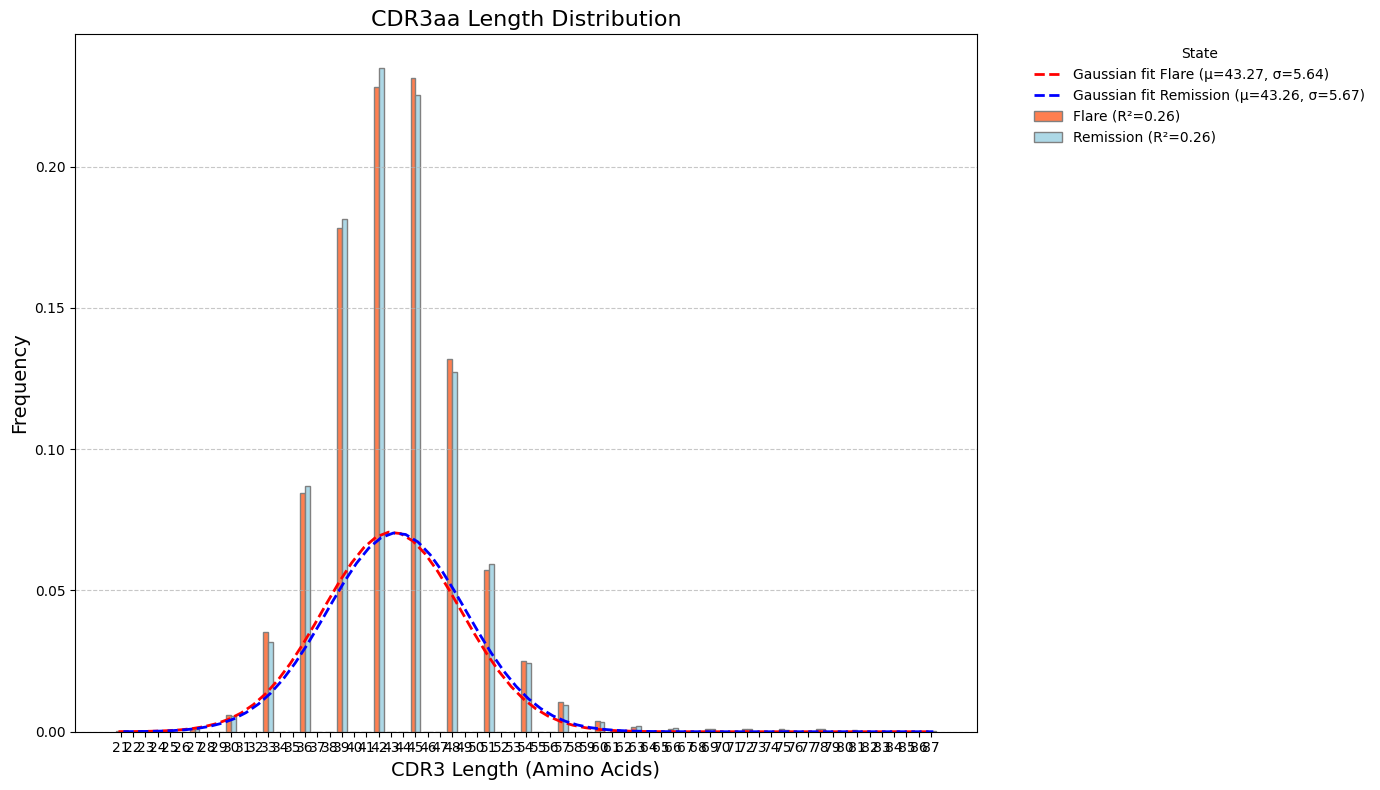

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.metrics import r2_score

# Get all the cdr3aa lengths and store them in a new column
def plot_cdr3_length_distribution(data1, data2, state1, state2, xlim=None):
    data1['cdr3_length'] = data1['cdr3aa'].str.len()
    data2['cdr3_length'] = data2['cdr3aa'].str.len()
    
    # Define the bin edges
    bins = np.arange(min(data1['cdr3_length'].min(), data2['cdr3_length'].min()), 
                     max(data1['cdr3_length'].max(), data2['cdr3_length'].max()) + 2)
    
    plt.figure(figsize=(14, 8))
    
    # Calculate the histogram data
    hist1, _ = np.histogram(data1['cdr3_length'], bins=bins, density=True)
    hist2, _ = np.histogram(data2['cdr3_length'], bins=bins, density=True)
    
    # Define the width of the bars
    bar_width = 0.4
    
    # Define the positions of the bars
    r1 = np.arange(len(hist1))
    r2 = [x + bar_width for x in r1]
    
    # Fit a Gaussian distribution to the data
    mu1, std1 = norm.fit(data1['cdr3_length'])
    mu2, std2 = norm.fit(data2['cdr3_length'])
    
    # Calculate the Gaussian PDF
    pdf1 = norm.pdf(bins[:-1], mu1, std1)
    pdf2 = norm.pdf(bins[:-1], mu2, std2)
    
    # Calculate R² value
    r2_value1 = r2_score(hist1, pdf1)
    r2_value2 = r2_score(hist2, pdf2)
    
    # Create the bar plots
    plt.bar(r1, hist1, color='coral', width=bar_width, edgecolor='grey', label=f'{state1} (R²={r2_value1:.2f})')
    plt.bar(r2, hist2, color='lightblue', width=bar_width, edgecolor='grey', label=f'{state2} (R²={r2_value2:.2f})')

    # Plot the Gaussian fit
    plt.plot(r1, pdf1, 'r--', linewidth=2, label=f'Gaussian fit {state1}')
    plt.plot(r2, pdf2, 'b--', linewidth=2, label=f'Gaussian fit {state2}')

    plt.title('CDR3aa Length Distribution', fontsize=16)
    plt.xlabel('CDR3 Length (Amino Acids)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks([r + bar_width / 2 for r in range(len(hist1))], bins[:-1])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if xlim is not None:
        plt.xlim(xlim)
    
    plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()

plot_cdr3_length_distribution(data_F, data_R, state1='Flare', state2='Remission')